**Statistiques descriptives des concentrations de NO₂**

**Objectif**  
Décrire la qualité, la variabilité, les niveaux, les pics et l’exposition sanitaire
des concentrations de NO₂ avant toute analyse causale.

**Contenu**
1. Qualité et complétude des données  
2. Niveaux et tendances temporelles  
3. Pics de pollution et exposition sanitaire  
4. Relations entre indicateurs et synthèse


**A rajouter dans requirements :**
seaborn
geopy

In [130]:
# ============================================================================
# Imports globaux — Statistiques descriptives NO2
# ============================================================================

import os
from pathlib import Path
import json
import warnings
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import geopandas as gpd
from shapely.geometry import Point, shape
from geopy.distance import geodesic

# Configuration
warnings.filterwarnings("ignore")

# Paramètres graphiques globaux
plt.rcParams["figure.figsize"] = (12, 6)
plt.rcParams["axes.grid"] = True
plt.rcParams["axes.titlesize"] = 14
plt.rcParams["axes.labelsize"] = 12

# Seuils globaux
OMS_DAILY = 25.0
UE_DAILY = 40.0


In [131]:
# ============================================================================
# CHEMINS ET CHARGEMENT DES DONNÉES
# ============================================================================

HERE = Path().resolve()
ROOT = HERE.parent if 'zfe-scm' in str(HERE) else HERE
DATA = ROOT / "data"

print("=" * 80)
print("📊 STATISTIQUES DESCRIPTIVES - IMPACT DES ZFE SUR LE NO₂")
print("=" * 80)

# Charger les métadonnées ZFE
zfe_meta = pd.read_csv(DATA / "zfe_meta.csv")
zfe_meta['first_date_debut'] = pd.to_datetime(zfe_meta['first_date_debut'])

# Dates de début des ZFE
grenoble_zfe_start = zfe_meta.loc[zfe_meta['publisher_zfe_id'] == 'GRENOBLE', 'first_date_debut'].iloc[0]
paris_zfe_start = zfe_meta.loc[zfe_meta['publisher_zfe_id'] == 'PARIS', 'first_date_debut'].iloc[0]

print(f"\n🎯 Dates clés :")
print(f"  • ZFE Grenoble : {grenoble_zfe_start.date()}")
print(f"  • ZFE Paris : {paris_zfe_start.date()}")

# Charger les données de pollution
grenoble_daily = pd.read_csv(DATA / "pollution_grenoble_no2_daily_clean.csv")
grenoble_daily['date'] = pd.to_datetime(grenoble_daily['date'])

paris_daily = pd.read_csv(DATA / "pollution_paris_no2_daily_clean.csv")
paris_daily['date'] = pd.to_datetime(paris_daily['date'])

# Charger les donneurs
donors_daily = pd.read_csv(DATA / "no2_all_stations_daily_clean.csv")
donors_daily['date'] = pd.to_datetime(donors_daily['date'])

print(f"\n📁 Données chargées :")
print(f"  • Grenoble : {len(grenoble_daily)} observations, {grenoble_daily['station_id'].nunique()} stations")
print(f"  • Paris : {len(paris_daily)} observations, {paris_daily['station_id'].nunique()} stations")
print(f"  • Donneurs : {len(donors_daily)} observations, {donors_daily['station_id'].nunique()} stations")


📊 STATISTIQUES DESCRIPTIVES - IMPACT DES ZFE SUR LE NO₂

🎯 Dates clés :
  • ZFE Grenoble : 2019-05-02
  • ZFE Paris : 2021-06-01

📁 Données chargées :
  • Grenoble : 5836 observations, 2 stations
  • Paris : 5268 observations, 2 stations
  • Donneurs : 28678 observations, 10 stations


## 1. Qualité et structure des données

Cette section évalue la complétude et la fiabilité des données de mesure,
afin de s’assurer que les analyses descriptives reposent sur des séries robustes.

### 1.1 Localisation des stations et périmètres étudiés


Cette carte présente le périmètre de la Zone à Faibles Émissions (ZFE) et la localisation des stations de mesure de NO₂ retenues (stations traitées et stations donneuses). Elle permet de vérifier la cohérence spatiale de l’évaluation (stations situées dans/près du périmètre ZFE vs stations plus périphériques) et d’anticiper des niveaux différenciés selon l’exposition au trafic. Le NO₂ étant principalement émis par le transport routier en zone urbaine dense, la proximité aux axes structurants et aux secteurs densément peuplés constitue un déterminant majeur des concentrations observées.


1️⃣ CARTOGRAPHIE AVEC GEOPANDAS
✅ Carte sauvegardée : stats_desc_carte_zfe.png


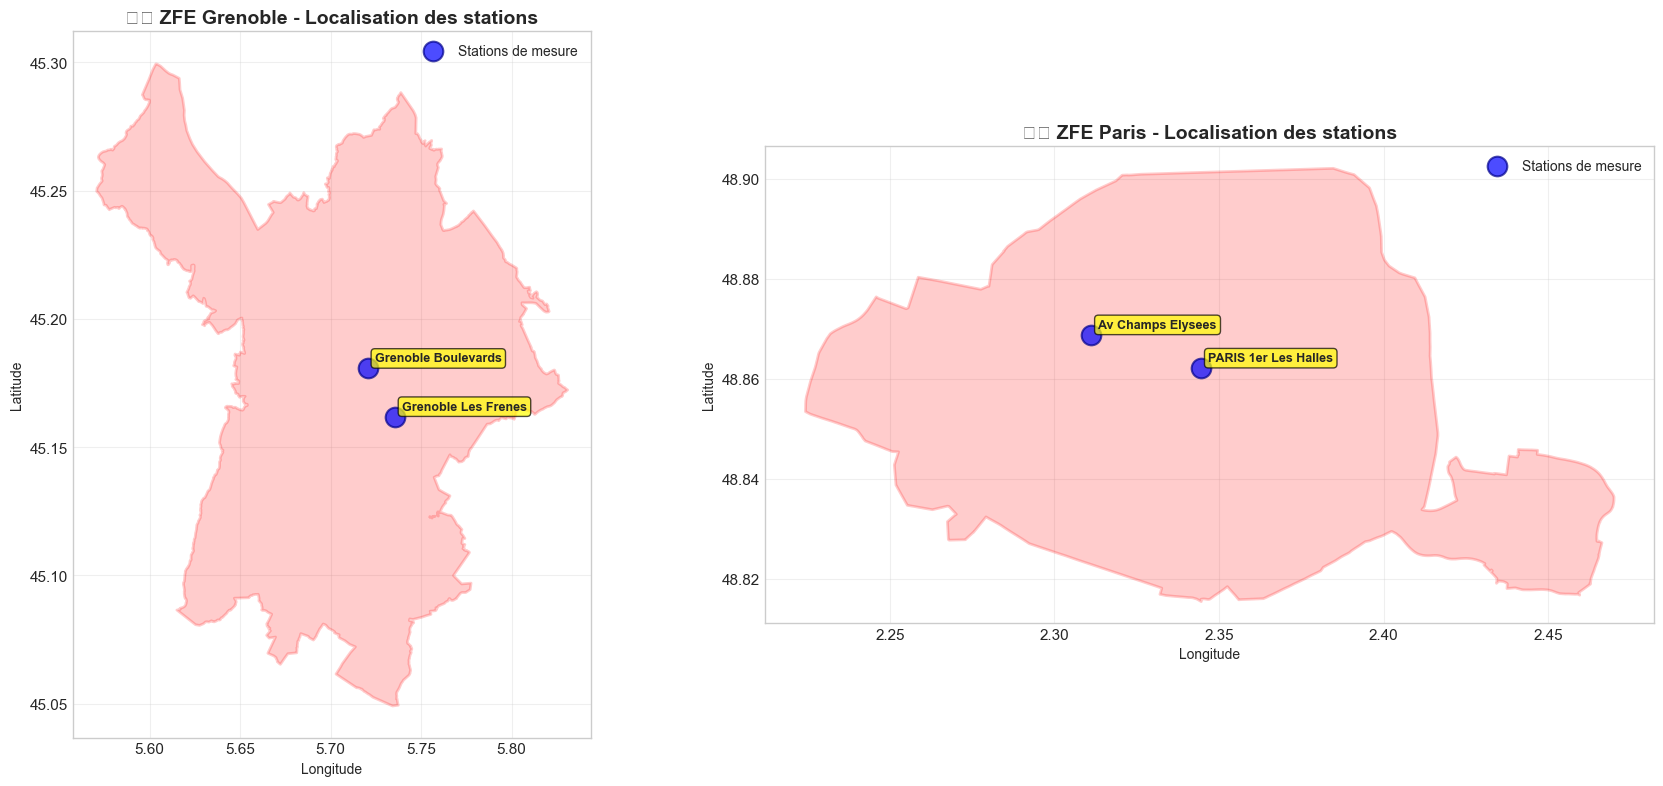

In [132]:
# ============================================================================
# 1. CARTOGRAPHIE - VISUALISATION GÉOGRAPHIQUE DES ZFE ET STATIONS
# ============================================================================

print("\n" + "=" * 80)
print("1️⃣ CARTOGRAPHIE AVEC GEOPANDAS")
print("=" * 80)

# Charger les périmètres ZFE
with open(DATA / "aires.geojson", encoding="utf-8") as f:
    zfe_geojson = json.load(f)

# Créer GeoDataFrame des ZFE
zfe_features = []
for feat in zfe_geojson['features']:
    pub = feat.get('publisher', {})
    zfe_id = pub.get('zfe_id')
    if zfe_id in ['GRENOBLE', 'PARIS']:
        zfe_features.append({
            'zfe_id': zfe_id,
            'nom': pub.get('nom'),
            'geometry': shape(feat['geometry'])
        })

gdf_zfe = gpd.GeoDataFrame(zfe_features, crs="EPSG:4326")

# Créer GeoDataFrame des stations
def create_stations_gdf(df, zfe_name):
    stations = df[['station_id', 'station_name', 'station_env', 'station_influence', 'lat', 'lon']].drop_duplicates()
    stations['geometry'] = stations.apply(lambda row: Point(row['lon'], row['lat']), axis=1)
    stations['ville'] = zfe_name
    return gpd.GeoDataFrame(stations, crs="EPSG:4326")

gdf_grenoble = create_stations_gdf(grenoble_daily, 'Grenoble')
gdf_paris = create_stations_gdf(paris_daily, 'Paris')
gdf_stations = pd.concat([gdf_grenoble, gdf_paris], ignore_index=True)

# Créer une carte pour chaque ville
fig, axes = plt.subplots(1, 2, figsize=(18, 8))

for idx, (ville, ax) in enumerate(zip(['GRENOBLE', 'PARIS'], axes)):
    # Périmètre ZFE
    zfe_subset = gdf_zfe[gdf_zfe['zfe_id'] == ville]
    zfe_subset.plot(ax=ax, color='red', alpha=0.2, edgecolor='red', linewidth=2, label='Périmètre ZFE')
    
    # Stations
    stations_subset = gdf_stations[gdf_stations['ville'] == ville.capitalize()]
    stations_subset.plot(ax=ax, color='blue', markersize=200, alpha=0.7, 
                         edgecolor='darkblue', linewidth=1.5, label='Stations de mesure')
    
    # Annotations
    for _, station in stations_subset.iterrows():
        ax.annotate(station['station_name'], 
                   xy=(station.geometry.x, station.geometry.y),
                   xytext=(5, 5), textcoords='offset points',
                   fontsize=9, fontweight='bold',
                   bbox=dict(boxstyle='round,pad=0.3', facecolor='yellow', alpha=0.7))
    
    ax.set_title(f"🗺️ ZFE {ville.capitalize()} - Localisation des stations", fontsize=14, fontweight='bold')
    ax.legend(loc='upper right', fontsize=10)
    ax.set_xlabel('Longitude', fontsize=10)
    ax.set_ylabel('Latitude', fontsize=10)
    ax.grid(True, alpha=0.3)

plt.tight_layout()
plt.savefig(DATA / 'stats_desc_carte_zfe.png', dpi=300, bbox_inches='tight')
print("✅ Carte sauvegardée : stats_desc_carte_zfe.png")
plt.show()

## 1.2 Complétude des données  

**Pourquoi étudier la complétudes des données?** 

L’évaluation de la complétude des données est une étape préalable essentielle à l’analyse des concentrations de NO₂, en particulier lorsque des indicateurs agrégés (moyennes, percentiles, jours de dépassement) sont mobilisés. Des séries temporelles incomplètes peuvent biaiser ces indicateurs, notamment ceux portant sur les concentrations extrêmes ou la fréquence des dépassements. Dans le cadre de cette étude, l’analyse de la complétude permet de définir un périmètre temporel et un ensemble de stations pour lesquels les comparaisons sont robustes, et d’éviter que les évolutions observées soient dues à des variations de disponibilité des données plutôt qu’à un effet réel de la ZFE.

Cette figure synthétise la complétude temporelle des données NO₂ (part des jours observés) par station et par année. Elle permet d’identifier les stations/années présentant des lacunes susceptibles de biaiser les comparaisons temporelles (ruptures de série, sous-couverture post-traitement, etc.). Dans la perspective d’une évaluation contrefactuelle, ce diagnostic sert à (i) justifier la période d’analyse, (ii) exclure/pondérer les séries trop incomplètes, et (iii) documenter la robustesse des résultats en évitant que des variations apparentes soient dues à des données manquantes plutôt qu’à une évolution réelle des concentrations.
Ainsi, la majorité des stations disposent de séries suffisamment complètes et stables dans le temps, ce qui suggère que les évolutions observées ne sont pas dues à des ruptures de données mais à des dynamiques réelles des concentrations.


1️⃣ QUALITÉ ET COMPLÉTUDE DES DONNÉES


group  year  n_stations  mean_days_obs  mean_pct_days_obs  \
0            Donneuses  2016          10          327.9               89.6   
1            Donneuses  2017          10          360.2               98.7   
2            Donneuses  2018          10          346.0               94.8   
3            Donneuses  2019          10          363.5               99.6   
4            Donneuses  2020          10          364.5               99.6   
5            Donneuses  2021          10          360.2               98.7   
6            Donneuses  2022          10          348.9               95.6   
7            Donneuses  2023          10          364.6               99.9   
8            Donneuses  2024          10           32.0                8.7   
9   Traitée - Grenoble  2016           2          330.5               90.3   
10  Traitée - Grenoble  2017           2          365.0              100.0   
11  Traitée - Grenoble  2018           2          363.5               99.6   
12  Traitée - Grenoble  2019           2          365.0              100.0   
13  Traitée - Grenoble  2020           2          364.5               99.6   
14  Traitée - Grenoble  2021           2          365.0              100.0   
15  Traitée - Grenoble  2022           2          364.5               99.9   
16  Traitée - Grenoble  2023           2          364.0               99.7   
17  Traitée - Grenoble  2024           2           36.0                9.8   
18     Traitée - Paris  2017           1          137.0               37.5   
19     Traitée - Paris  2018           1          363.0               99.5   
20     Traitée - Paris  2019           2          226.5               62.1   
21     Traitée - Paris  2020           2          366.0              100.0   
22     Traitée - Paris  2021           2          359.5               98.5   
23     Traitée - Paris  2022           2          363.0               99.5   
24     Traitée - Paris  2023           2          365.0              100.0   
25     Traitée - Paris  2024           2          366.0              100.0   
26     Traitée - Paris  2025           2          338.0               92.6   

    share_valid_years  
0               100.0  
1               100.0  
2                90.0  
3               100.0  
4               100.0  
5               100.0  
6               100.0  
7               100.0  
8                 0.0  
9               100.0  
10              100.0  
11              100.0  
12              100.0  
13              100.0  
14              100.0  
15              100.0  
16              100.0  
17                0.0  
18                0.0  
19              100.0  
20               50.0  
21              100.0  
22              100.0  
23              100.0  
24              100.0  
25              100.0  
26              100.0

✅ Tables de complétude sauvegardées :
   - stat_completude_station_annee.csv
   - stat_completude_resume_groupes.csv


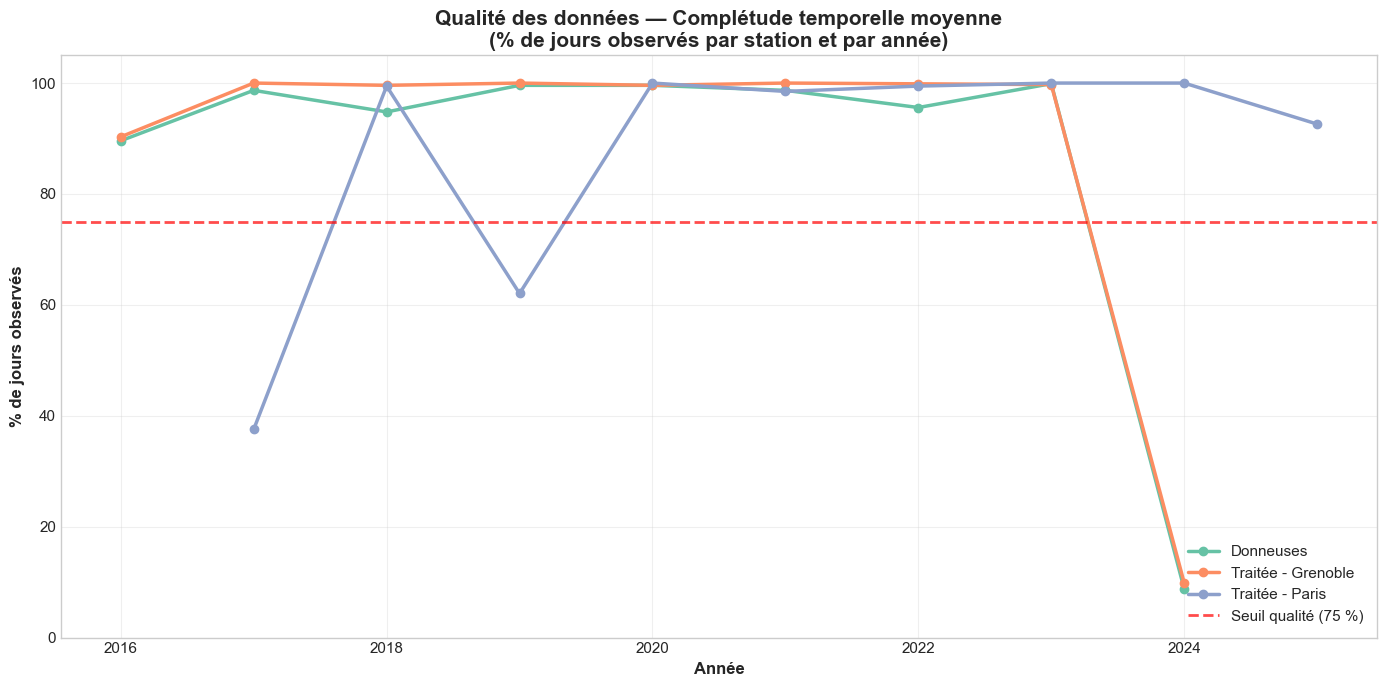

✅ Graphique sauvegardé : qualite_donnees_completude_pct_jours.png


In [133]:
# ============================================================================
# QUALITÉ & COMPLÉTUDE DES DONNÉES
# ============================================================================

print("\n" + "=" * 80)
print("1️⃣ QUALITÉ ET COMPLÉTUDE DES DONNÉES")
print("=" * 80)

import pandas as pd
import numpy as np

# ----------------------------
# 1) Préparation
# ----------------------------
df = all_no2.copy()
df["date"] = pd.to_datetime(df["date"])
df["year"] = df["date"].dt.year

# Nombre de jours théoriques par année (gestion années bissextiles)
days_per_year = (
    df[["year"]]
    .drop_duplicates()
    .assign(days_in_year=lambda x: x["year"].apply(
        lambda y: 366 if pd.Timestamp(f"{y}-12-31").dayofyear == 366 else 365
    ))
)

# ----------------------------
# 2) Complétude station–année
# ----------------------------
station_year_completeness = (
    df.groupby(["group", "station_id", "station_name", "year"])
      .agg(
          n_days_obs=("no2_ug_m3", "count"),
          n_days_non_null=("no2_ug_m3", lambda s: s.notna().sum())
      )
      .reset_index()
      .merge(days_per_year, on="year", how="left")
)

station_year_completeness["pct_days_obs"] = (
    100 * station_year_completeness["n_days_obs"] /
    station_year_completeness["days_in_year"]
)

# Année considérée comme "valide" (seuil classique EEA / OMS)
station_year_completeness["valid_year_75pct"] = (
    station_year_completeness["pct_days_obs"] >= 75
)

# ----------------------------
# 3) Résumé par groupe
# ----------------------------
completeness_summary = (
    station_year_completeness
    .groupby(["group", "year"])
    .agg(
        n_stations=("station_id", "nunique"),
        mean_days_obs=("n_days_obs", "mean"),
        mean_pct_days_obs=("pct_days_obs", "mean"),
        share_valid_years=("valid_year_75pct", "mean")
    )
    .reset_index()
)

completeness_summary["share_valid_years"] *= 100

# ----------------------------
# 4) Affichage & sauvegarde
# ----------------------------
display(
    completeness_summary
    .round({
        "mean_days_obs": 1,
        "mean_pct_days_obs": 1,
        "share_valid_years": 1
    })
)

station_year_completeness.to_csv(
    DATA / "stat_completude_station_annee.csv",
    index=False
)
completeness_summary.to_csv(
    DATA / "stat_completude_resume_groupes.csv",
    index=False
)

print("✅ Tables de complétude sauvegardées :")
print("   - stat_completude_station_annee.csv")
print("   - stat_completude_resume_groupes.csv")


# ============================================================================
# VISUALISATION — COMPLÉTUDE TEMPORELLE (% jours observés)
# ============================================================================

import matplotlib.pyplot as plt

fig, ax = plt.subplots(figsize=(14, 7))

for grp in completeness_summary["group"].unique():
    d = completeness_summary[completeness_summary["group"] == grp].sort_values("year")
    ax.plot(
        d["year"],
        d["mean_pct_days_obs"],
        marker="o",
        linewidth=2.5,
        label=grp
    )

# Seuil de qualité classique (75 %)
ax.axhline(
    75,
    color="red",
    linestyle="--",
    linewidth=2,
    alpha=0.7,
    label="Seuil qualité (75 %)"
)

# Lignes ZFE si dispo


ax.set_title(
    "Qualité des données — Complétude temporelle moyenne\n(% de jours observés par station et par année)",
    fontsize=15,
    fontweight="bold"
)
ax.set_xlabel("Année", fontsize=12, fontweight="bold")
ax.set_ylabel("% de jours observés", fontsize=12, fontweight="bold")

ax.set_ylim(0, 105)
ax.grid(True, alpha=0.3)
ax.legend(loc="lower right", fontsize=11)

plt.tight_layout()
plt.savefig(DATA / "qualite_donnees_completude_pct_jours.png", dpi=300, bbox_inches="tight")
plt.show()

print("✅ Graphique sauvegardé : qualite_donnees_completude_pct_jours.png")




## 1.3 Etude des stations donneuses

In [134]:
"""
ANALYSE APPROFONDIE DES STATIONS DONNEUSES
Cartographie, statistiques descriptives et validation du pool de contrôle
"""

# ============================================================================
# 0. CHARGEMENT DES DONNÉES
# ============================================================================

HERE = Path().resolve()
ROOT = HERE.parent if 'zfe-scm' in str(HERE) else HERE
DATA = ROOT / "data"

print("=" * 80)
print("🔍 ANALYSE APPROFONDIE DES STATIONS DONNEUSES")
print("=" * 80)

# Charger les données
donors_daily = pd.read_csv(DATA / "no2_all_stations_daily_clean.csv")
donors_daily['date'] = pd.to_datetime(donors_daily['date'])
donors_daily['station_id'] = donors_daily['station_id'].astype(str).str.strip()

grenoble_daily = pd.read_csv(DATA / "pollution_grenoble_no2_daily_clean.csv")
grenoble_daily['date'] = pd.to_datetime(grenoble_daily['date'])

paris_daily = pd.read_csv(DATA / "pollution_paris_no2_daily_clean.csv")
paris_daily['date'] = pd.to_datetime(paris_daily['date'])

# Métadonnées ZFE
zfe_meta = pd.read_csv(DATA / "zfe_meta.csv")
zfe_meta['first_date_debut'] = pd.to_datetime(zfe_meta['first_date_debut'])

print(f"\n📊 Données chargées :")
print(f"  • Stations donneuses : {donors_daily['station_id'].nunique()}")
print(f"  • Observations totales : {len(donors_daily):,}")
print(f"  • Période : {donors_daily['date'].min().date()} → {donors_daily['date'].max().date()}")

# ============================================================================
# 0. MÉTADONNÉES DES DONNEURS - TABLE COMPLÈTE
# ============================================================================

print("\n" + "=" * 80)
print("1️⃣ MÉTADONNÉES DES STATIONS DONNEUSES")
print("=" * 80)

# Créer table meta donneurs
donors_meta = (
    donors_daily
    .groupby(['station_id', 'station_name', 'station_env', 'station_influence'])
    .agg({
        'lat': 'first',
        'lon': 'first',
        'date': ['min', 'max'],
        'no2_ug_m3': ['count', 'mean', 'std']
    })
    .reset_index()
)

# Aplatir les colonnes multi-index
donors_meta.columns = ['station_id', 'station_name', 'station_env', 'station_influence',
                       'lat', 'lon', 'date_min', 'date_max', 
                       'n_obs', 'no2_mean', 'no2_std']

# Calculer durée de couverture
donors_meta['duree_jours'] = (donors_meta['date_max'] - donors_meta['date_min']).dt.days

# Identifier la ville (extraction basique depuis le nom)
donors_meta['ville'] = donors_meta['station_name'].str.split().str[0]

print("\n📋 TABLE DES STATIONS DONNEUSES :")
print(donors_meta[['ville', 'station_name', 'station_env', 'station_influence', 
                   'n_obs', 'no2_mean', 'duree_jours']].to_string(index=False))

# Sauvegarder
donors_meta.to_csv(DATA / 'stats_donneurs_meta.csv', index=False)
print(f"\n✅ Table sauvegardée : stats_donneurs_meta.csv")


🔍 ANALYSE APPROFONDIE DES STATIONS DONNEUSES

📊 Données chargées :
  • Stations donneuses : 10
  • Observations totales : 28,678
  • Période : 2016-02-05 → 2024-02-04

1️⃣ MÉTADONNÉES DES STATIONS DONNEUSES

📋 TABLE DES STATIONS DONNEUSES :
           ville        station_name station_env station_influence  n_obs  no2_mean  duree_jours
          Voiron       Voiron Urbain     Urbaine              Fond   2907 15.449776         2921
        Grenoble Grenoble PeriurbSud Périurbaine              Fond   2920  9.636333         2921
     Gresivaudan Gresivaudan Periurb Périurbaine              Fond   2921 13.729589         2921
             GAP     GAP JEAN JAURES     Urbaine            Trafic   2921 25.602191         2921
Bourgoin-Jallieu    Bourgoin-Jallieu     Urbaine              Fond   2647 11.431636         2921
        CHAMBERY    CHAMBERY LE HAUT     Urbaine              Fond   2787 13.933262         2921
           SAINT          SAINT JEAN     Urbaine              Fond   2916 10.849

Cette figure décrit la composition du dispositif de mesure selon (i) le type d’environnement (urbain/périurbain/rural) et (ii) le type d’influence (trafic/fond, selon la disponibilité des métadonnées). Cette typologie est structurante pour l’interprétation des niveaux de NO₂ : les stations « trafic » présentent généralement des concentrations plus élevées et plus variables que les stations de fond, en cohérence avec l’origine majoritairement routière du NO₂ en milieu urbain. Elle guide également la sélection du pool de donneurs afin d’éviter des comparaisons structurellement non comparables.


2️⃣ RÉPARTITION PAR TYPE DE STATION

📊 Répartition des donneurs :
                               n_stations  no2_mean  no2_std
station_env station_influence                               
Périurbaine Fond                        2     11.68     2.89
Urbaine     Fond                        6     13.69     2.87
            Trafic                      2     28.23     3.71
✅ Graphique sauvegardé : stats_donneurs_repartition_types.png


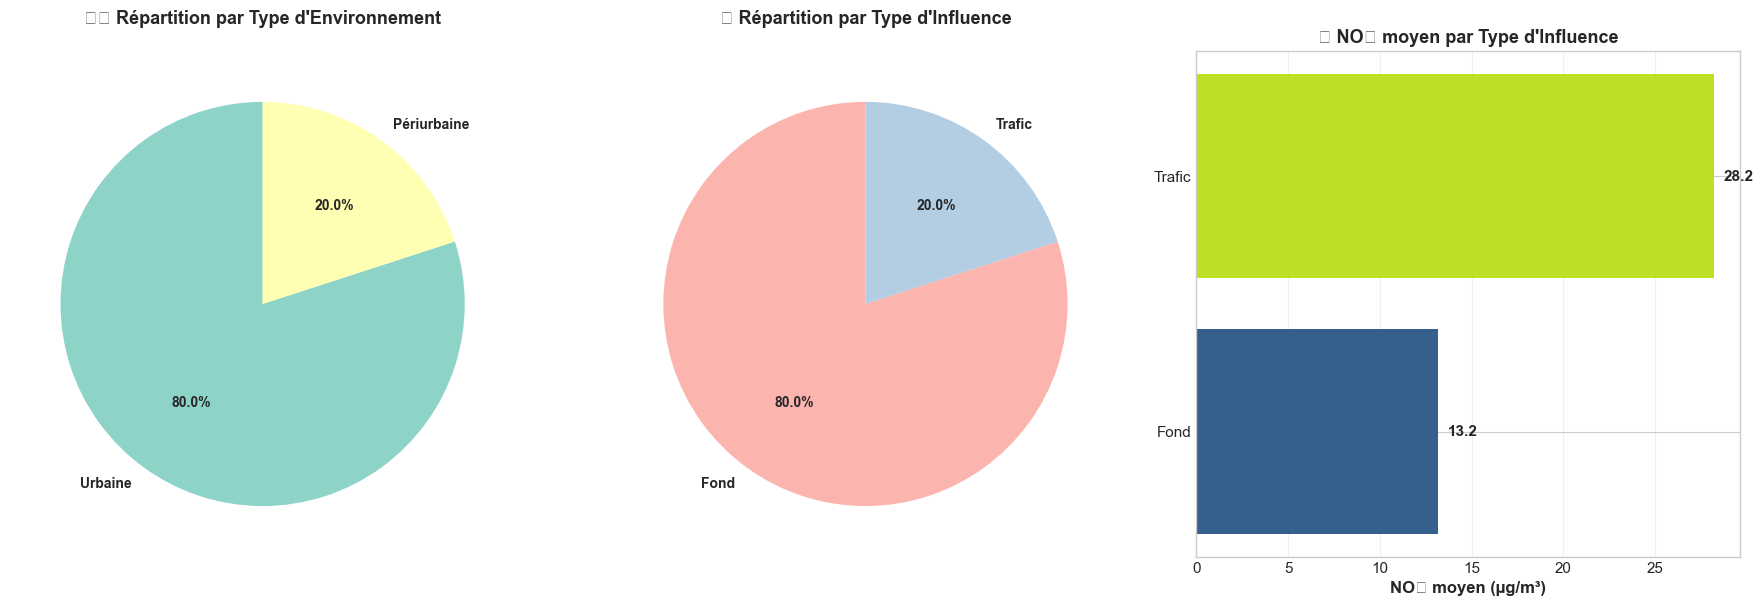

In [135]:
# ============================================================================
# 2. STATISTIQUES DESCRIPTIVES PAR TYPE DE STATION
# ============================================================================

print("\n" + "=" * 80)
print("2️⃣ RÉPARTITION PAR TYPE DE STATION")
print("=" * 80)

# Compter par type
type_counts = donors_meta.groupby(['station_env', 'station_influence']).agg({
    'station_id': 'count',
    'no2_mean': ['mean', 'std']
}).round(2)

type_counts.columns = ['n_stations', 'no2_mean', 'no2_std']
print("\n📊 Répartition des donneurs :")
print(type_counts)

# Graphique
fig, axes = plt.subplots(1, 3, figsize=(18, 6))

# Subplot 1 : Répartition par environnement
ax1 = axes[0]
env_counts = donors_meta['station_env'].value_counts()
colors = plt.cm.Set3(range(len(env_counts)))
wedges, texts, autotexts = ax1.pie(env_counts.values, labels=env_counts.index, 
                                     autopct='%1.1f%%', colors=colors,
                                     startangle=90, textprops={'fontsize': 10, 'weight': 'bold'})
ax1.set_title('🏙️ Répartition par Type d\'Environnement', fontsize=13, fontweight='bold', pad=20)

# Subplot 2 : Répartition par influence
ax2 = axes[1]
inf_counts = donors_meta['station_influence'].value_counts()
colors2 = plt.cm.Pastel1(range(len(inf_counts)))
wedges, texts, autotexts = ax2.pie(inf_counts.values, labels=inf_counts.index, 
                                     autopct='%1.1f%%', colors=colors2,
                                     startangle=90, textprops={'fontsize': 10, 'weight': 'bold'})
ax2.set_title('🚗 Répartition par Type d\'Influence', fontsize=13, fontweight='bold', pad=20)

# Subplot 3 : NO2 moyen par type
ax3 = axes[2]
type_no2 = donors_meta.groupby('station_influence')['no2_mean'].mean().sort_values()
bars = ax3.barh(range(len(type_no2)), type_no2.values, color=plt.cm.viridis(np.linspace(0.3, 0.9, len(type_no2))))
ax3.set_yticks(range(len(type_no2)))
ax3.set_yticklabels(type_no2.index)
ax3.set_xlabel('NO₂ moyen (µg/m³)', fontweight='bold')
ax3.set_title('📊 NO₂ moyen par Type d\'Influence', fontsize=13, fontweight='bold')
ax3.grid(True, alpha=0.3, axis='x')

# Annotations
for i, (val, label) in enumerate(zip(type_no2.values, type_no2.index)):
    ax3.text(val + 0.5, i, f'{val:.1f}', va='center', fontweight='bold')

plt.tight_layout()
plt.savefig(DATA / 'stats_donneurs_repartition_types.png', dpi=300, bbox_inches='tight')
print("✅ Graphique sauvegardé : stats_donneurs_repartition_types.png")
plt.show()



Cette carte zoomée présente le périmètre ZFE de Grenoble et la localisation des stations exploitées. Elle permet de vérifier la pertinence spatiale des stations traitées et donneuses (proximité au centre, aux axes structurants, et aux zones de forte densité), et de documenter une partie de l’hétérogénéité attendue des concentrations. Le NO₂ étant fortement corrélé au trafic routier, la lecture spatiale contribue à la justification du design d’évaluation et au choix du groupe de contrôle.

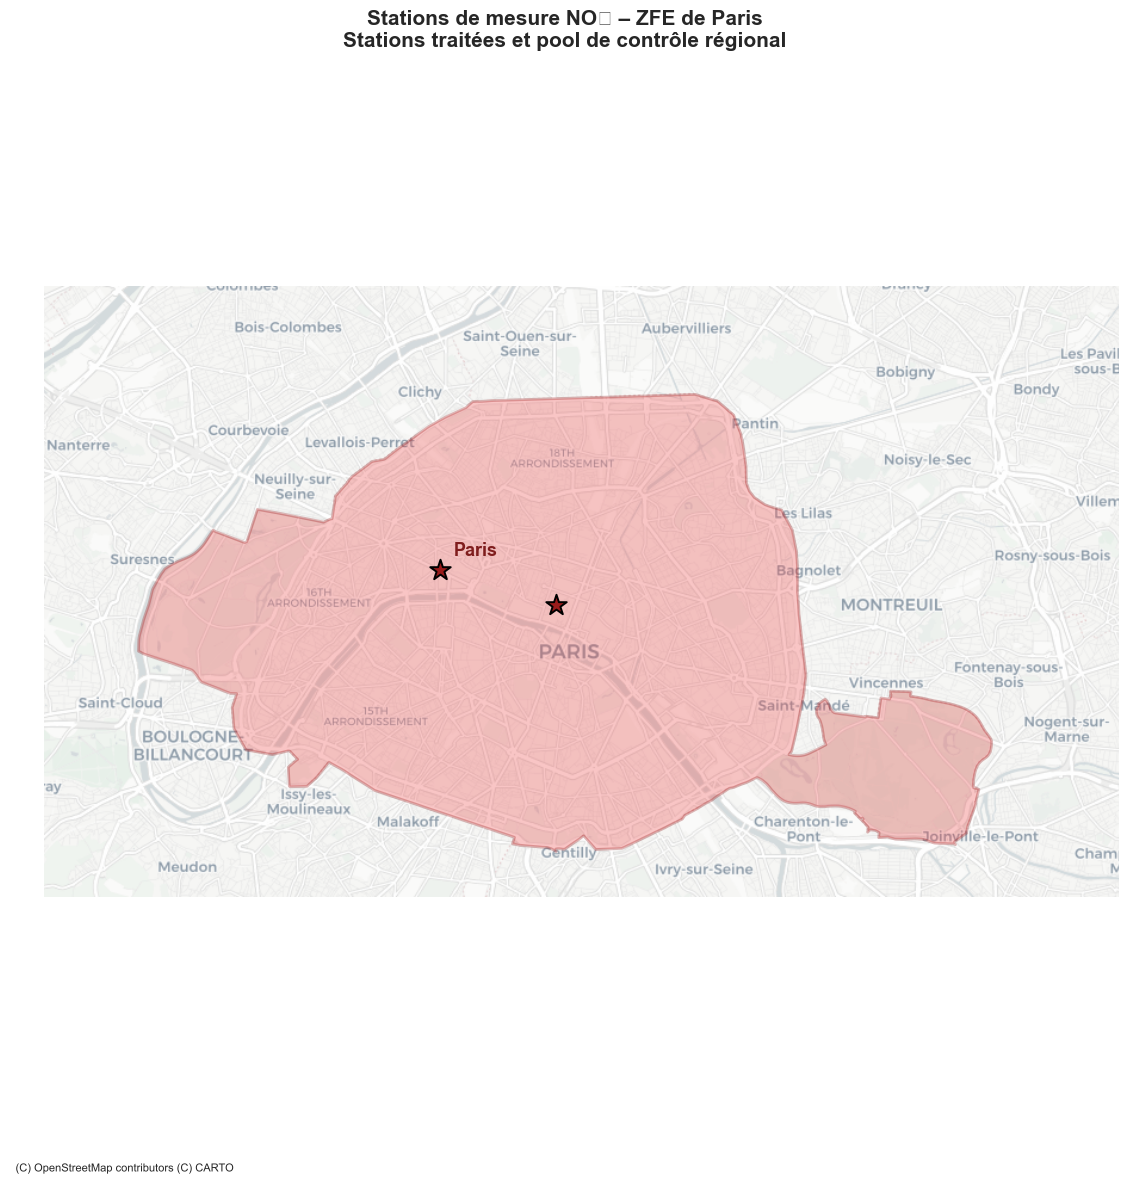

✅ Carte Paris sauvegardée : carte_paris_zoom.png


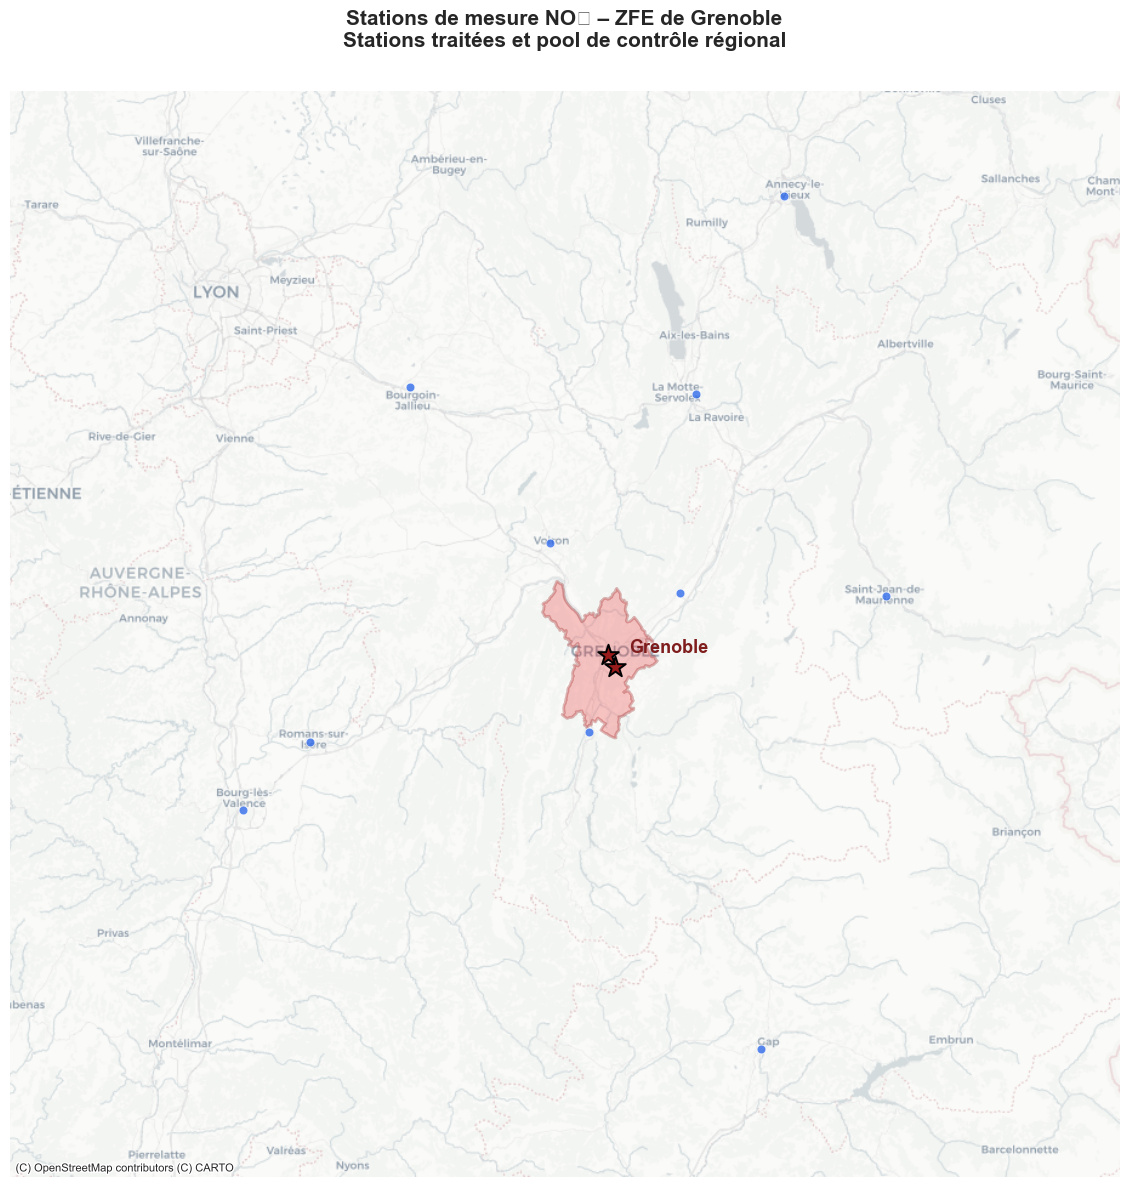

✅ Carte Grenoble sauvegardée : carte_grenoble_zoom.png


In [136]:
# ============================================================================
# CARTOGRAPHIES ZOOMÉES ZFE – PARIS & GRENOBLE
# Fond de carte via Contextily (API)
# Emprise basée sur donneurs + ZFE (robuste)
# ============================================================================


# ----------------------------------------------------------------------------
# 1. CRS
# ----------------------------------------------------------------------------
CRS_WGS84 = "EPSG:4326"
CRS_WEB = "EPSG:3857"  # requis pour Contextily

# ----------------------------------------------------------------------------
# 2. GEODATAFRAMES
# ----------------------------------------------------------------------------

# Stations donneuses
gdf_donors = gpd.GeoDataFrame(
    donors_meta,
    geometry=gpd.points_from_xy(donors_meta.lon, donors_meta.lat),
    crs=CRS_WGS84
)

# Stations traitées (Paris + Grenoble)
treated_stations = []
for df, ville in [(grenoble_daily, "Grenoble"), (paris_daily, "Paris")]:
    stations = df[["station_id", "station_name", "lat", "lon"]].drop_duplicates()
    for _, row in stations.iterrows():
        treated_stations.append({
            "station_id": row["station_id"],
            "station_name": row["station_name"],
            "ville": ville,
            "geometry": Point(row["lon"], row["lat"])
        })

gdf_treated = gpd.GeoDataFrame(treated_stations, crs=CRS_WGS84)

# ----------------------------------------------------------------------------
# 3. ZFE
# ----------------------------------------------------------------------------

with open(DATA / "aires.geojson", encoding="utf-8") as f:
    zfe_geojson = json.load(f)

zfe_features = []
for feat in zfe_geojson["features"]:
    pub = feat.get("publisher", {})
    if pub.get("zfe_id") in ["PARIS", "GRENOBLE"]:
        zfe_features.append({
            "zfe_id": pub.get("zfe_id"),
            "geometry": shape(feat["geometry"])
        })

gdf_zfe = gpd.GeoDataFrame(zfe_features, crs=CRS_WGS84)

# ----------------------------------------------------------------------------
# 4. REPROJECTION POUR CONTEXTILY
# ----------------------------------------------------------------------------

gdf_donors = gdf_donors.to_crs(CRS_WEB)
gdf_treated = gdf_treated.to_crs(CRS_WEB)
gdf_zfe = gdf_zfe.to_crs(CRS_WEB)

# ----------------------------------------------------------------------------
# 5. FONCTION DE CARTE ZOOMÉE ROBUSTE
# ----------------------------------------------------------------------------

def plot_zoom_map(ville, max_distance_km=180, padding_ratio=0.15):
    """
    Carte zoomée autour d'une ZFE
    Emprise calculée à partir des donneurs + ZFE + station traitée
    """

    max_distance_m = max_distance_km * 1_000

    # Sélections
    treated_city = gdf_treated[gdf_treated["ville"] == ville]
    zfe_city = gdf_zfe[gdf_zfe["zfe_id"] == ville.upper()]
    center = treated_city.geometry.iloc[0]

    # Distance donneurs → station traitée
    donors = gdf_donors.copy()
    donors["dist"] = donors.geometry.distance(center)
    donors_local = donors[donors["dist"] <= max_distance_m]

    # Géométries utiles
    all_geoms = pd.concat(
        [donors_local.geometry, zfe_city.geometry, treated_city.geometry]
    )

    xmin, ymin, xmax, ymax = all_geoms.total_bounds

    # Padding proportionnel
    dx = xmax - xmin
    dy = ymax - ymin
    xmin -= dx * padding_ratio
    xmax += dx * padding_ratio
    ymin -= dy * padding_ratio
    ymax += dy * padding_ratio

    # Forcer une emprise carrée (évite les fonds blancs)
    width = xmax - xmin
    height = ymax - ymin
    if width > height:
        diff = width - height
        ymin -= diff / 2
        ymax += diff / 2
    else:
        diff = height - width
        xmin -= diff / 2
        xmax += diff / 2

    # ------------------------------------------------------------------------
    # PLOT
    # ------------------------------------------------------------------------
    fig, ax = plt.subplots(figsize=(12, 12))

    # ZFE
    zfe_city.plot(
        ax=ax,
        color="#ef4444",
        alpha=0.3,
        edgecolor="#991b1b",
        linewidth=2,
        zorder=2
    )

    # Donneurs
    donors_local.plot(
        ax=ax,
        color="#2563eb",
        markersize=40,
        alpha=0.75,
        edgecolor="white",
        linewidth=0.6,
        zorder=3
    )

    # Station traitée
    treated_city.plot(
        ax=ax,
        color="#991b1b",
        markersize=240,
        marker="*",
        edgecolor="black",
        linewidth=1.4,
        zorder=4
    )

    # Annotation ville
    ax.annotate(
        ville,
        xy=(center.x, center.y),
        xytext=(10, 10),
        textcoords="offset points",
        fontsize=13,
        fontweight="bold",
        color="#7f1d1d"
    )

    # Fond de carte (API)
    ctx.add_basemap(
        ax,
        source=ctx.providers.CartoDB.Positron,
        attribution_size=8,
        zorder=1
    )

    ax.set_xlim(xmin, xmax)
    ax.set_ylim(ymin, ymax)

    ax.set_title(
        f"Stations de mesure NO₂ – ZFE de {ville}\n"
        f"Stations traitées et pool de contrôle régional",
        fontsize=15,
        fontweight="bold",
        pad=15
    )

    ax.set_axis_off()

    plt.tight_layout()
    plt.savefig(DATA / f"carte_{ville.lower()}_zoom.png", dpi=300, bbox_inches="tight")
    plt.show()

    print(f"✅ Carte {ville} sauvegardée : carte_{ville.lower()}_zoom.png")

# ----------------------------------------------------------------------------
# 6. GÉNÉRATION DES CARTES
# ----------------------------------------------------------------------------

plot_zoom_map("Paris", max_distance_km=200)
plot_zoom_map("Grenoble", max_distance_km=180)


Cette figure compare la proximité géographique (et/ou la répartition spatiale) entre stations traitées et stations donneuses, afin d’évaluer la cohérence du pool de contrôle. Elle permet de repérer d’éventuels donneurs trop éloignés ou situés dans des contextes urbains très différents, susceptibles de dégrader la comparabilité. Dans une logique de contrôle synthétique, cette étape réduit le risque de comparer une station urbaine/trafic à un environnement périphérique peu exposé, ce qui pourrait confondre l’effet de la ZFE avec des différences structurelles d’exposition.


5️⃣ ANALYSE DE PROXIMITÉ GÉOGRAPHIQUE
✅ Distances calculées et sauvegardées : stats_donneurs_distances.csv

6️⃣ COMPARAISON DONNEURS VS STATIONS TRAITÉES

📊 TABLEAU COMPARATIF SYNTHÉTIQUE :
            Groupe  NO₂ moyen (µg/m³)  Écart-type  Médiane   Min   Max  Nombre de stations
 Stations traitées              26.46        9.52    25.74 17.02 37.34                   4
Stations donneuses              16.20        6.92    13.83  9.64 30.85                  10


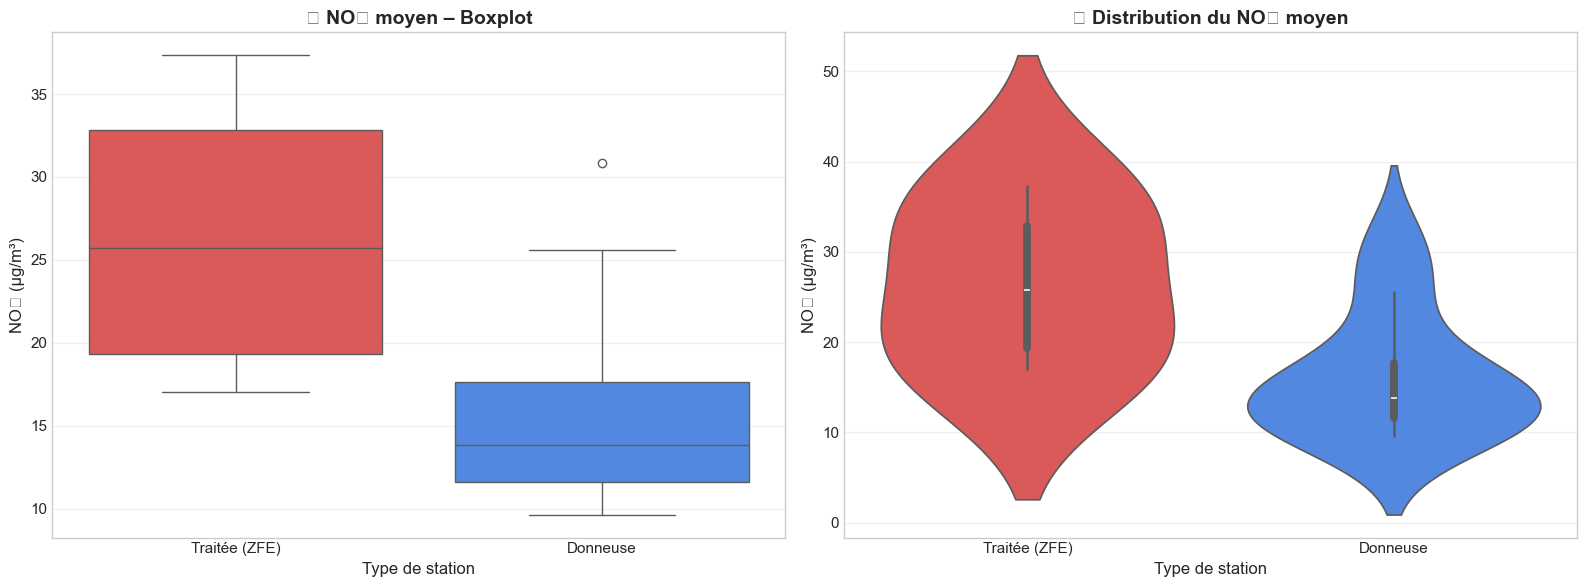

✅ Comparaison traitées / donneuses sauvegardée : stats_donneurs_comparaison_traitees.png


station_name     ville           type   no2_mean    no2_std  \
0   Grenoble Les Frenes  Grenoble  Traitée (ZFE)  17.021747   9.821403   
1   Grenoble Boulevards  Grenoble  Traitée (ZFE)  37.338978  14.901926   
2     Av Champs Elysees     Paris  Traitée (ZFE)  31.363383  15.221167   
3  PARIS 1er Les Halles     Paris  Traitée (ZFE)  20.107545  11.486412   

   no2_median  n_obs  
0        15.0   2919  
1        37.0   2917  
2        29.0   3015  
3        18.0   2253

no2_mean
count  10.000000
mean   16.195738
std     6.920323
min     9.636333
25%    11.593747
50%    13.831425
75%    17.660481
max    30.847899

In [137]:
# ============================================================================
# 5. ANALYSE DE PROXIMITÉ GÉOGRAPHIQUE (VERSION CORRECTE)
# ============================================================================

print("\n" + "=" * 80)
print("5️⃣ ANALYSE DE PROXIMITÉ GÉOGRAPHIQUE")
print("=" * 80)

from geopy.distance import geodesic

def calculate_distances(treated_station, donors_df):
    distances = []
    treated_coords = (treated_station["lat"], treated_station["lon"])

    for _, donor in donors_df.iterrows():
        donor_coords = (donor["lat"], donor["lon"])
        dist_km = geodesic(treated_coords, donor_coords).kilometers

        distances.append({
            "treated_station": treated_station["station_name"],
            "donor_station": donor["station_name"],
            "donor_ville": donor["ville"],
            "distance_km": dist_km,
            "donor_no2_mean": donor["no2_mean"]
        })

    return pd.DataFrame(distances)


# ---------------------------------------------------------------------------
# COORDONNÉES DES STATIONS TRAITÉES (SOURCE BRUTE)
# ---------------------------------------------------------------------------

treated_coords_list = []

for df, ville in [(grenoble_daily, "Grenoble"), (paris_daily, "Paris")]:
    stations = df[["station_name", "lat", "lon"]].drop_duplicates()
    for _, row in stations.iterrows():
        treated_coords_list.append({
            "station_name": row["station_name"],
            "lat": row["lat"],
            "lon": row["lon"]
        })

treated_coords_df = pd.DataFrame(treated_coords_list)

# ---------------------------------------------------------------------------
# CALCUL DES DISTANCES
# ---------------------------------------------------------------------------

all_distances = []

for _, treated in treated_coords_df.iterrows():
    all_distances.append(
        calculate_distances(treated, donors_meta)
    )

distances_df = pd.concat(all_distances, ignore_index=True)

# Sauvegarde
distances_df.to_csv(DATA / "stats_donneurs_distances.csv", index=False)

print("✅ Distances calculées et sauvegardées : stats_donneurs_distances.csv")

# ============================================================================
# 6. COMPARAISON STATISTIQUE DONNEURS VS STATIONS TRAITÉES
# ============================================================================

print("\n" + "=" * 80)
print("6️⃣ COMPARAISON DONNEURS VS STATIONS TRAITÉES")
print("=" * 80)

import seaborn as sns
import matplotlib.pyplot as plt

# ---------------------------------------------------------------------------
# 1. STATISTIQUES DES STATIONS TRAITÉES
# ---------------------------------------------------------------------------

treated_stats = []

for df, ville in [(grenoble_daily, "Grenoble"), (paris_daily, "Paris")]:
    for station_id in df["station_id"].unique():
        station_data = df[df["station_id"] == station_id]

        treated_stats.append({
            "station_name": station_data["station_name"].iloc[0],
            "ville": ville,
            "type": "Traitée (ZFE)",
            "no2_mean": station_data["no2_ug_m3"].mean(),
            "no2_std": station_data["no2_ug_m3"].std(),
            "no2_median": station_data["no2_ug_m3"].median(),
            "n_obs": len(station_data)
        })

treated_stats_df = pd.DataFrame(treated_stats)

# ---------------------------------------------------------------------------
# 2. STATISTIQUES DES STATIONS DONNEUSES
# ---------------------------------------------------------------------------

donors_stats_df = donors_meta.copy()
donors_stats_df["type"] = "Donneuse"

# Sécurité : on s'assure que la colonne existe
assert "no2_mean" in donors_stats_df.columns, "Colonne no2_mean absente de donors_meta"

# ---------------------------------------------------------------------------
# 3. TABLEAU COMPARATIF SYNTHÉTIQUE
# ---------------------------------------------------------------------------

summary_table = pd.DataFrame({
    "Groupe": ["Stations traitées", "Stations donneuses"],
    "NO₂ moyen (µg/m³)": [
        treated_stats_df["no2_mean"].mean(),
        donors_stats_df["no2_mean"].mean()
    ],
    "Écart-type": [
        treated_stats_df["no2_mean"].std(),
        donors_stats_df["no2_mean"].std()
    ],
    "Médiane": [
        treated_stats_df["no2_mean"].median(),
        donors_stats_df["no2_mean"].median()
    ],
    "Min": [
        treated_stats_df["no2_mean"].min(),
        donors_stats_df["no2_mean"].min()
    ],
    "Max": [
        treated_stats_df["no2_mean"].max(),
        donors_stats_df["no2_mean"].max()
    ],
    "Nombre de stations": [
        len(treated_stats_df),
        len(donors_stats_df)
    ]
})

print("\n📊 TABLEAU COMPARATIF SYNTHÉTIQUE :")
print(summary_table.round(2).to_string(index=False))

# ---------------------------------------------------------------------------
# 4. VISUALISATIONS COMPARATIVES
# ---------------------------------------------------------------------------

all_stats = pd.concat([
    treated_stats_df[["type", "no2_mean"]].rename(columns={"no2_mean": "NO2"}),
    donors_stats_df[["type", "no2_mean"]].rename(columns={"no2_mean": "NO2"})
])

fig, axes = plt.subplots(1, 2, figsize=(16, 6))

# Boxplot
sns.boxplot(
    data=all_stats,
    x="type",
    y="NO2",
    ax=axes[0],
    palette=["#ef4444", "#3b82f6"]
)
axes[0].set_title("📦 NO₂ moyen – Boxplot", fontweight="bold")
axes[0].set_xlabel("Type de station")
axes[0].set_ylabel("NO₂ (µg/m³)")
axes[0].grid(True, alpha=0.3, axis="y")

# Violinplot
sns.violinplot(
    data=all_stats,
    x="type",
    y="NO2",
    ax=axes[1],
    palette=["#ef4444", "#3b82f6"],
    inner="box"
)
axes[1].set_title("🎻 Distribution du NO₂ moyen", fontweight="bold")
axes[1].set_xlabel("Type de station")
axes[1].set_ylabel("NO₂ (µg/m³)")
axes[1].grid(True, alpha=0.3, axis="y")

plt.tight_layout()
plt.savefig(DATA / "stats_donneurs_comparaison_traitees.png", dpi=300, bbox_inches="tight")
plt.show()

print("✅ Comparaison traitées / donneuses sauvegardée : stats_donneurs_comparaison_traitees.png")

# ---------------------------------------------------------------------------
# 5. AFFICHAGE DE CONTRÔLE (OPTIONNEL MAIS RECOMMANDÉ)
# ---------------------------------------------------------------------------

display(treated_stats_df.head())
display(donors_stats_df[["no2_mean"]].describe())


## 2. Niveaux généraux et variabilité saisonnière

Cette section décrit les niveaux moyens de NO₂, leur évolution temporelle
et leur variabilité saisonnière (hiver vs été).


Cette première figure met en évidence la saisonnalité des concentrations de NO₂ en comparant des niveaux moyens entre hiver et été. Les niveaux sont typiquement plus élevés en hiver, ce qui est cohérent avec des conditions de dispersion atmosphérique moins favorables et une intensification de certaines sources de combustion. La saisonnalité doit être explicitement prise en compte (par construction des périodes, contrôles saisonniers et/ou agrégation) afin d’éviter d’attribuer à la ZFE des variations essentiellement saisonnières.

Cette seconde figure présente un indicateur d’exposition sanitaire : la proportion de jours dépassant la valeur guide OMS en moyenne 24h pour le NO₂ (25 µg/m³), comparée entre hiver et été. Cet indicateur complète utilement la moyenne annuelle en se focalisant sur la fréquence des épisodes « à risque » : une politique peut réduire les dépassements sans modifier fortement la moyenne, ou inversement. La valeur guide OMS 24h (25 µg/m³) sert ici de repère sanitaire standardisé.


2️⃣ SAISONNALITÉ — Hiver vs Été
ℹ️ Année 2024 exclue des stats saisonnières (année partielle).
✅ CSV sauvegardé : no2_saisonnalite_station_annee_saison.csv
✅ CSV sauvegardé : no2_saisonnalite_resume_groupes.csv


group  year           season  n_stations  mean_no2  \
0         Donneuses  2016    Automne (SON)          10     20.14   
1         Donneuses  2016      Hiver (DJF)          10     32.82   
2         Donneuses  2016  Printemps (MAM)          10     16.86   
3         Donneuses  2016        Été (JJA)          10     11.91   
4         Donneuses  2017    Automne (SON)          10     20.39   
..              ...   ...              ...         ...       ...   
90  Traitée - Paris  2023        Été (JJA)           2     18.86   
91  Traitée - Paris  2025    Automne (SON)           2     20.57   
92  Traitée - Paris  2025      Hiver (DJF)           2     27.09   
93  Traitée - Paris  2025  Printemps (MAM)           2     21.36   
94  Traitée - Paris  2025        Été (JJA)           2     14.39   

    mean_pct_days_gt_25  mean_p90  
0                 27.45     30.20  
1                 60.56     48.90  
2                 19.09     27.26  
3                 10.04     17.21  
4                 29.53     33.64  
..                  ...       ...  
90                17.39     27.45  
91                24.73     32.50  
92                51.59     38.50  
93                23.91     34.85  
94                 8.70     23.40  

[95 rows x 7 columns]

✅ Figure sauvegardée : no2_saisonnalite_mean_hiver_ete.png


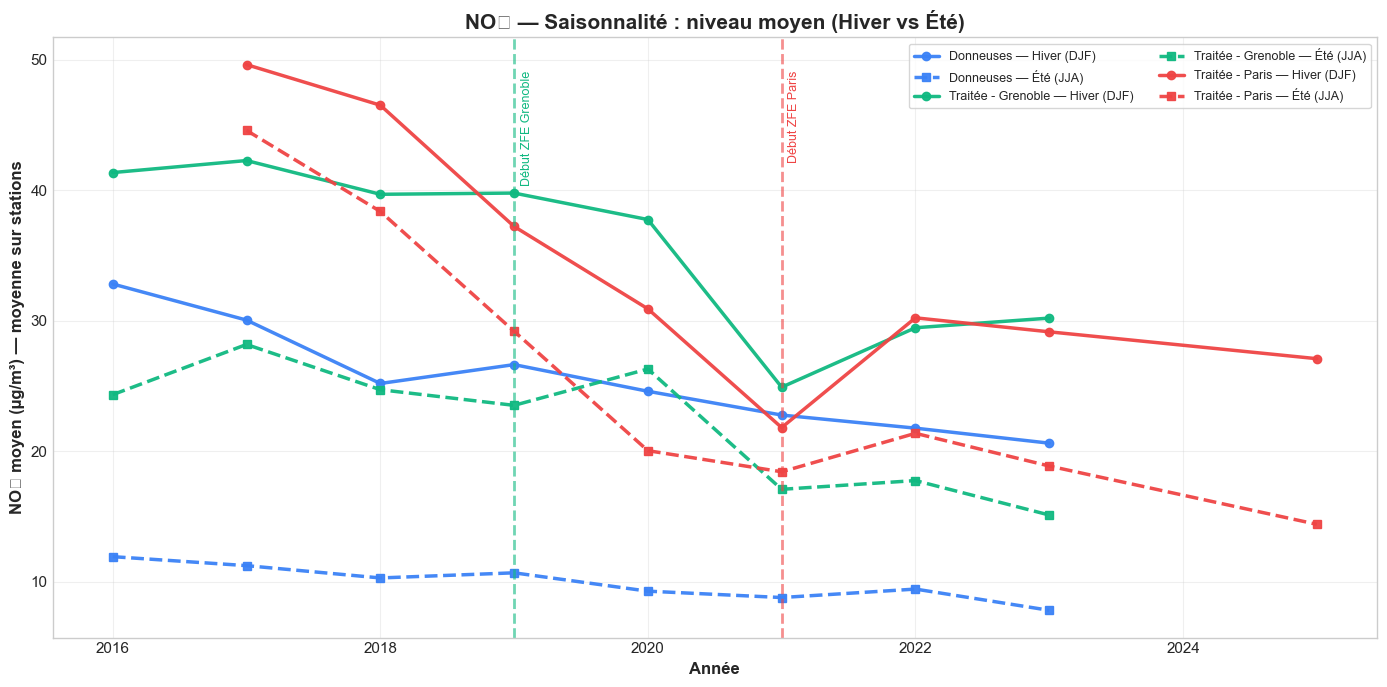

✅ Figure sauvegardée : no2_saisonnalite_oms_pctjours25_hiver_ete.png


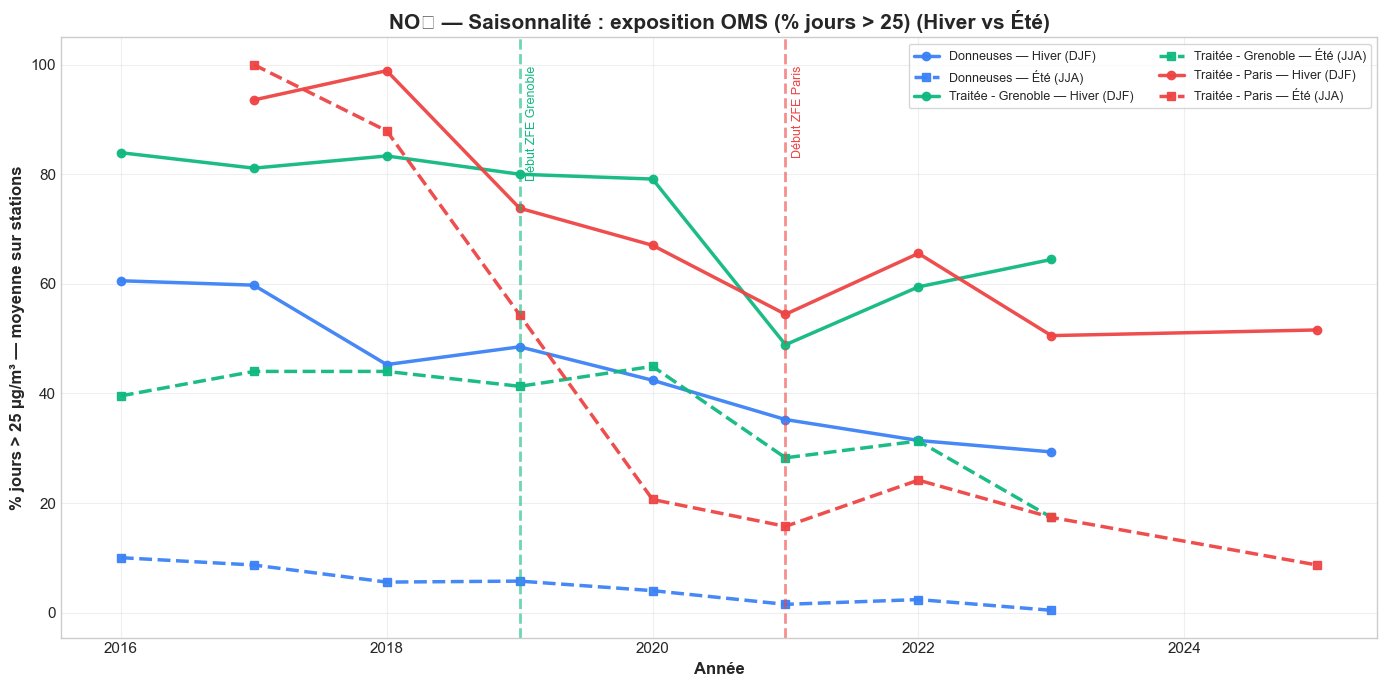

✅ Saisonnalité terminée (Hiver vs Été).


In [150]:
# ============================================================================
# SAISONNALITÉ (HIVER vs ÉTÉ) — NO2 (version robuste)
# ============================================================================

print("\n" + "=" * 80)
print("2️⃣ SAISONNALITÉ — Hiver vs Été")
print("=" * 80)


# ----------------------------
# 0) Pré-requis / fallback
# ----------------------------
if "all_no2" not in globals():
    raise NameError("all_no2 introuvable. Exécute d'abord la section qui concatène donors + traitées.")

# DATA doit idéalement être un Path
DATA_OK = ("DATA" in globals())
if DATA_OK:
    try:
        _ = DATA / "tmp_test.png"  # test opérateur /
    except Exception as e:
        print("⚠️ DATA existe mais n'est pas un Path compatible (ex: string). Les savefig seront ignorés.")
        DATA_OK = False
else:
    print("⚠️ DATA introuvable. Les savefig seront ignorés.")
    DATA_OK = False

# add_zfe_vlines peut ne pas exister / planter : on protège
def safe_add_zfe_vlines(ax):
    if "add_zfe_vlines" in globals():
        try:
            add_zfe_vlines(ax)
        except Exception as e:
            print(f"⚠️ add_zfe_vlines a échoué (ignoré) : {type(e).__name__} — {e}")

# ⚠️ On FORCE un dict de couleurs (même si une variable du même nom existe)
group_colors = {
    "Donneuses": "#3b82f6",
    "Traitée - Grenoble": "#10b981",
    "Traitée - Paris": "#ef4444",
}

# ----------------------------
# 1) Préparation des données
# ----------------------------
df = all_no2.copy()
df["date"] = pd.to_datetime(df["date"])
df["year"] = df["date"].dt.year
df["month"] = df["date"].dt.month

EXCLUDE_PARTIAL_YEAR = True
PARTIAL_YEAR = 2024
if EXCLUDE_PARTIAL_YEAR and PARTIAL_YEAR in df["year"].unique():
    df = df[df["year"] != PARTIAL_YEAR].copy()
    print(f"ℹ️ Année {PARTIAL_YEAR} exclue des stats saisonnières (année partielle).")

def season_from_month(m):
    if m in (12, 1, 2):
        return "Hiver (DJF)"
    if m in (3, 4, 5):
        return "Printemps (MAM)"
    if m in (6, 7, 8):
        return "Été (JJA)"
    return "Automne (SON)"

df["season"] = df["month"].apply(season_from_month)

OMS_DAILY = 25.0
df["flag_gt_25"] = df["no2_ug_m3"] > OMS_DAILY

# ----------------------------
# 2) Stats station–année–saison
# ----------------------------
station_year_season = (
    df.groupby(["group", "station_id", "station_name", "year", "season"])
      .agg(
          n_days=("no2_ug_m3", "count"),
          mean_no2=("no2_ug_m3", "mean"),
          median_no2=("no2_ug_m3", "median"),
          p90_no2=("no2_ug_m3", lambda s: np.nanpercentile(s.dropna(), 90) if s.dropna().shape[0] else np.nan),
          days_gt_25=("flag_gt_25", "sum"),
      )
      .reset_index()
)
station_year_season["pct_days_gt_25"] = 100 * station_year_season["days_gt_25"] / station_year_season["n_days"]

# Save CSV si possible
if DATA_OK:
    station_year_season.to_csv(DATA / "no2_saisonnalite_station_annee_saison.csv", index=False)
    print("✅ CSV sauvegardé : no2_saisonnalite_station_annee_saison.csv")

summary_gys = (
    station_year_season
    .groupby(["group", "year", "season"])
    .agg(
        n_stations=("station_id", "nunique"),
        mean_no2=("mean_no2", "mean"),
        mean_pct_days_gt_25=("pct_days_gt_25", "mean"),
        mean_p90=("p90_no2", "mean"),
    )
    .reset_index()
)

if DATA_OK:
    summary_gys.to_csv(DATA / "no2_saisonnalite_resume_groupes.csv", index=False)
    print("✅ CSV sauvegardé : no2_saisonnalite_resume_groupes.csv")

display(summary_gys.round(2))

focus_seasons = ["Hiver (DJF)", "Été (JJA)"]
summary_focus = summary_gys[summary_gys["season"].isin(focus_seasons)].copy()

linestyles = {"Hiver (DJF)": "-", "Été (JJA)": "--"}
markers = {"Hiver (DJF)": "o", "Été (JJA)": "s"}

# ----------------------------
# 3) FIGURE 1 — moyenne NO2 hiver vs été
# ----------------------------
fig, ax = plt.subplots(figsize=(14, 7))

for grp in summary_focus["group"].unique():
    for seas in focus_seasons:
        d = summary_focus[(summary_focus["group"] == grp) & (summary_focus["season"] == seas)].sort_values("year")
        if d.empty:
            continue
        ax.plot(
            d["year"], d["mean_no2"],
            color=group_colors.get(grp, "gray"),
            linestyle=linestyles.get(seas, "-"),
            marker=markers.get(seas, None),
            linewidth=2.5, alpha=0.95,
            label=f"{grp} — {seas}"
        )

ax.set_title("NO₂ — Saisonnalité : niveau moyen (Hiver vs Été)", fontsize=15, fontweight="bold")
ax.set_xlabel("Année", fontweight="bold")
ax.set_ylabel("NO₂ moyen (µg/m³) — moyenne sur stations", fontweight="bold")
ax.grid(True, alpha=0.3)
safe_add_zfe_vlines(ax)
ax.legend(loc="upper right", fontsize=9, ncol=2, frameon=True)

plt.tight_layout()
if DATA_OK:
    try:
        plt.savefig(DATA / "no2_saisonnalite_mean_hiver_ete.png", dpi=300, bbox_inches="tight")
        print("✅ Figure sauvegardée : no2_saisonnalite_mean_hiver_ete.png")
    except Exception as e:
        print(f"⚠️ savefig Figure 1 a échoué (ignoré) : {type(e).__name__} — {e}")
plt.show()

# ----------------------------
# 4) FIGURE 2 — % jours > 25 hiver vs été
# ----------------------------
fig, ax = plt.subplots(figsize=(14, 7))

for grp in summary_focus["group"].unique():
    for seas in focus_seasons:
        d = summary_focus[(summary_focus["group"] == grp) & (summary_focus["season"] == seas)].sort_values("year")
        if d.empty:
            continue
        ax.plot(
            d["year"], d["mean_pct_days_gt_25"],
            color=group_colors.get(grp, "gray"),
            linestyle=linestyles.get(seas, "-"),
            marker=markers.get(seas, None),
            linewidth=2.5, alpha=0.95,
            label=f"{grp} — {seas}"
        )

ax.set_title("NO₂ — Saisonnalité : exposition OMS (% jours > 25) (Hiver vs Été)", fontsize=15, fontweight="bold")
ax.set_xlabel("Année", fontweight="bold")
ax.set_ylabel("% jours > 25 µg/m³ — moyenne sur stations", fontweight="bold")
ax.grid(True, alpha=0.3)
safe_add_zfe_vlines(ax)
ax.legend(loc="upper right", fontsize=9, ncol=2, frameon=True)

plt.tight_layout()
if DATA_OK:
    try:
        plt.savefig(DATA / "no2_saisonnalite_oms_pctjours25_hiver_ete.png", dpi=300, bbox_inches="tight")
        print("✅ Figure sauvegardée : no2_saisonnalite_oms_pctjours25_hiver_ete.png")
    except Exception as e:
        print(f"⚠️ savefig Figure 2 a échoué (ignoré) : {type(e).__name__} — {e}")
plt.show()

print("✅ Saisonnalité terminée (Hiver vs Été).")


## 3. Pics de pollution et exposition sanitaire

Cette section analyse les épisodes de forte pollution et l’exposition sanitaire,
au-delà des niveaux moyens.

### 3.1 Pics de pollution



Cette figure décrit l’évolution temporelle des concentrations de NO₂ (série(s) agrégée(s)), en mettant en évidence les tendances de long terme et la variabilité interannuelle. Elle sert à contextualiser toute comparaison pré/post : une baisse observée après la ZFE doit être interprétée à la lumière des tendances générales (régionales/nationales), de la saisonnalité, et d’éventuelles ruptures non liées à la politique. Dans une logique causale, ce graphique motive le recours à un contrefactuel (donneurs) plutôt qu’une lecture « avant/après » brute.


2️⃣ ÉVOLUTION TEMPORELLE DU NO₂
✅ Graphique sauvegardé : stats_desc_evolution_temporelle.png


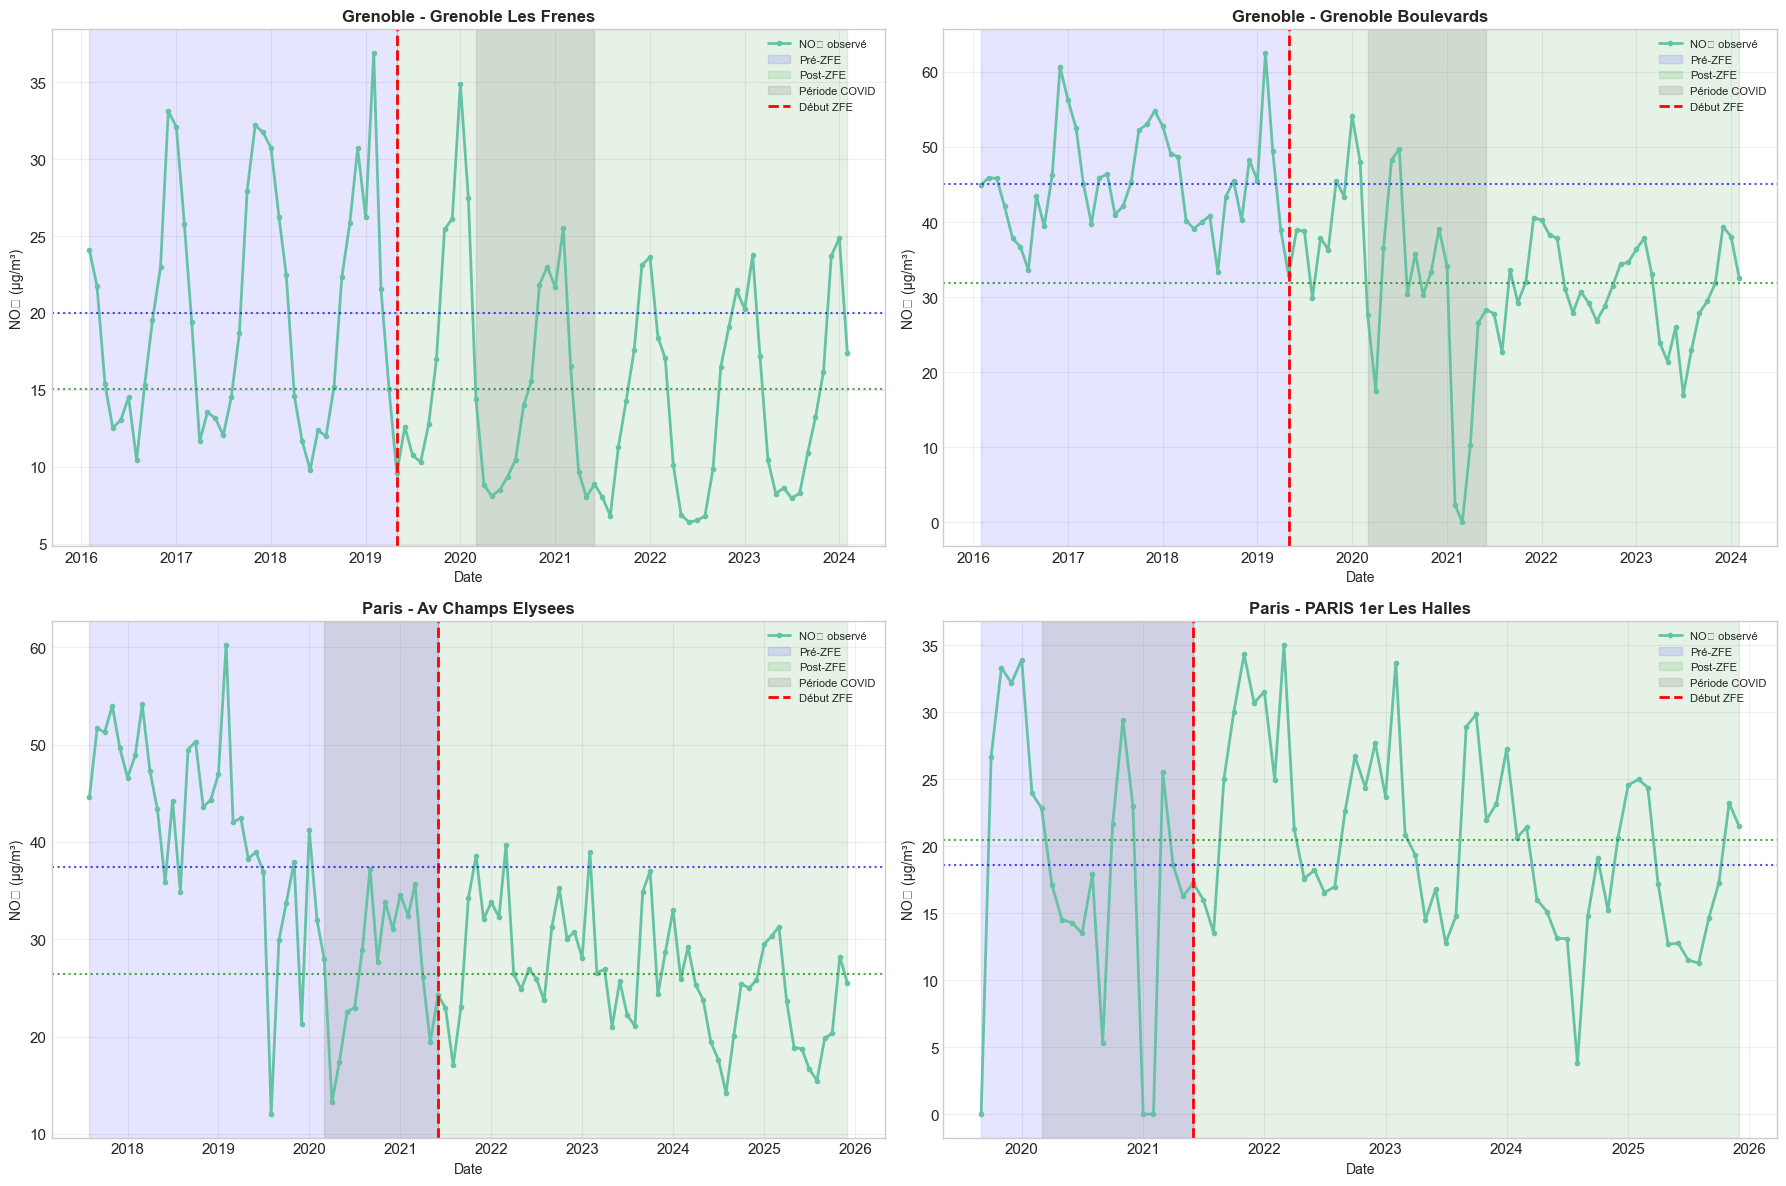

In [139]:
 #============================================================================
# 2. STATISTIQUES TEMPORELLES - ÉVOLUTION DU NO₂
# ============================================================================

print("\n" + "=" * 80)
print("2️⃣ ÉVOLUTION TEMPORELLE DU NO₂")
print("=" * 80)

def prepare_monthly_data(df, zfe_start):
    """Agrégation mensuelle avec marqueur pré/post ZFE"""
    monthly = df.set_index('date').groupby('station_id')['no2_ug_m3'].resample('MS').mean().reset_index()
    monthly['period'] = monthly['date'].apply(lambda x: 'Pré-ZFE' if x < zfe_start else 'Post-ZFE')
    # Exclure période COVID (mars 2020 - juin 2021)
    covid_mask = (monthly['date'] >= '2020-03-01') & (monthly['date'] <= '2021-06-01')
    monthly['period_clean'] = monthly['period'].copy()
    monthly.loc[covid_mask, 'period_clean'] = 'COVID (exclu)'
    return monthly

grenoble_monthly = prepare_monthly_data(grenoble_daily, grenoble_zfe_start)
paris_monthly = prepare_monthly_data(paris_daily, paris_zfe_start)

# Graphique multi-stations
fig, axes = plt.subplots(2, 2, figsize=(18, 12))
axes = axes.flatten()

datasets = [
    (grenoble_monthly, 'Grenoble', grenoble_zfe_start),
    (paris_monthly, 'Paris', paris_zfe_start)
]

for idx, (monthly_df, ville, zfe_date) in enumerate(datasets):
    stations = monthly_df['station_id'].unique()
    
    for i, station_id in enumerate(stations[:2]):  # 2 stations max par ville
        ax = axes[idx * 2 + i]
        station_data = monthly_df[monthly_df['station_id'] == station_id]
        station_name = grenoble_daily[grenoble_daily['station_id'] == station_id]['station_name'].iloc[0] if ville == 'Grenoble' else paris_daily[paris_daily['station_id'] == station_id]['station_name'].iloc[0]
        
        # Ligne temporelle
        ax.plot(station_data['date'], station_data['no2_ug_m3'], 
               linewidth=2, marker='o', markersize=3, label='NO₂ observé')
        
        # Zones colorées
        pre_data = station_data[station_data['period'] == 'Pré-ZFE']
        post_data = station_data[station_data['period'] == 'Post-ZFE']
        
        ax.axvspan(station_data['date'].min(), zfe_date, alpha=0.1, color='blue', label='Pré-ZFE')
        ax.axvspan(zfe_date, station_data['date'].max(), alpha=0.1, color='green', label='Post-ZFE')
        
        # Zone COVID
        ax.axvspan(pd.Timestamp('2020-03-01'), pd.Timestamp('2021-06-01'), 
                  alpha=0.2, color='gray', label='Période COVID')
        
        # Ligne verticale ZFE
        ax.axvline(zfe_date, color='red', linestyle='--', linewidth=2, label=f'Début ZFE')
        
        # Moyennes pré/post
        pre_mean = pre_data['no2_ug_m3'].mean()
        post_mean = post_data['no2_ug_m3'].mean()
        ax.axhline(pre_mean, color='blue', linestyle=':', alpha=0.7)
        ax.axhline(post_mean, color='green', linestyle=':', alpha=0.7)
        
        ax.set_title(f"{ville} - {station_name}", fontsize=12, fontweight='bold')
        ax.set_xlabel('Date', fontsize=10)
        ax.set_ylabel('NO₂ (µg/m³)', fontsize=10)
        ax.legend(loc='upper right', fontsize=8)
        ax.grid(True, alpha=0.3)

plt.tight_layout()
plt.savefig(DATA / 'stats_desc_evolution_temporelle.png', dpi=300, bbox_inches='tight')
print("✅ Graphique sauvegardé : stats_desc_evolution_temporelle.png")
plt.show()


Cette figure compare les niveaux de NO₂ entre périodes pré- et post-mise en œuvre (par station ou groupe), fournissant un premier diagnostic descriptif de l’évolution. Elle met en évidence l’hétérogénéité potentielle des variations selon les stations, ce qui est attendu si l’exposition au trafic varie localement. Cette comparaison est informative mais ne constitue pas une preuve causale : des facteurs confondants (météorologie, tendances globales d’émissions, changements de parc) peuvent produire des variations similaires en l’absence de ZFE.


3️⃣ COMPARAISONS PRÉ/POST ZFE

📊 TABLEAU RÉCAPITULATIF DES STATISTIQUES
   ville         station_name station_type  pre_mean  post_mean  reduction_pct       p_value
Grenoble  Grenoble Les Frenes         Fond 20.182203  15.080312     -25.279158  4.266285e-38
Grenoble  Grenoble Boulevards       Trafic 45.297119  33.231513     -26.636585 3.923517e-117
   Paris    Av Champs Elysees       Trafic 42.095135  26.396017     -37.294376 4.699024e-152
   Paris PARIS 1er Les Halles         Fond 28.728378  20.445902     -28.830297  1.051356e-18
✅ Tableau sauvegardé : stats_desc_tableau_recapitulatif.csv
✅ Graphique sauvegardé : stats_desc_comparaisons_pre_post.png


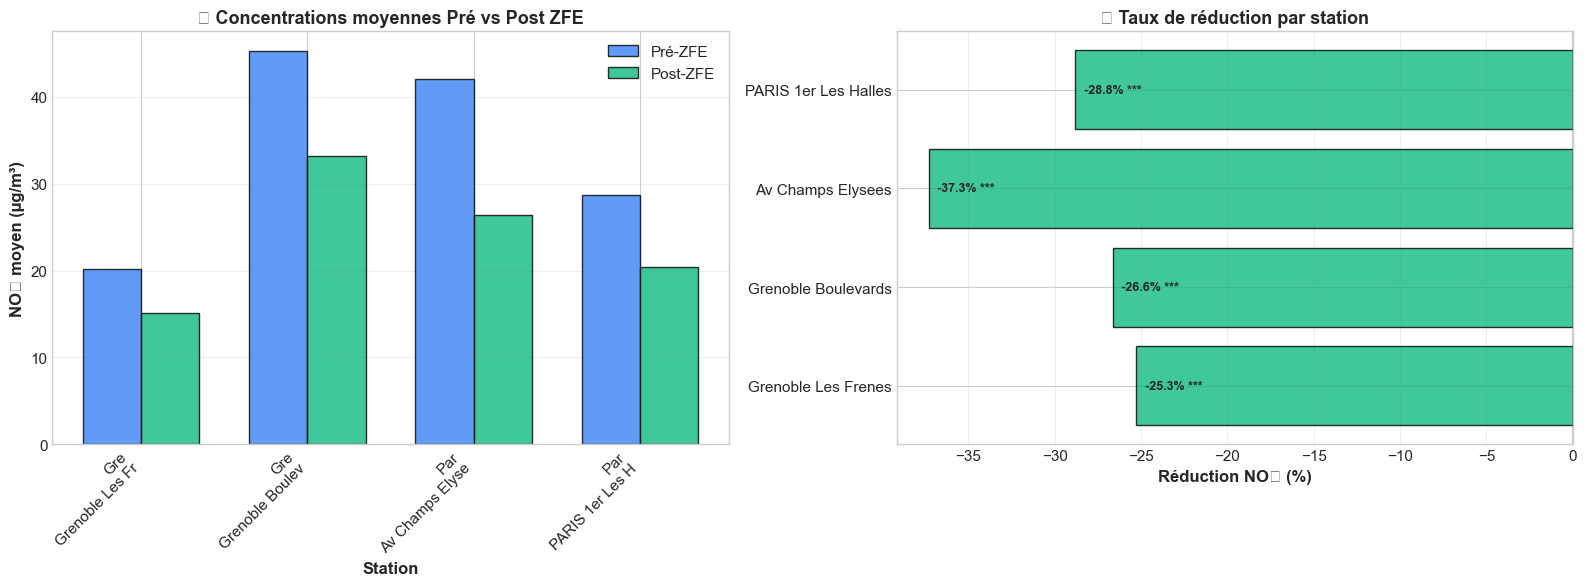

In [140]:
# ============================================================================
# 3. COMPARAISONS PRÉ/POST ZFE - STATISTIQUES DESCRIPTIVES
# ============================================================================

print("\n" + "=" * 80)
print("3️⃣ COMPARAISONS PRÉ/POST ZFE")
print("=" * 80)

def compute_pre_post_stats(df, zfe_start, ville):
    """Calculer statistiques pré/post pour chaque station"""
    results = []
    
    # Exclure COVID
    covid_mask = (df['date'] >= '2020-03-01') & (df['date'] <= '2021-06-01')
    df_clean = df[~covid_mask].copy()
    
    for station_id in df_clean['station_id'].unique():
        station_data = df_clean[df_clean['station_id'] == station_id]
        station_name = station_data['station_name'].iloc[0]
        station_type = station_data['station_influence'].iloc[0]
        
        # Séparer pré/post
        pre = station_data[station_data['date'] < zfe_start]['no2_ug_m3']
        post = station_data[station_data['date'] >= zfe_start]['no2_ug_m3']
        
        if len(pre) > 30 and len(post) > 30:  # Minimum 30 obs
            # Statistiques descriptives
            pre_mean, pre_std, pre_median = pre.mean(), pre.std(), pre.median()
            post_mean, post_std, post_median = post.mean(), post.std(), post.median()
            
            # Réduction
            reduction_abs = post_mean - pre_mean
            reduction_pct = (reduction_abs / pre_mean) * 100
            
            # Test statistique (t-test)
            t_stat, p_value = stats.ttest_ind(pre, post)
            
            results.append({
                'ville': ville,
                'station_id': station_id,
                'station_name': station_name,
                'station_type': station_type,
                'pre_mean': pre_mean,
                'pre_std': pre_std,
                'pre_median': pre_median,
                'post_mean': post_mean,
                'post_std': post_std,
                'post_median': post_median,
                'reduction_abs': reduction_abs,
                'reduction_pct': reduction_pct,
                't_stat': t_stat,
                'p_value': p_value,
                'n_obs_pre': len(pre),
                'n_obs_post': len(post)
            })
    
    return pd.DataFrame(results)

stats_grenoble = compute_pre_post_stats(grenoble_daily, grenoble_zfe_start, 'Grenoble')
stats_paris = compute_pre_post_stats(paris_daily, paris_zfe_start, 'Paris')
stats_all = pd.concat([stats_grenoble, stats_paris], ignore_index=True)

print("\n📊 TABLEAU RÉCAPITULATIF DES STATISTIQUES")
print("=" * 120)
print(stats_all[['ville', 'station_name', 'station_type', 'pre_mean', 'post_mean', 
                 'reduction_pct', 'p_value']].to_string(index=False))
print("=" * 120)

# Sauvegarder le tableau
stats_all.to_csv(DATA / 'stats_desc_tableau_recapitulatif.csv', index=False)
print("✅ Tableau sauvegardé : stats_desc_tableau_recapitulatif.csv")

# Graphique comparatif
fig, axes = plt.subplots(1, 2, figsize=(16, 6))

# Barplot moyennes
ax1 = axes[0]
x_pos = np.arange(len(stats_all))
width = 0.35
ax1.bar(x_pos - width/2, stats_all['pre_mean'], width, label='Pré-ZFE', 
       color='#3b82f6', alpha=0.8, edgecolor='black')
ax1.bar(x_pos + width/2, stats_all['post_mean'], width, label='Post-ZFE', 
       color='#10b981', alpha=0.8, edgecolor='black')
ax1.set_xlabel('Station', fontweight='bold')
ax1.set_ylabel('NO₂ moyen (µg/m³)', fontweight='bold')
ax1.set_title('📊 Concentrations moyennes Pré vs Post ZFE', fontsize=13, fontweight='bold')
ax1.set_xticks(x_pos)
ax1.set_xticklabels([f"{row['ville'][:3]}\n{row['station_name'][:15]}" 
                     for _, row in stats_all.iterrows()], rotation=45, ha='right')
ax1.legend()
ax1.grid(True, alpha=0.3, axis='y')

# Barplot réductions
ax2 = axes[1]
colors = ['#ef4444' if x > 0 else '#10b981' for x in stats_all['reduction_pct']]
bars = ax2.barh(stats_all['station_name'], stats_all['reduction_pct'], color=colors, alpha=0.8, edgecolor='black')
ax2.set_xlabel('Réduction NO₂ (%)', fontweight='bold')
ax2.set_title('📉 Taux de réduction par station', fontsize=13, fontweight='bold')
ax2.axvline(0, color='black', linewidth=1)
ax2.grid(True, alpha=0.3, axis='x')

# Annotations p-values
for i, (idx, row) in enumerate(stats_all.iterrows()):
    significance = '***' if row['p_value'] < 0.001 else '**' if row['p_value'] < 0.01 else '*' if row['p_value'] < 0.05 else 'ns'
    ax2.text(row['reduction_pct'] + 0.5, i, f"{row['reduction_pct']:.1f}% {significance}", 
            va='center', fontsize=9, fontweight='bold')

plt.tight_layout()
plt.savefig(DATA / 'stats_desc_comparaisons_pre_post.png', dpi=300, bbox_inches='tight')
print("✅ Graphique sauvegardé : stats_desc_comparaisons_pre_post.png")
plt.show()


Cette figure représente la distribution des concentrations de NO₂ (par station, période ou groupe), ce qui permet de dépasser la seule moyenne : dispersion, asymétrie, et valeurs extrêmes (épisodes) sont visibles. Les distributions de pollution étant souvent asymétriques (queue haute), l’interprétation privilégie des statistiques robustes (médiane, intervalle interquartile) et des indicateurs d’épisodes (p90/p95, jours > seuil) en complément des moyennes.


4️⃣ DISTRIBUTIONS DES CONCENTRATIONS
✅ Graphique sauvegardé : stats_desc_distributions.png


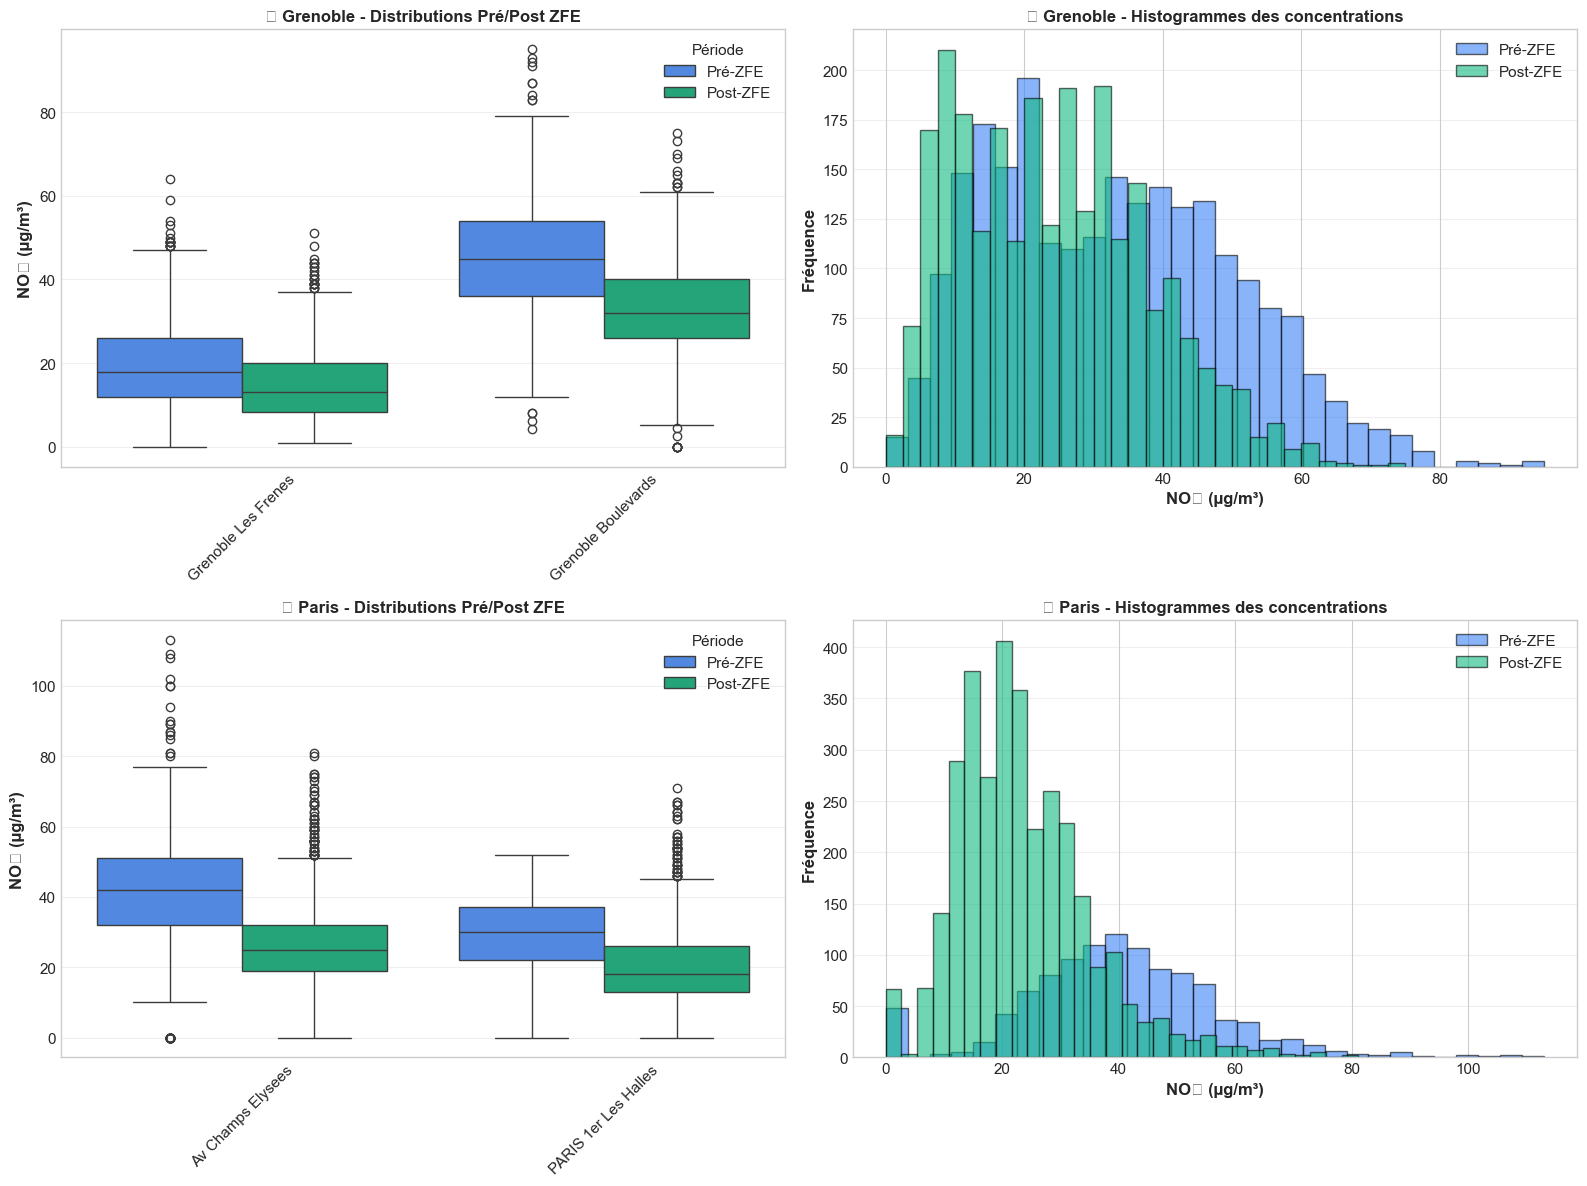

In [141]:
# ============================================================================
# 4. DISTRIBUTIONS ET BOXPLOTS
# ============================================================================

print("\n" + "=" * 80)
print("4️⃣ DISTRIBUTIONS DES CONCENTRATIONS")
print("=" * 80)

fig, axes = plt.subplots(2, 2, figsize=(16, 12))

# Données pour plotting
for idx, (df, zfe_date, ville) in enumerate([(grenoble_daily, grenoble_zfe_start, 'Grenoble'),
                                               (paris_daily, paris_zfe_start, 'Paris')]):
    # Exclure COVID
    covid_mask = (df['date'] >= '2020-03-01') & (df['date'] <= '2021-06-01')
    df_clean = df[~covid_mask].copy()
    df_clean['period'] = df_clean['date'].apply(lambda x: 'Pré-ZFE' if x < zfe_date else 'Post-ZFE')
    
    # Boxplot
    ax1 = axes[idx, 0]
    sns.boxplot(data=df_clean, x='station_name', y='no2_ug_m3', hue='period', ax=ax1, palette=['#3b82f6', '#10b981'])
    ax1.set_title(f'📦 {ville} - Distributions Pré/Post ZFE', fontsize=12, fontweight='bold')
    ax1.set_xlabel('')
    ax1.set_ylabel('NO₂ (µg/m³)', fontweight='bold')
    ax1.tick_params(axis='x', rotation=45)
    ax1.legend(title='Période')
    ax1.grid(True, alpha=0.3, axis='y')
    
    # Histogramme
    ax2 = axes[idx, 1]
    for period, color in [('Pré-ZFE', '#3b82f6'), ('Post-ZFE', '#10b981')]:
        data = df_clean[df_clean['period'] == period]['no2_ug_m3']
        ax2.hist(data, bins=30, alpha=0.6, label=period, color=color, edgecolor='black')
    ax2.set_title(f'📊 {ville} - Histogrammes des concentrations', fontsize=12, fontweight='bold')
    ax2.set_xlabel('NO₂ (µg/m³)', fontweight='bold')
    ax2.set_ylabel('Fréquence', fontweight='bold')
    ax2.legend()
    ax2.grid(True, alpha=0.3, axis='y')

plt.tight_layout()
plt.savefig(DATA / 'stats_desc_distributions.png', dpi=300, bbox_inches='tight')
print("✅ Graphique sauvegardé : stats_desc_distributions.png")
plt.show()

Cette première figure détaille la saisonnalité sur le cas de Grenoble, en montrant la structuration intra-annuelle des concentrations (pics hivernaux vs niveaux estivaux plus faibles). Elle documente un mécanisme clé d’interprétation : une comparaison pré/post non contrôlée peut capter un effet de composition saisonnière. Dans la suite (SCM), ce constat justifie l’attention portée au calendrier d’entrée en vigueur et au traitement de la saisonnalité (agrégations cohérentes, covariables, fenêtres temporelles comparables).

Cette seconde figure présente les profils mensuels moyens (cycle annuel) et quantifie la dynamique saisonnière de manière lisible. Elle sert à vérifier que les stations partagent un cycle comparable (condition favorable au contrôle synthétique) et à identifier d’éventuels mois atypiques. Ce profil est aussi utile pour motiver le choix d’indicateurs « queue haute » (p90/p95) si certains mois concentrent les épisodes.


5️⃣ ANALYSE SAISONNIÈRE
✅ Décomposition Grenoble sauvegardée


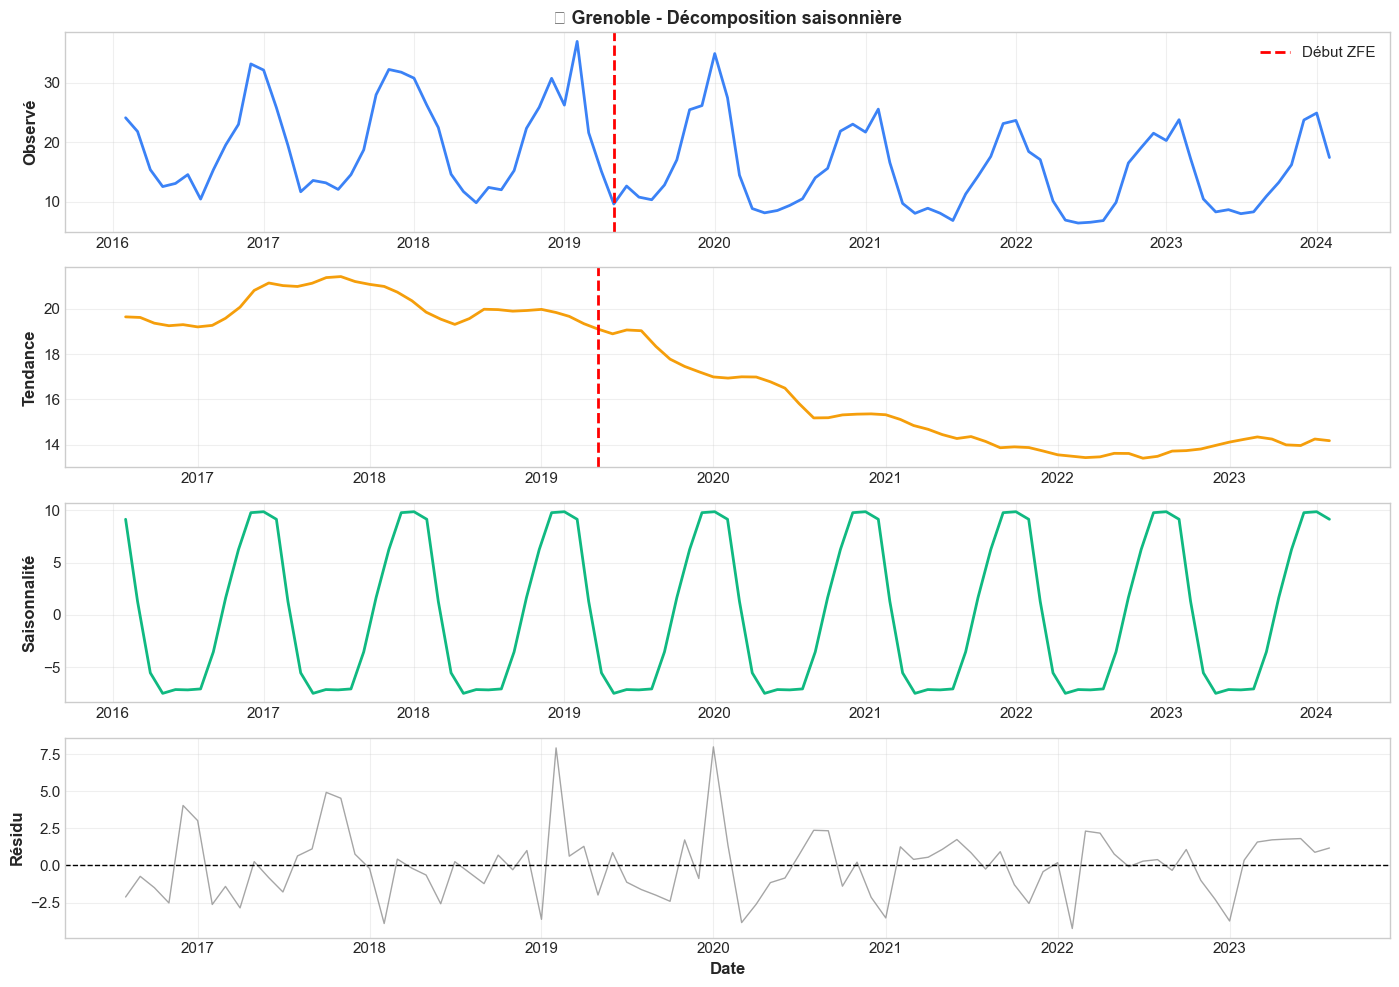

✅ Profils mensuels sauvegardés


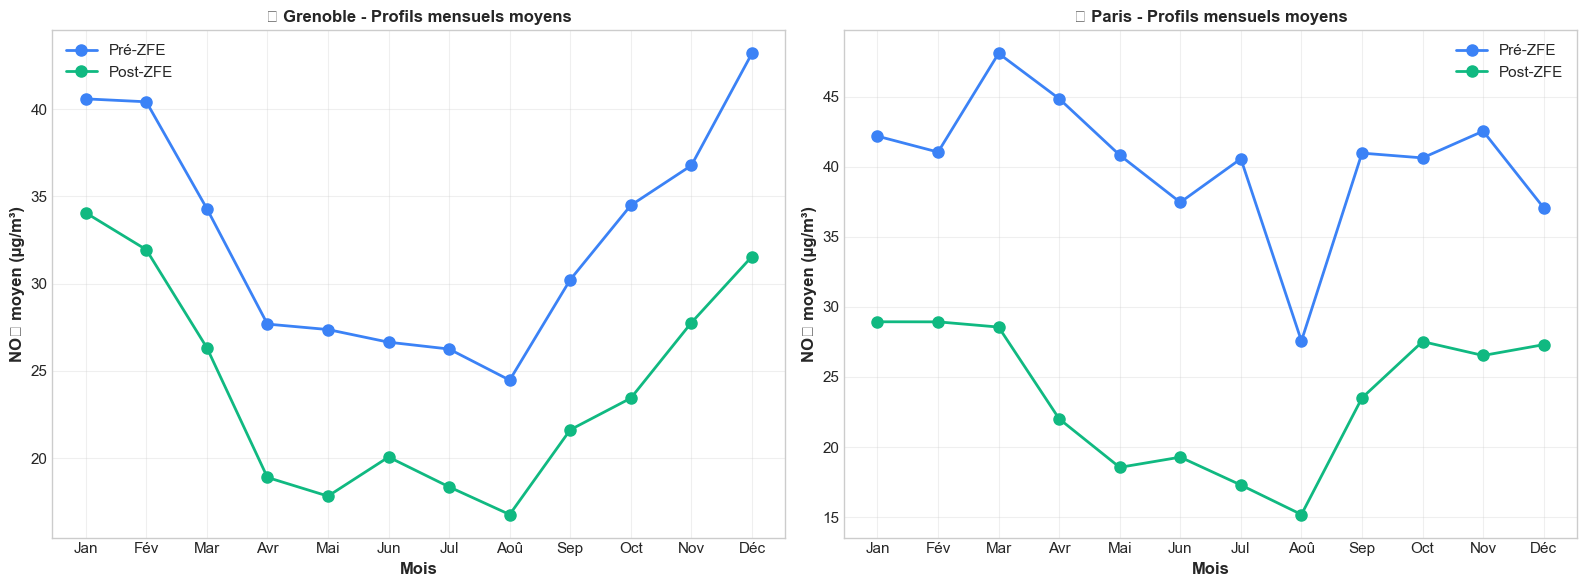

In [142]:
# ============================================================================
# 5. ANALYSE SAISONNIÈRE
# ============================================================================

print("\n" + "=" * 80)
print("5️⃣ ANALYSE SAISONNIÈRE")
print("=" * 80)

def plot_seasonal_patterns(df, zfe_date, ville, station_id):
    """Analyser et tracer les patterns saisonniers"""
    station_data = df[df['station_id'] == station_id].copy()
    station_data = station_data.set_index('date')['no2_ug_m3'].resample('MS').mean()
    
    # Décomposition saisonnière
    if len(station_data) >= 24:  # Minimum 2 ans
        decomposition = seasonal_decompose(station_data, model='additive', period=12)
        
        fig, axes = plt.subplots(4, 1, figsize=(14, 10))
        
        # Série originale
        axes[0].plot(station_data.index, station_data.values, linewidth=2, color='#3b82f6')
        axes[0].axvline(zfe_date, color='red', linestyle='--', linewidth=2, label='Début ZFE')
        axes[0].set_ylabel('Observé', fontweight='bold')
        axes[0].set_title(f'🍂 {ville} - Décomposition saisonnière', fontsize=13, fontweight='bold')
        axes[0].legend()
        axes[0].grid(True, alpha=0.3)
        
        # Tendance
        axes[1].plot(decomposition.trend.index, decomposition.trend.values, linewidth=2, color='#f59e0b')
        axes[1].axvline(zfe_date, color='red', linestyle='--', linewidth=2)
        axes[1].set_ylabel('Tendance', fontweight='bold')
        axes[1].grid(True, alpha=0.3)
        
        # Saisonnalité
        axes[2].plot(decomposition.seasonal.index, decomposition.seasonal.values, linewidth=2, color='#10b981')
        axes[2].set_ylabel('Saisonnalité', fontweight='bold')
        axes[2].grid(True, alpha=0.3)
        
        # Résidu
        axes[3].plot(decomposition.resid.index, decomposition.resid.values, linewidth=1, color='gray', alpha=0.7)
        axes[3].axhline(0, color='black', linestyle='--', linewidth=1)
        axes[3].set_ylabel('Résidu', fontweight='bold')
        axes[3].set_xlabel('Date', fontweight='bold')
        axes[3].grid(True, alpha=0.3)
        
        plt.tight_layout()
        return fig

# Grenoble Les Frênes
fig_grenoble = plot_seasonal_patterns(grenoble_daily, grenoble_zfe_start, 'Grenoble', 
                                     grenoble_daily['station_id'].iloc[0])
if fig_grenoble:
    fig_grenoble.savefig(DATA / 'stats_desc_saisonnalite_grenoble.png', dpi=300, bbox_inches='tight')
    print("✅ Décomposition Grenoble sauvegardée")
    plt.show()

# Profils mensuels moyens
fig, axes = plt.subplots(1, 2, figsize=(16, 6))

for idx, (df, zfe_date, ville) in enumerate([(grenoble_daily, grenoble_zfe_start, 'Grenoble'),
                                               (paris_daily, paris_zfe_start, 'Paris')]):
    covid_mask = (df['date'] >= '2020-03-01') & (df['date'] <= '2021-06-01')
    df_clean = df[~covid_mask].copy()
    df_clean['month'] = df_clean['date'].dt.month
    df_clean['period'] = df_clean['date'].apply(lambda x: 'Pré-ZFE' if x < zfe_date else 'Post-ZFE')
    
    monthly_avg = df_clean.groupby(['month', 'period'])['no2_ug_m3'].mean().reset_index()
    
    ax = axes[idx]
    for period, color in [('Pré-ZFE', '#3b82f6'), ('Post-ZFE', '#10b981')]:
        data = monthly_avg[monthly_avg['period'] == period]
        ax.plot(data['month'], data['no2_ug_m3'], marker='o', linewidth=2, 
               markersize=8, label=period, color=color)
    
    ax.set_title(f'📅 {ville} - Profils mensuels moyens', fontsize=12, fontweight='bold')
    ax.set_xlabel('Mois', fontweight='bold')
    ax.set_ylabel('NO₂ moyen (µg/m³)', fontweight='bold')
    ax.set_xticks(range(1, 13))
    ax.set_xticklabels(['Jan', 'Fév', 'Mar', 'Avr', 'Mai', 'Jun', 
                       'Jul', 'Aoû', 'Sep', 'Oct', 'Nov', 'Déc'])
    ax.legend()
    ax.grid(True, alpha=0.3)

plt.tight_layout()
plt.savefig(DATA / 'stats_desc_profils_mensuels.png', dpi=300, bbox_inches='tight')
print("✅ Profils mensuels sauvegardés")
plt.show()


Cette figure compare l’évolution des donneurs (et/ou leurs niveaux) à ceux de la(les) station(s) traitée(s), afin d’évaluer la comparabilité descriptive. Elle permet de vérifier si les donneurs capturent la même dynamique (tendance + saisonnalité) en période pré-traitement, ce qui est un prérequis essentiel pour produire un contrefactuel crédible. Une divergence précoce signalerait un risque de mauvaise spécification du pool de contrôle.


6️⃣ COMPARAISON STATIONS TRAITÉES VS DONNEUSES
✅ Comparaison donneurs sauvegardée


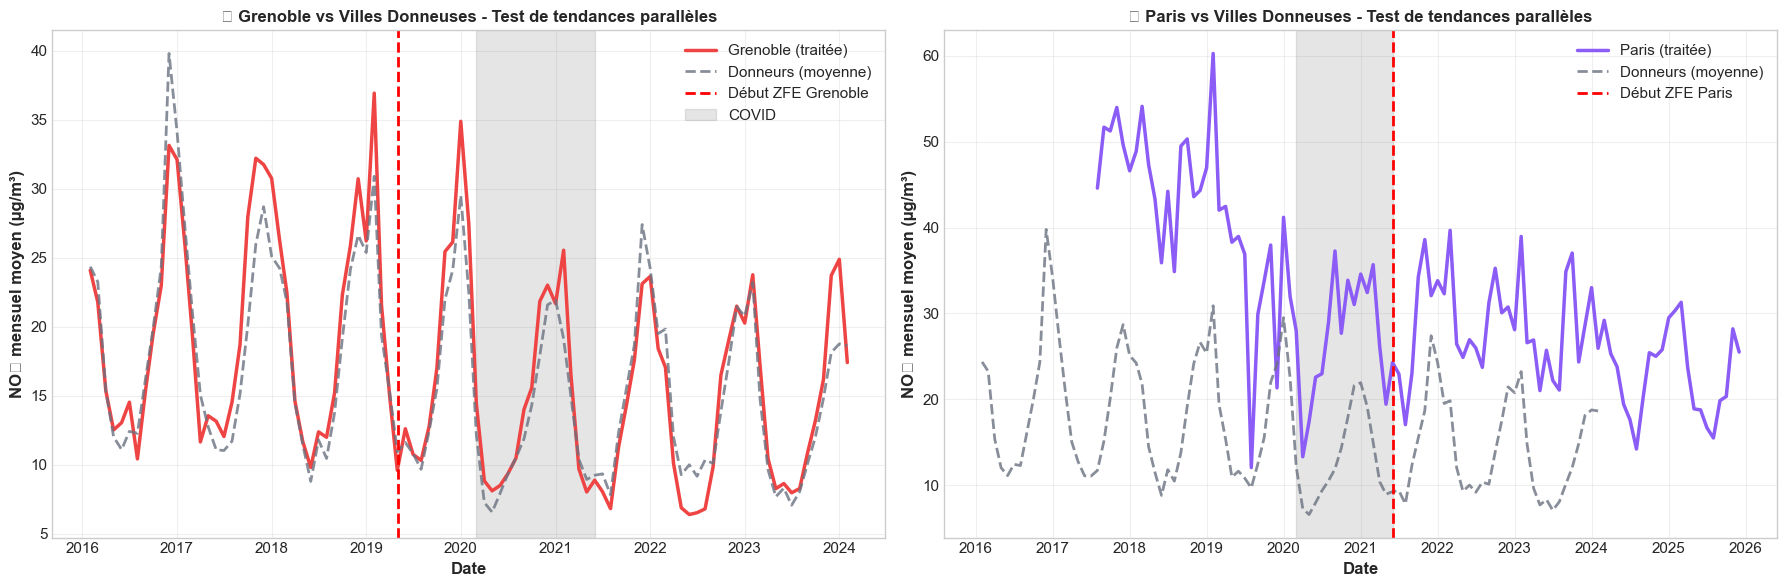

In [143]:
# ============================================================================
# 6. COMPARAISON AVEC LES DONNEURS (TENDANCES PARALLÈLES)
# ============================================================================

print("\n" + "=" * 80)
print("6️⃣ COMPARAISON STATIONS TRAITÉES VS DONNEUSES")
print("=" * 80)

# Moyenne mensuelle tous les donneurs
donors_monthly = donors_daily.set_index('date')['no2_ug_m3'].resample('MS').mean()

# Comparaison Grenoble
grenoble_station = grenoble_daily['station_id'].iloc[0]
grenoble_ts = grenoble_daily[grenoble_daily['station_id'] == grenoble_station].set_index('date')['no2_ug_m3'].resample('MS').mean()

fig, axes = plt.subplots(1, 2, figsize=(18, 6))

# Grenoble vs Donneurs
ax1 = axes[0]
ax1.plot(grenoble_ts.index, grenoble_ts.values, linewidth=2.5, label='Grenoble (traitée)', color='#ef4444')
ax1.plot(donors_monthly.index, donors_monthly.values, linewidth=2, label='Donneurs (moyenne)', 
        color='#6b7280', linestyle='--', alpha=0.8)
ax1.axvline(grenoble_zfe_start, color='red', linestyle='--', linewidth=2, label='Début ZFE Grenoble')
ax1.axvspan(pd.Timestamp('2020-03-01'), pd.Timestamp('2021-06-01'), alpha=0.2, color='gray', label='COVID')
ax1.set_title('🔍 Grenoble vs Villes Donneuses - Test de tendances parallèles', 
             fontsize=12, fontweight='bold')
ax1.set_xlabel('Date', fontweight='bold')
ax1.set_ylabel('NO₂ mensuel moyen (µg/m³)', fontweight='bold')
ax1.legend()
ax1.grid(True, alpha=0.3)

# Paris vs Donneurs
paris_station = paris_daily['station_id'].iloc[0]
paris_ts = paris_daily[paris_daily['station_id'] == paris_station].set_index('date')['no2_ug_m3'].resample('MS').mean()

ax2 = axes[1]
ax2.plot(paris_ts.index, paris_ts.values, linewidth=2.5, label='Paris (traitée)', color='#8b5cf6')
ax2.plot(donors_monthly.index, donors_monthly.values, linewidth=2, label='Donneurs (moyenne)', 
        color='#6b7280', linestyle='--', alpha=0.8)
ax2.axvline(paris_zfe_start, color='red', linestyle='--', linewidth=2, label='Début ZFE Paris')
ax2.axvspan(pd.Timestamp('2020-03-01'), pd.Timestamp('2021-06-01'), alpha=0.2, color='gray')
ax2.set_title('🔍 Paris vs Villes Donneuses - Test de tendances parallèles', 
             fontsize=12, fontweight='bold')
ax2.set_xlabel('Date', fontweight='bold')
ax2.set_ylabel('NO₂ mensuel moyen (µg/m³)', fontweight='bold')
ax2.legend()
ax2.grid(True, alpha=0.3)

plt.tight_layout()
plt.savefig(DATA / 'stats_desc_comparaison_donneurs.png', dpi=300, bbox_inches='tight')
print("✅ Comparaison donneurs sauvegardée")
plt.show()

### 3.2 Exposition sanitaire (seuils OMS)


**Rappel Théorique :**

Au-delà des niveaux moyens de NO₂, l’analyse porte sur la queue haute des distributions (par exemple percentiles élevés ou indicateurs d’épisodes), afin de caractériser les concentrations les plus élevées et leur évolution dans le temps. Cette approche est motivée par le fait que les impacts sanitaires du NO₂ sont souvent non linéaires et fortement associés aux épisodes de pollution aiguë, plutôt qu’au seul niveau moyen annuel. Par ailleurs, les politiques ciblant le trafic routier, telles que les Zones à Faibles Émissions, sont susceptibles d’agir prioritairement sur ces épisodes, en réduisant les émissions lors des périodes de forte congestion ou de conditions défavorables à la dispersion. L’étude de la queue haute permet ainsi de distinguer une éventuelle réduction des pics de pollution d’une simple évolution du niveau de fond, et d’apporter un éclairage complémentaire essentiel à l’évaluation de l’efficacité environnementale de la ZFE.


Cette première figure synthétise des indicateurs réglementaires et d’exposition (conformité, dépassements) par année et par groupe, avec repères temporels (lignes verticales) correspondant aux dates d’entrée en vigueur des ZFE. Elle met en perspective les résultats avec les seuils de référence : la limite UE annuelle de NO₂ est de 40 µg/m³ (directive air ambiant), tandis que la valeur guide OMS 2021 pour l’annuel est nettement plus stricte à 10 µg/m³. Cette double lecture (réglementaire vs sanitaire) permet d’interpréter une amélioration même lorsque la conformité UE est déjà acquise, mais que l’exposition sanitaire reste élevée.

Cette seconde figure porte sur la « queue haute » et l’intensité des épisodes (ex. P90/P95, top 10% jours) et présente les séries sous forme d’indice base 100 sur la première année disponible afin de comparer les dynamiques relatives entre groupes. La normalisation met l’accent sur les variations (baisse/hausse des épisodes) plutôt que sur les niveaux absolus, ce qui est particulièrement pertinent si l’objectif est d’évaluer si la ZFE agit davantage sur les pics que sur le niveau de fond. Les lignes verticales situent temporellement l’entrée en vigueur des ZFE pour une lecture descriptive pré/post.


7️⃣ INDICATEURS NO₂ — CONFORMITÉ UE + EXPOSITION (SEUILS & PICS) + FIGURES SYNTHÉTIQUES
ℹ️ Stratification possible via donors_meta['station_influence'] → station_influence
✅ CSV sauvegardé : no2_indicateurs_station_annee_enrichis.csv


group  year  n_stations  mean_annual_mean  mean_top10  mean_p90  \
0  Donneuses  2016          10             19.09       42.70     33.71   
1  Donneuses  2017          10             19.44       44.30     36.49   
2  Donneuses  2018          10             17.50       36.76     30.79   
3  Donneuses  2019          10             17.23       36.85     31.06   
4  Donneuses  2020          10             14.26       34.90     27.88   
5  Donneuses  2021          10             14.53       31.91     25.36   
6  Donneuses  2022          10             14.79       30.43     25.20   
7  Donneuses  2023          10             12.82       29.52     23.33   
8  Donneuses  2024          10             18.47       30.48     27.82   

   mean_p95  share_stations_above_40  mean_pct_days_gt_30  mean_pct_days_gt_40  
0     41.06                      0.0                18.01                 7.65  
1     42.10                      0.0                20.89                 9.72  
2     35.49                      0.0                14.53                 4.54  
3     35.60                      0.0                13.72                 5.01  
4     33.73                      0.0                 9.98                 3.26  
5     30.26                      0.0                 7.44                 1.92  
6     29.22                      0.0                 7.03                 1.82  
7     28.38                      0.0                 5.73                 1.67  
8     29.33                      0.0                10.86                 4.00

✅ CSV sauvegardé : no2_indicateurs_resume_groupes_enrichis.csv


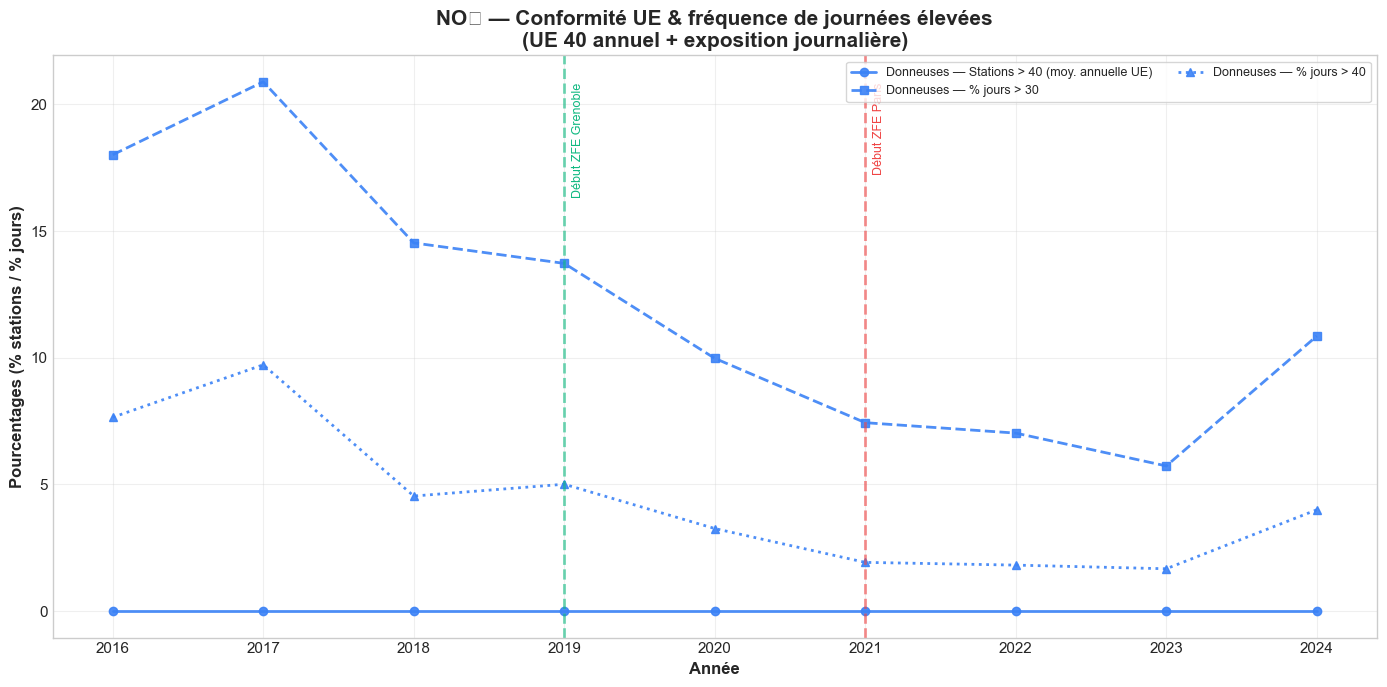

✅ Figure sauvegardée : no2_synth_1_conformite_depassements.png


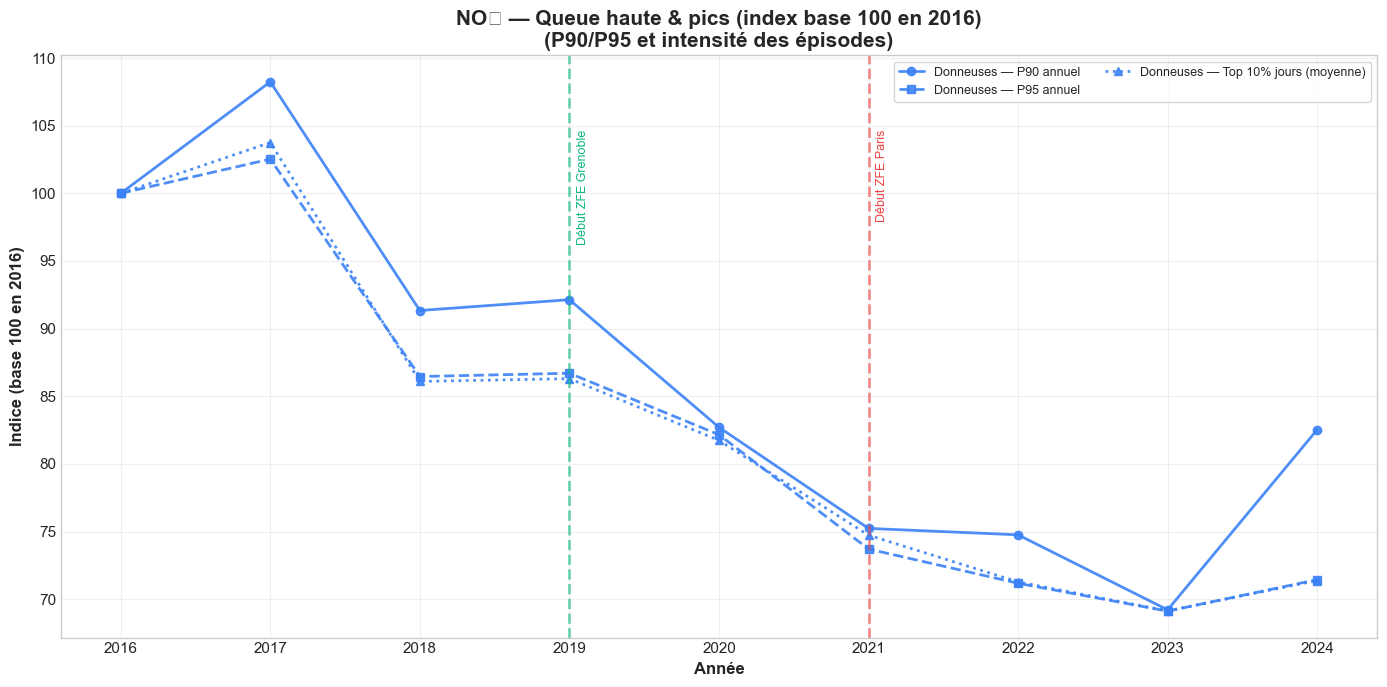

✅ Figure sauvegardée : no2_synth_2_queue_haute_pics_norm_base100.png
✅ Section 7 terminée : indicateurs + CSV + 2 figures synthétiques (avec lignes ZFE + normalisation).


In [144]:
# ============================================================================
# 7. INDICATEURS RÉGLEMENTAIRES & EXPOSITION (NO₂) — VERSION AMÉLIORÉE (ROBUSTE)
#   - 2 FIGURES SYNTHÉTIQUES UNIQUEMENT (pas de figure 3)
#   - LIGNES VERTICALES : dates de début ZFE (Paris + Grenoble)
#   - NORMALISATION (base 100) SUR LA FIGURE 2 (queue haute & pics)
# ============================================================================

print("\n" + "=" * 80)
print("7️⃣ INDICATEURS NO₂ — CONFORMITÉ UE + EXPOSITION (SEUILS & PICS) + FIGURES SYNTHÉTIQUES")
print("=" * 80)



# ----------------------------
# 1) Préparer un dataset commun
# ----------------------------

def prep(df, label):
    df = df.copy()
    df["date"] = pd.to_datetime(df["date"])
    df["group"] = label
    df["year"] = df["date"].dt.year

    needed = {"station_id", "station_name", "no2_ug_m3", "date", "year", "group"}
    missing = needed - set(df.columns)
    if missing:
        raise ValueError(f"Colonnes manquantes dans {label}: {missing}")
    return df

donors = prep(donors_daily, "Donneuses")
treated_grenoble = prep(grenoble_daily, "Traitée - Grenoble")
treated_paris = prep(paris_daily, "Traitée - Paris")

all_no2 = pd.concat([donors, treated_grenoble, treated_paris], ignore_index=True)

# --------------------------------------------------------
# 2) Enrichir avec le type de station si disponible (option)
# --------------------------------------------------------

all_no2["station_influence"] = np.nan

possible_cols = ["station_influence", "influence", "type_station", "station_type", "typologie"]
meta_col = next((c for c in possible_cols if c in donors_meta.columns), None)

if meta_col is not None:
    meta_tmp = donors_meta[["station_id", meta_col]].drop_duplicates().rename(columns={meta_col: "station_influence"})
    all_no2 = all_no2.merge(meta_tmp, on="station_id", how="left", suffixes=("", "_meta"))
    if "station_influence_meta" in all_no2.columns:
        all_no2["station_influence"] = all_no2["station_influence"].fillna(all_no2["station_influence_meta"])
        all_no2 = all_no2.drop(columns=["station_influence_meta"])
    print(f"ℹ️ Stratification possible via donors_meta['{meta_col}'] → station_influence")
else:
    print("ℹ️ Aucune colonne d'influence trouvée dans donors_meta : stratification ignorée.")

# ----------------------------
# 3) Paramètres d'indicateurs
# ----------------------------

UE_ANNUAL_LIMIT = 40.0
THRESHOLDS_DAILY = [30.0, 40.0]
PCTS = [90, 95]
TOP_SHARE = 0.10

colors = {
    "Donneuses": "#3b82f6",
    "Traitée - Paris": "#ef4444",
    "Traitée - Grenoble": "#10b981"
}

# ----------------------------
# 4) Calcul indicateurs station-année
# ----------------------------

def top_share_mean(x, share=0.10):
    x = pd.Series(x).dropna().sort_values()
    if len(x) == 0:
        return np.nan
    k = max(1, int(np.ceil(len(x) * share)))
    return x.iloc[-k:].mean()

def compute_station_year_metrics(df):
    gcols = ["group", "station_id", "station_name", "year"]
    gcols_with_inf = gcols + ["station_influence"] if "station_influence" in df.columns else gcols

    out = df.groupby(gcols_with_inf).agg(
        n_days=("no2_ug_m3", "count"),
        annual_mean=("no2_ug_m3", "mean"),
        annual_median=("no2_ug_m3", "median"),
        top10_mean=("no2_ug_m3", lambda x: top_share_mean(x, TOP_SHARE))
    ).reset_index()

    for p in PCTS:
        out[f"annual_p{p}"] = (
            df.groupby(gcols_with_inf)["no2_ug_m3"]
              .apply(lambda s: np.nanpercentile(s.dropna(), p) if s.dropna().shape[0] else np.nan)
              .values
        )

    for thr in THRESHOLDS_DAILY:
        days = (
            df.assign(flag=(df["no2_ug_m3"] > thr))
              .groupby(gcols_with_inf)["flag"]
              .sum()
              .reset_index(drop=True)
        )
        out[f"days_gt_{int(thr)}"] = days.values
        out[f"pct_days_gt_{int(thr)}"] = 100 * out[f"days_gt_{int(thr)}"] / out["n_days"]

    out["above_ue_annual_40"] = out["annual_mean"] > UE_ANNUAL_LIMIT
    return out

metrics_station_year = compute_station_year_metrics(all_no2)

metrics_station_year.to_csv(DATA / "no2_indicateurs_station_annee_enrichis.csv", index=False)
print("✅ CSV sauvegardé : no2_indicateurs_station_annee_enrichis.csv")

# ----------------------------
# 5) Résumé agrégé par groupe / année
# ----------------------------

summary_group_year = metrics_station_year.groupby(["group", "year"]).agg(
    n_stations=("station_id", "nunique"),
    mean_annual_mean=("annual_mean", "mean"),
    mean_top10=("top10_mean", "mean"),
    mean_p90=("annual_p90", "mean"),
    mean_p95=("annual_p95", "mean"),
    share_stations_above_40=("above_ue_annual_40", "mean"),
    mean_pct_days_gt_30=("pct_days_gt_30", "mean"),
    mean_pct_days_gt_40=("pct_days_gt_40", "mean"),
).reset_index()

summary_group_year["share_stations_above_40"] *= 100

display(summary_group_year.round(2))

summary_group_year.to_csv(DATA / "no2_indicateurs_resume_groupes_enrichis.csv", index=False)
print("✅ CSV sauvegardé : no2_indicateurs_resume_groupes_enrichis.csv")

# ----------------------------
# 6) Dates ZFE (pour lignes verticales)
# ----------------------------
# On récupère depuis zfe_meta si dispo (sinon on laisse vide)

def get_zfe_start(zfe_id):
    if "zfe_meta" not in globals():
        return None
    if "publisher_zfe_id" not in zfe_meta.columns or "first_date_debut" not in zfe_meta.columns:
        return None
    s = zfe_meta.loc[zfe_meta["publisher_zfe_id"] == zfe_id, "first_date_debut"]
    if s.empty:
        return None
    return pd.to_datetime(s.iloc[0])

grenoble_zfe_date = get_zfe_start("GRENOBLE")
paris_zfe_date = get_zfe_start("PARIS")

def year_from_date(dt):
    return int(dt.year) if dt is not None else None

grenoble_zfe_year = year_from_date(grenoble_zfe_date)
paris_zfe_year = year_from_date(paris_zfe_date)

# ----------------------------
# 7) Fonctions de figures synthétiques (avec lignes verticales)
# ----------------------------

def add_zfe_vlines(ax):
    # lignes verticales sur les années (plot annual)
    if grenoble_zfe_year is not None:
        ax.axvline(grenoble_zfe_year, linestyle="--", linewidth=2, alpha=0.6, color=colors.get("Traitée - Grenoble", "gray"))
        ax.text(grenoble_zfe_year + 0.05, ax.get_ylim()[1]*0.95, "Début ZFE Grenoble", rotation=90,
                va="top", fontsize=9, color=colors.get("Traitée - Grenoble", "gray"))
    if paris_zfe_year is not None:
        ax.axvline(paris_zfe_year, linestyle="--", linewidth=2, alpha=0.6, color=colors.get("Traitée - Paris", "gray"))
        ax.text(paris_zfe_year + 0.05, ax.get_ylim()[1]*0.95, "Début ZFE Paris", rotation=90,
                va="top", fontsize=9, color=colors.get("Traitée - Paris", "gray"))

def plot_synth(df, indicators, title, ylabel, filename, normalize_base_year=None):
    """
    df: summary_group_year
    indicators: dict col -> dict(label, linestyle, marker)
    normalize_base_year: int or None
      - if provided, each group & indicator series is indexed to 100 at that year (if value exists & non-null)
    """
    fig, ax = plt.subplots(figsize=(14, 7))

    for grp in df["group"].unique():
        d = df[df["group"] == grp].sort_values("year").copy()

        for col, style in indicators.items():
            y = d[col].astype(float).values

            # Normalisation base 100 (par groupe & indicateur)
            if normalize_base_year is not None:
                base_row = d[d["year"] == normalize_base_year]
                if not base_row.empty and pd.notna(base_row[col].iloc[0]) and base_row[col].iloc[0] != 0:
                    base = float(base_row[col].iloc[0])
                    y = (y / base) * 100.0
                else:
                    # si pas de base, on ne normalise pas (évite division par 0/NaN)
                    y = y

            ax.plot(
                d["year"],
                y,
                color=colors.get(grp, "gray"),
                linestyle=style["linestyle"],
                marker=style["marker"],
                linewidth=2,
                alpha=0.9,
                label=f"{grp} — {style['label']}"
            )

    ax.set_title(title, fontsize=15, fontweight="bold")
    ax.set_xlabel("Année", fontweight="bold")
    ax.set_ylabel(ylabel, fontweight="bold")
    ax.grid(True, alpha=0.3)

    # lignes ZFE
    add_zfe_vlines(ax)

    ax.legend(loc="upper right", fontsize=9, ncol=2, frameon=True)

    plt.tight_layout()
    plt.savefig(DATA / filename, dpi=300, bbox_inches="tight")
    plt.show()
    print(f"✅ Figure sauvegardée : {filename}")

# ----------------------------
# 8) FIGURE 1 — Conformité & dépassements (pas de normalisation)
# ----------------------------

indicators_1 = {
    "share_stations_above_40": {"label": "Stations > 40 (moy. annuelle UE)", "linestyle": "-",  "marker": "o"},
    "mean_pct_days_gt_30":     {"label": "% jours > 30",                    "linestyle": "--", "marker": "s"},
    "mean_pct_days_gt_40":     {"label": "% jours > 40",                    "linestyle": ":",  "marker": "^"},
}

plot_synth(
    summary_group_year,
    indicators_1,
    title="NO₂ — Conformité UE & fréquence de journées élevées\n(UE 40 annuel + exposition journalière)",
    ylabel="Pourcentages (% stations / % jours)",
    filename="no2_synth_1_conformite_depassements.png",
    normalize_base_year=None
)

# ----------------------------
# 9) FIGURE 2 — Queue haute & pics (NORMALISÉE base 100)
# ----------------------------
# Choix de l'année de base : première année dispo dans le résumé
base_year = int(summary_group_year["year"].min())

indicators_2 = {
    "mean_p90":   {"label": "P90 annuel",              "linestyle": "-",  "marker": "o"},
    "mean_p95":   {"label": "P95 annuel",              "linestyle": "--", "marker": "s"},
    "mean_top10": {"label": "Top 10% jours (moyenne)", "linestyle": ":",  "marker": "^"},
}

plot_synth(
    summary_group_year,
    indicators_2,
    title=f"NO₂ — Queue haute & pics (index base 100 en {base_year})\n(P90/P95 et intensité des épisodes)",
    ylabel=f"Indice (base 100 en {base_year})",
    filename="no2_synth_2_queue_haute_pics_norm_base100.png",
    normalize_base_year=base_year
)

print("✅ Section 7 terminée : indicateurs + CSV + 2 figures synthétiques (avec lignes ZFE + normalisation).")


**Rappel Théorique :**

L’analyse des concentrations de NO₂ est conduite en mobilisant à la fois les normes réglementaires européennes et les valeurs guides sanitaires de l’Organisation mondiale de la Santé. Les normes européennes, notamment la limite annuelle de 40 µg/m³, visent à encadrer la conformité réglementaire, tandis que les valeurs guides OMS, révisées en 2021, reposent sur l’état le plus récent des connaissances épidémiologiques et fixent des seuils plus stricts (10 µg/m³ en moyenne annuelle et 25 µg/m³ en moyenne sur 24 heures). De nombreuses études montrent que des effets sanitaires significatifs peuvent survenir en-deçà des seuils réglementaires européens, ce qui justifie l’usage d’indicateurs OMS pour évaluer l’exposition réelle de la population. Dans le cadre de cette étude, le recours aux valeurs OMS permet ainsi d’apprécier les bénéfices potentiels d’une Zone à Faibles Émissions au-delà de la seule conformité réglementaire, en adoptant une perspective explicitement orientée vers la santé publique.


Cette première figure traduit les concentrations de NO₂ en lecture sanitaire, en les confrontant aux valeurs guides OMS 2021 : 10 µg/m³ (moyenne annuelle) et 25 µg/m³ (moyenne 24h). Elle fournit un cadrage santé publique complémentaire aux normes réglementaires, en montrant que l’exposition peut rester substantielle même en l’absence de dépassements UE. Ce cadrage est central pour interpréter la pertinence d’une politique type ZFE au-delà de la seule conformité.

Cette seconde figure compare explicitement une lecture « OMS » et une lecture « UE » (proxy) de l’exposition, afin de mettre en évidence l’écart entre un objectif sanitaire strict et une norme réglementaire plus permissive (limite UE annuelle 40 µg/m³). Elle permet d’argumenter qu’une baisse des concentrations peut être socialement et sanitairesement pertinente même lorsque la situation est déjà proche ou en-dessous du seuil UE, dès lors que les indicateurs OMS (annuel/journalier) restent élevés.

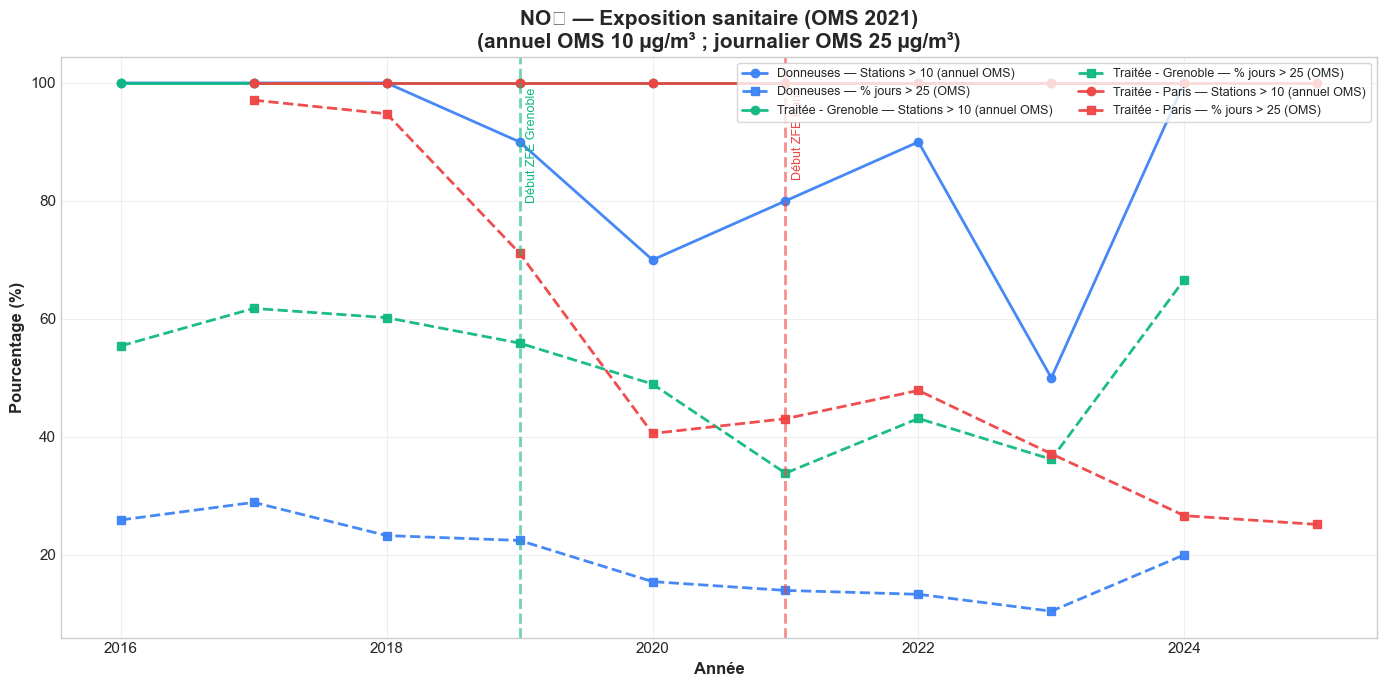

✅ Figure A sauvegardée : no2_oms_only_sanitaire.png


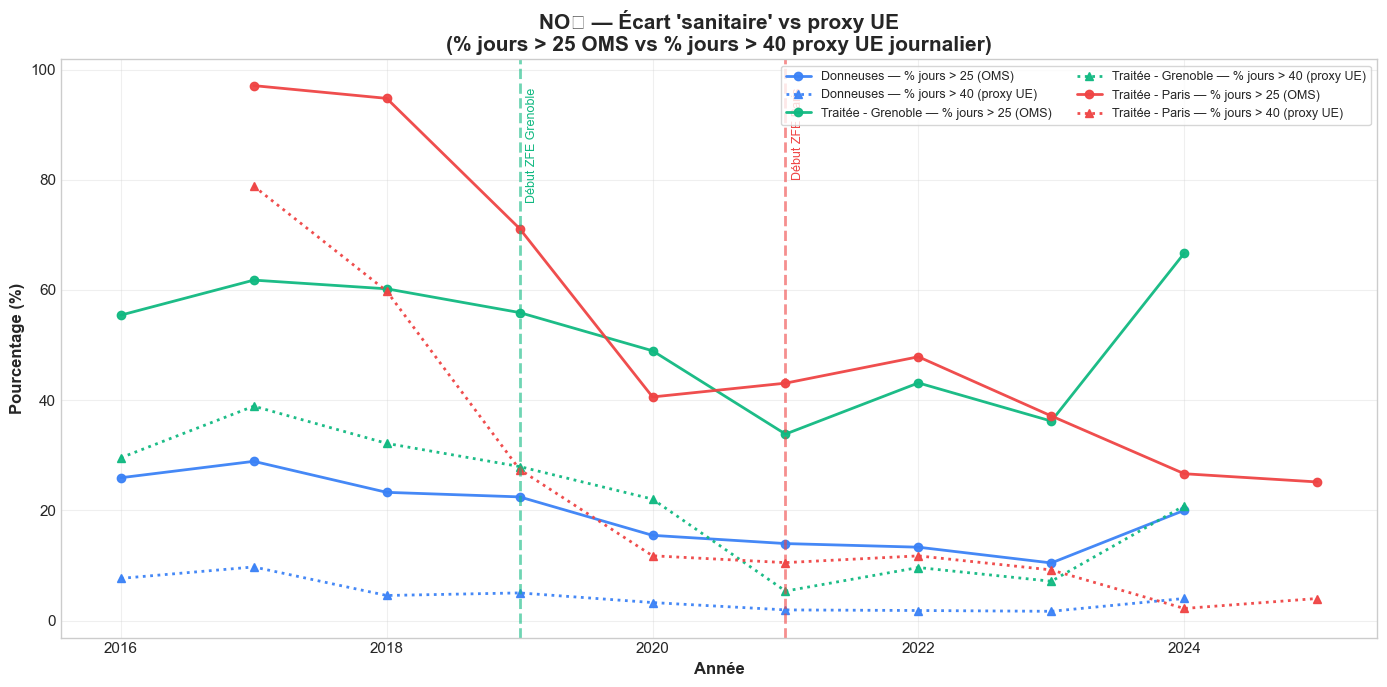

✅ Figure B sauvegardée : no2_oms_vs_ue_decharge.png
ℹ️ La figure 'no2_oms_vs_ue_frequences.png' (surchargée) est volontairement remplacée par ces 2 figures.


In [145]:
# ============================================================================
# Figure 7 bis
# 
# OMS 2021 — FIGURES DÉCHARGÉES (REMPLACE la figure surchargée "OMS vs UE")
#   Remplace: no2_oms_vs_ue_frequences.png (9 courbes) par 2 figures lisibles
#
#   Figure A : OMS uniquement
#     - % stations > 10 µg/m³ (annuel OMS)
#     - % jours > 25 µg/m³ (OMS)
#
#   Figure B : OMS vs proxy UE
#     - % jours > 25 µg/m³ (OMS)
#     - % jours > 40 µg/m³ (proxy UE journalier)
#
#   Pré-requis :
#     - oms_summary_group_year (calculée dans la section OMS)
#     - add_zfe_vlines(ax) (si dispo ; sinon fallback)
#     - DATA (Path)
# ============================================================================

import matplotlib.pyplot as plt

# ---------- Pré-requis / fallback ----------
if "oms_summary_group_year" not in globals():
    raise NameError("oms_summary_group_year introuvable. Exécute d'abord la section OMS (calculs).")

if "add_zfe_vlines" not in globals():
    def add_zfe_vlines(ax):
        return

if "colors" not in globals():
    colors = {
        "Donneuses": "#3b82f6",
        "Traitée - Paris": "#ef4444",
        "Traitée - Grenoble": "#10b981"
    }

df = oms_summary_group_year.copy().sort_values(["group", "year"])

# ----------------------------
# FIGURE A — OMS uniquement
# ----------------------------
fig, ax = plt.subplots(figsize=(14, 7))

for grp in df["group"].unique():
    d = df[df["group"] == grp].sort_values("year")

    ax.plot(
        d["year"], d["share_stations_above_oms_10"],
        color=colors.get(grp, "gray"),
        linestyle="-", marker="o", linewidth=2, alpha=0.95,
        label=f"{grp} — Stations > 10 (annuel OMS)"
    )

    ax.plot(
        d["year"], d["mean_pct_days_gt_25"],
        color=colors.get(grp, "gray"),
        linestyle="--", marker="s", linewidth=2, alpha=0.95,
        label=f"{grp} — % jours > 25 (OMS)"
    )

ax.set_title(
    "NO₂ — Exposition sanitaire (OMS 2021)\n"
    "(annuel OMS 10 µg/m³ ; journalier OMS 25 µg/m³)",
    fontsize=15, fontweight="bold"
)
ax.set_xlabel("Année", fontweight="bold")
ax.set_ylabel("Pourcentage (%)", fontweight="bold")
ax.grid(True, alpha=0.3)

add_zfe_vlines(ax)

ax.legend(loc="upper right", fontsize=9, ncol=2, frameon=True)

plt.tight_layout()
plt.savefig(DATA / "no2_oms_only_sanitaire.png", dpi=300, bbox_inches="tight")
plt.show()
print("✅ Figure A sauvegardée : no2_oms_only_sanitaire.png")


# ----------------------------
# FIGURE B — OMS vs proxy UE
# ----------------------------
fig, ax = plt.subplots(figsize=(14, 7))

for grp in df["group"].unique():
    d = df[df["group"] == grp].sort_values("year")

    ax.plot(
        d["year"], d["mean_pct_days_gt_25"],
        color=colors.get(grp, "gray"),
        linestyle="-", marker="o", linewidth=2, alpha=0.95,
        label=f"{grp} — % jours > 25 (OMS)"
    )

    ax.plot(
        d["year"], d["mean_pct_days_gt_40"],
        color=colors.get(grp, "gray"),
        linestyle=":", marker="^", linewidth=2, alpha=0.95,
        label=f"{grp} — % jours > 40 (proxy UE)"
    )

ax.set_title(
    "NO₂ — Écart 'sanitaire' vs proxy UE\n"
    "(% jours > 25 OMS vs % jours > 40 proxy UE journalier)",
    fontsize=15, fontweight="bold"
)
ax.set_xlabel("Année", fontweight="bold")
ax.set_ylabel("Pourcentage (%)", fontweight="bold")
ax.grid(True, alpha=0.3)

add_zfe_vlines(ax)

ax.legend(loc="upper right", fontsize=9, ncol=2, frameon=True)

plt.tight_layout()
plt.savefig(DATA / "no2_oms_vs_ue_decharge.png", dpi=300, bbox_inches="tight")
plt.show()
print("✅ Figure B sauvegardée : no2_oms_vs_ue_decharge.png")


# ----------------------------
# IMPORTANT : on ne sauvegarde plus la figure surchargée
# ----------------------------
print("ℹ️ La figure 'no2_oms_vs_ue_frequences.png' (surchargée) est volontairement remplacée par ces 2 figures.")


### 3.3 Hétérogénéité spatiale : trafic vs fond

#### 3.3.1 Explication théorique 
La distinction entre stations trafic et stations de fond urbain est essentielle pour l’analyse du NO₂, un polluant majoritairement émis par le transport routier en milieu urbain. Les stations trafic mesurent des concentrations influencées directement par les émissions locales des véhicules, souvent plus élevées et plus variables, tandis que les stations de fond reflètent un niveau d’exposition moyen intégrant la dispersion et le fond régional. Cette typologie, largement reconnue dans la littérature et par les organismes de référence tels que l’Agence européenne pour l’environnement et l’Organisation mondiale de la Santé, est particulièrement pertinente dans l’évaluation des Zones à Faibles Émissions. En effet, une réduction des émissions liée à la ZFE est attendue en priorité sur les stations trafic, tandis que les stations de fond permettent d’apprécier un éventuel bénéfice plus diffus à l’échelle urbaine et d’éviter des comparaisons structurellement biaisées dans l’analyse contrefactuelle.

#### 3.3.2 Résultats

Cette première figure compare l’exposition OMS (jours > 25 µg/m³ en moyenne 24h) entre stations de type trafic et stations de fond, en distinguant les profils d’exposition. Elle met généralement en évidence une exposition plus fréquente dans les stations trafic, cohérente avec l’origine majoritairement routière du NO₂. L’intérêt analytique est double : (i) valider la cohérence des métadonnées (trafic > fond), et (ii) évaluer si l’effet attendu d’une ZFE devrait d’abord se manifester sur les stations trafic, plus directement exposées.

Cette seconde figure porte sur les pics et la « charge » d’épisodes (indicateurs type p90/p95/top décile) en comparant trafic vs fond, souvent sous une forme normalisée (indice) facilitant la comparaison des dynamiques relatives. Elle permet de distinguer un effet concentré sur les épisodes (réduction de la queue haute) d’un effet plus uniforme sur le niveau de fond, ce qui éclaire le mécanisme attendu d’une restriction de trafic.

Ainsi, les stations trafic présentent des niveaux et une variabilité plus élevés que les stations de fond, ce qui suggère que l’exposition au NO₂ est fortement structurée par la proximité au trafic routier.


7️⃣ter — STRATIFICATION TRAFIC vs FOND
ℹ️ Typologie trouvée dans donors_meta['station_influence']
✅ CSV sauvegardé : no2_trafic_fond_station_annee.csv


group station_type  year  n_stations  mean_annual_mean  \
0            Donneuses         Fond  2016           8             15.07   
1            Donneuses         Fond  2017           8             15.84   
2            Donneuses         Fond  2018           8             14.35   
3            Donneuses         Fond  2019           8             14.11   
4            Donneuses         Fond  2020           8             11.60   
5            Donneuses         Fond  2021           8             12.06   
6            Donneuses         Fond  2022           8             12.19   
7            Donneuses         Fond  2023           8             10.18   
8            Donneuses         Fond  2024           8             16.72   
9            Donneuses       Trafic  2016           2             35.18   
10           Donneuses       Trafic  2017           2             33.83   
11           Donneuses       Trafic  2018           2             30.08   
12           Donneuses       Trafic  2019           2             29.73   
13           Donneuses       Trafic  2020           2             24.93   
14           Donneuses       Trafic  2021           2             24.43   
15           Donneuses       Trafic  2022           2             25.20   
16           Donneuses       Trafic  2023           2             23.37   
17           Donneuses       Trafic  2024           2             25.47   
18  Traitée - Grenoble      Inconnu  2016           2             30.83   
19  Traitée - Grenoble      Inconnu  2017           2             34.44   
20  Traitée - Grenoble      Inconnu  2018           2             31.47   
21  Traitée - Grenoble      Inconnu  2019           2             30.04   
22  Traitée - Grenoble      Inconnu  2020           2             26.97   
23  Traitée - Grenoble      Inconnu  2021           2             19.17   
24  Traitée - Grenoble      Inconnu  2022           2             23.07   
25  Traitée - Grenoble      Inconnu  2023           2             21.46   
26  Traitée - Grenoble      Inconnu  2024           2             30.57   
27     Traitée - Paris      Inconnu  2017           1             50.86   
28     Traitée - Paris      Inconnu  2018           1             45.26   
29     Traitée - Paris      Inconnu  2019           2             32.50   
30     Traitée - Paris      Inconnu  2020           2             23.90   
31     Traitée - Paris      Inconnu  2021           2             23.77   
32     Traitée - Paris      Inconnu  2022           2             26.88   
33     Traitée - Paris      Inconnu  2023           2             24.73   
34     Traitée - Paris      Inconnu  2024           2             20.21   
35     Traitée - Paris      Inconnu  2025           2             20.32   

    mean_p90  mean_p95  mean_top10  mean_pct_days_gt_25  mean_burden_25  
0      28.75     34.75       36.45                14.43          450.00  
1      32.74     38.29       40.67                18.68          719.25  
2      26.91     31.14       32.32                13.46          322.00  
3      26.95     31.38       32.60                13.49          356.75  
4      24.23     29.44       30.73                 9.03          254.00  
5      22.36     26.85       28.46                 7.34          175.62  
6      21.75     25.54       26.78                 5.81          108.00  
7      19.91     24.09       25.15                 4.43           86.12  
8      23.78     25.22       26.16                10.36           15.00  
9      53.55     66.28       67.67                71.85         3851.00  
10     51.50     57.30       58.81                69.73         3841.50  
11     46.30     52.90       54.51                62.49         2848.50  
12     47.50     52.47       53.82                58.24         2726.00  
13     42.50     50.90       51.57                41.19         1872.00  
14     37.35     43.90       45.69                40.48         1363.00  
15     39.00     43.95       45.05                43.29  

✅ CSV sauvegardé : no2_trafic_fond_resume.csv


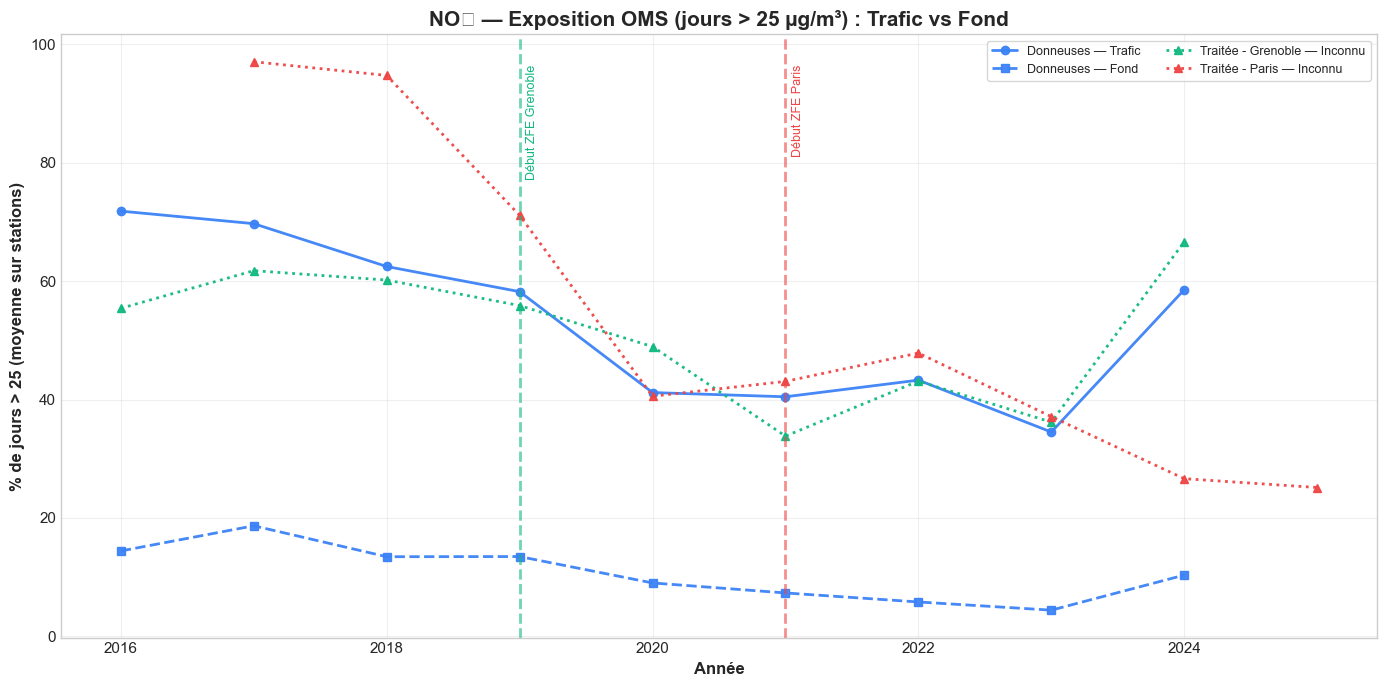

✅ Figure sauvegardée : no2_trafic_fond_oms_pctjours25.png


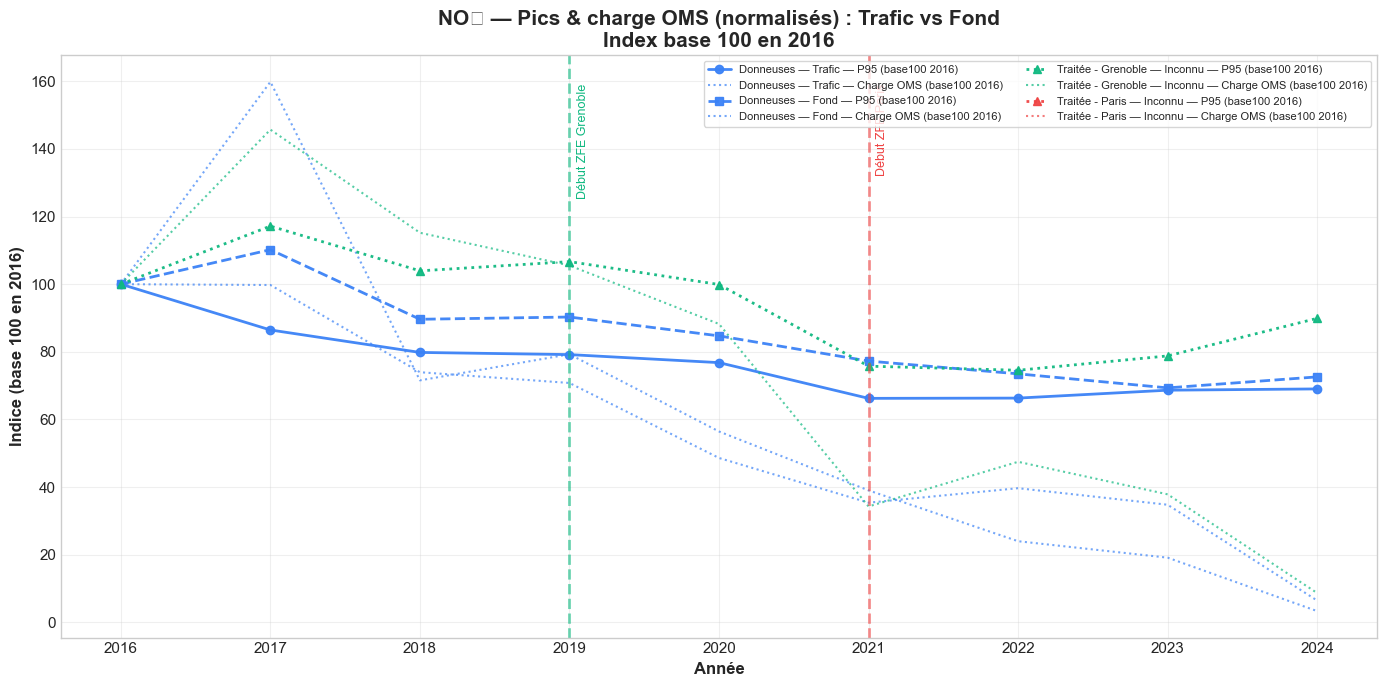

✅ Figure sauvegardée : no2_trafic_fond_pics_charge_norm.png
✅ Stratification trafic vs fond terminée.


In [ ]:
# ============================================================================
# 7ter — HÉTÉROGÉNÉITÉ SPATIALE : STRATIFICATION TRAFIC vs FOND
#   Objectif (descriptif):
#   - Comparer NO2 trafic vs fond sur:
#       * Niveau : moyenne annuelle
#       * Exposition OMS : % jours > 25, charge OMS (Σ max(NO2-25,0))
#       * Pics : P90/P95, Top10%
#   - Montrer si l’exposition résiduelle est concentrée sur les stations trafic.
# ============================================================================

print("\n" + "=" * 80)
print("7️⃣ter — STRATIFICATION TRAFIC vs FOND")
print("=" * 80)


# ----------------------------
# 0) Pré-requis / fallback
# ----------------------------
if "all_no2" not in globals():
    raise NameError("all_no2 introuvable. Exécute d'abord la section qui concatène donors + traitées.")
if "DATA" not in globals():
    raise NameError("DATA introuvable (Path).")

if "add_zfe_vlines" not in globals():
    def add_zfe_vlines(ax):
        return

# Couleurs groupe
if "colors" not in globals():
    colors = {
        "Donneuses": "#3b82f6",
        "Traitée - Paris": "#ef4444",
        "Traitée - Grenoble": "#10b981"
    }

# ----------------------------
# 1) Identifier la colonne de typologie (trafic/fond) et l’unifier
# ----------------------------
# On essaye de trouver une colonne dans donors_meta
station_type_col = None
if "donors_meta" in globals():
    for c in ["station_influence", "influence", "type_station", "station_type", "typologie"]:
        if c in donors_meta.columns:
            station_type_col = c
            break

# On fabrique une table station_id -> station_type
# Important: pour les stations traitées, il faut aussi une typologie.
# Si tu n'as la typologie que pour les donneuses, on aura NaN côté traitées.
# (On gère ça proprement: on affiche aussi "Inconnu".)
station_types = None
if station_type_col is not None:
    station_types = donors_meta[["station_id", station_type_col]].drop_duplicates().rename(
        columns={station_type_col: "station_type_raw"}
    )
    print(f"ℹ️ Typologie trouvée dans donors_meta['{station_type_col}']")
else:
    print("⚠️ Aucune colonne 'station_influence' (ou équivalent) trouvée dans donors_meta.")
    print("   -> Les graphiques afficheront 'Inconnu'. (Tu peux enrichir donors_meta pour les traitées aussi.)")
    station_types = pd.DataFrame(columns=["station_id", "station_type_raw"])

# Fonction de normalisation des libellés (trafic/fond)
def normalize_station_type(x):
    if pd.isna(x):
        return "Inconnu"
    s = str(x).strip().lower()

    # catégories fréquentes
    if "traf" in s or "traffic" in s or "rout" in s:
        return "Trafic"
    if "fond" in s or "background" in s or "urbain" in s or "suburb" in s:
        return "Fond"
    return "Autre"

station_types["station_type"] = station_types["station_type_raw"].apply(normalize_station_type)
station_types = station_types[["station_id", "station_type"]].drop_duplicates()

# ----------------------------
# 2) Construire le dataset daily avec station_type
# ----------------------------
df = all_no2.copy()
df["date"] = pd.to_datetime(df["date"])
df["year"] = df["date"].dt.year

df = df.merge(station_types, on="station_id", how="left")
df["station_type"] = df["station_type"].fillna("Inconnu")

# On garde surtout Trafic/Fond (et Inconnu si tu veux diagnostiquer)
# Si tu préfères exclure Inconnu:
# df = df[df["station_type"].isin(["Trafic", "Fond"])]

# ----------------------------
# 3) Calcul station-année (indicateurs cohérents UE/OMS/pics)
# ----------------------------
OMS_DAILY = 25.0

df["excess_25"] = (df["no2_ug_m3"] - OMS_DAILY).clip(lower=0)
df["flag_gt_25"] = df["no2_ug_m3"] > OMS_DAILY

def top_share_mean(x, share=0.10):
    x = pd.Series(x).dropna().sort_values()
    if len(x) == 0:
        return np.nan
    k = max(1, int(np.ceil(len(x) * share)))
    return x.iloc[-k:].mean()

station_year = df.groupby(["group", "station_type", "station_id", "station_name", "year"]).agg(
    n_days=("no2_ug_m3", "count"),
    annual_mean=("no2_ug_m3", "mean"),
    annual_p90=("no2_ug_m3", lambda s: np.nanpercentile(s.dropna(), 90) if s.dropna().shape[0] else np.nan),
    annual_p95=("no2_ug_m3", lambda s: np.nanpercentile(s.dropna(), 95) if s.dropna().shape[0] else np.nan),
    top10_mean=("no2_ug_m3", lambda s: top_share_mean(s, 0.10)),
    days_gt_25=("flag_gt_25", "sum"),
    burden_25=("excess_25", "sum"),
    mean_excess_25=("excess_25", lambda s: float(s[s > 0].mean()) if (s > 0).any() else 0.0),
).reset_index()

station_year["pct_days_gt_25"] = 100 * station_year["days_gt_25"] / station_year["n_days"]

station_year.to_csv(DATA / "no2_trafic_fond_station_annee.csv", index=False)
print("✅ CSV sauvegardé : no2_trafic_fond_station_annee.csv")

# ----------------------------
# 4) Résumé groupe / type / année (moyenne sur stations)
# ----------------------------
summary = station_year.groupby(["group", "station_type", "year"]).agg(
    n_stations=("station_id", "nunique"),
    mean_annual_mean=("annual_mean", "mean"),
    mean_p90=("annual_p90", "mean"),
    mean_p95=("annual_p95", "mean"),
    mean_top10=("top10_mean", "mean"),
    mean_pct_days_gt_25=("pct_days_gt_25", "mean"),
    mean_burden_25=("burden_25", "mean"),
).reset_index()

display(summary.round(2))
summary.to_csv(DATA / "no2_trafic_fond_resume.csv", index=False)
print("✅ CSV sauvegardé : no2_trafic_fond_resume.csv")

# ----------------------------
# 5) FIGURE 1 — OMS exposition résiduelle : % jours > 25 (Trafic vs Fond)
#   -> message: exposition OMS est-elle plus forte en trafic ?
# ----------------------------
fig, ax = plt.subplots(figsize=(14, 7))

# Styles par station_type
linestyles = {"Trafic": "-", "Fond": "--", "Inconnu": ":", "Autre": ":"}
markers = {"Trafic": "o", "Fond": "s", "Inconnu": "^", "Autre": "^"}

for grp in summary["group"].unique():
    for stype in ["Trafic", "Fond", "Inconnu"]:
        d = summary[(summary["group"] == grp) & (summary["station_type"] == stype)].sort_values("year")
        if d.empty:
            continue
        ax.plot(
            d["year"], d["mean_pct_days_gt_25"],
            color=colors.get(grp, "gray"),
            linestyle=linestyles.get(stype, ":"),
            marker=markers.get(stype, "^"),
            linewidth=2, alpha=0.95,
            label=f"{grp} — {stype}"
        )

ax.set_title(
    "NO₂ — Exposition OMS (jours > 25 µg/m³) : Trafic vs Fond",
    fontsize=15, fontweight="bold"
)
ax.set_xlabel("Année", fontweight="bold")
ax.set_ylabel("% de jours > 25 (moyenne sur stations)", fontweight="bold")
ax.grid(True, alpha=0.3)
add_zfe_vlines(ax)
ax.legend(loc="upper right", fontsize=9, ncol=2, frameon=True)

plt.tight_layout()
plt.savefig(DATA / "no2_trafic_fond_oms_pctjours25.png", dpi=300, bbox_inches="tight")
plt.show()
print("✅ Figure sauvegardée : no2_trafic_fond_oms_pctjours25.png")

# ----------------------------
# 6) FIGURE 2 — Pics & charge OMS : (normalisés base 100) Trafic vs Fond
#   -> message: les pics/charge diminuent-ils différemment entre trafic et fond ?
# ----------------------------
base_year = int(summary["year"].min())

def idx_base100(d, col, base_year):
    base = d.loc[d["year"] == base_year, col]
    if base.empty or pd.isna(base.iloc[0]) or float(base.iloc[0]) == 0.0:
        return pd.Series([np.nan] * len(d), index=d.index)
    return (d[col].astype(float) / float(base.iloc[0])) * 100.0

fig, ax = plt.subplots(figsize=(14, 7))

# On combine 2 indicateurs robustes: P95 et Charge OMS
for grp in summary["group"].unique():
    for stype in ["Trafic", "Fond", "Inconnu"]:
        d = summary[(summary["group"] == grp) & (summary["station_type"] == stype)].sort_values("year").copy()
        if d.empty:
            continue

        d["idx_p95"] = idx_base100(d, "mean_p95", base_year)
        d["idx_burden"] = idx_base100(d, "mean_burden_25", base_year)

        # P95 (trait plein)
        ax.plot(
            d["year"], d["idx_p95"],
            color=colors.get(grp, "gray"),
            linestyle=linestyles.get(stype, ":"),
            marker=markers.get(stype, "^"),
            linewidth=2, alpha=0.95,
            label=f"{grp} — {stype} — P95 (base100 {base_year})"
        )
        # Charge OMS (trait fin pointillé)
        ax.plot(
            d["year"], d["idx_burden"],
            color=colors.get(grp, "gray"),
            linestyle=":",
            marker=None,
            linewidth=1.5, alpha=0.7,
            label=f"{grp} — {stype} — Charge OMS (base100 {base_year})"
        )

ax.set_title(
    f"NO₂ — Pics & charge OMS (normalisés) : Trafic vs Fond\nIndex base 100 en {base_year}",
    fontsize=15, fontweight="bold"
)
ax.set_xlabel("Année", fontweight="bold")
ax.set_ylabel(f"Indice (base 100 en {base_year})", fontweight="bold")
ax.grid(True, alpha=0.3)
add_zfe_vlines(ax)
ax.legend(loc="upper right", fontsize=8, ncol=2, frameon=True)

plt.tight_layout()
plt.savefig(DATA / "no2_trafic_fond_pics_charge_norm.png", dpi=300, bbox_inches="tight")
plt.show()
print("✅ Figure sauvegardée : no2_trafic_fond_pics_charge_norm.png")

print("✅ Stratification trafic vs fond terminée.")


### 3.4 - Evolution Temporelle

Cette figure présente l’évolution temporelle moyenne (ou agrégée) des stations donneuses. Elle sert à contextualiser l’évolution observée sur la zone traitée : si les donneurs montrent une baisse simultanée, une partie du signal pré/post peut refléter une tendance générale plutôt qu’un effet propre de la ZFE. Ce diagnostic est essentiel pour justifier une méthode contrefactuelle, en particulier lorsque les politiques et tendances d’émissions du transport évoluent à l’échelle plus large que la ville étudiée.


7️⃣ ÉVOLUTION TEMPORELLE - MOYENNE DES DONNEURS
✅ Évolution temporelle sauvegardée : stats_donneurs_evolution_temporelle.png


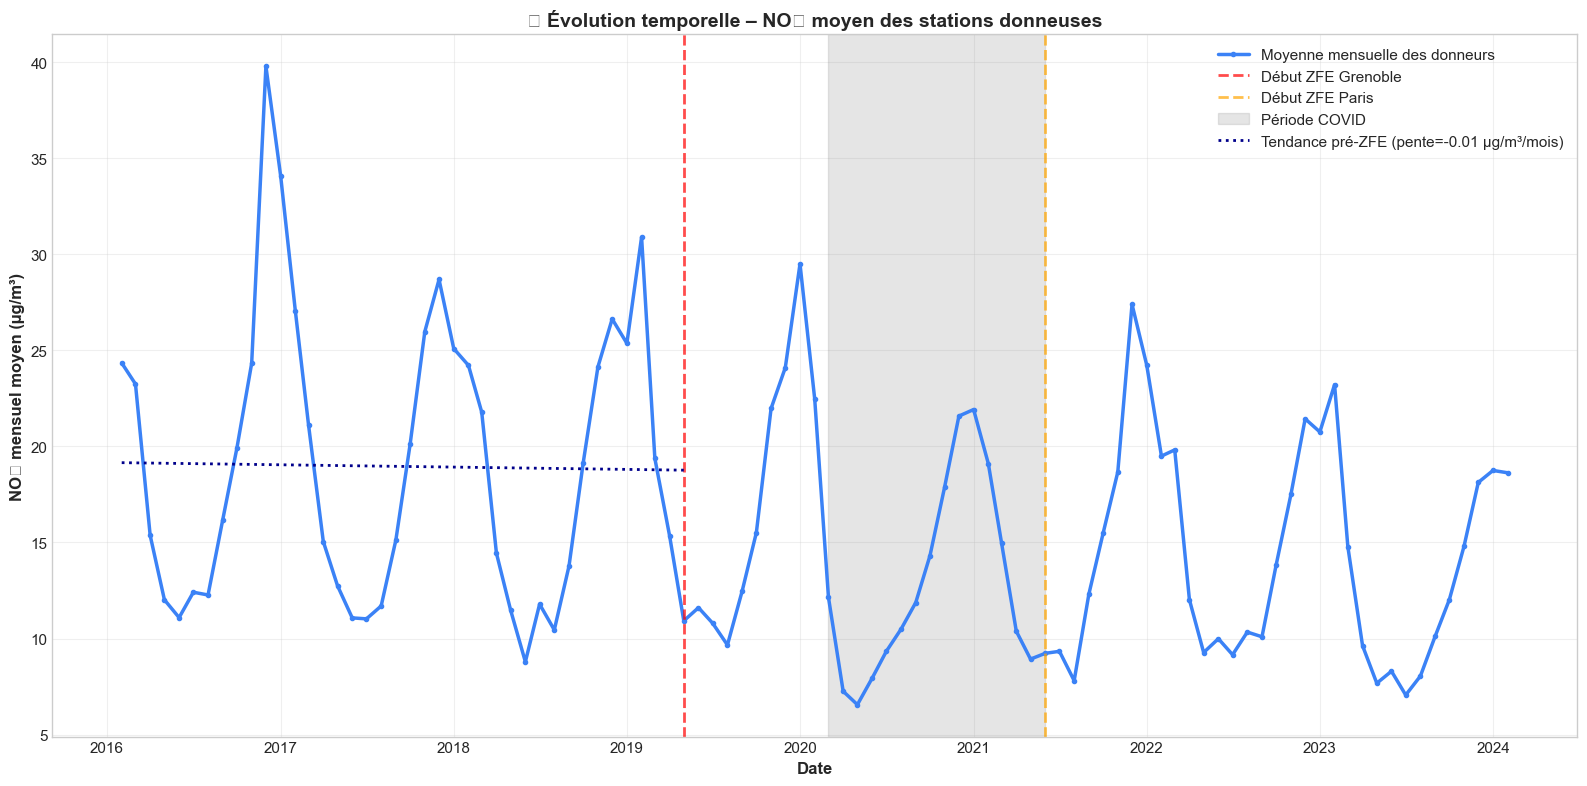

no2_mean_monthly
date                        
2016-02-01         24.344400
2016-03-01         23.247403
2016-04-01         15.365652
2016-05-01         12.019100
2016-06-01         11.090669
2016-07-01         12.411358
2016-08-01         12.268065
2016-09-01         16.184950
2016-10-01         19.935065
2016-11-01         24.330436
2016-12-01         39.786928
2017-01-01         34.096774

In [147]:
# ============================================================================
# 8. ÉVOLUTION TEMPORELLE DES DONNEURS (MOYENNE) — VERSION COMPATIBLE
# (ne dépend pas du CRS / cartes, donc inchangé sauf sécurités)
# ============================================================================

print("\n" + "=" * 80)
print("7️⃣ ÉVOLUTION TEMPORELLE - MOYENNE DES DONNEURS")
print("=" * 80)



# --- Sécurité : s'assurer que date est bien en datetime
donors_daily = donors_daily.copy()
donors_daily["date"] = pd.to_datetime(donors_daily["date"])

# Agrégation mensuelle : moyenne NO2 sur toutes les stations donneuses
donors_monthly = (
    donors_daily
    .set_index("date")["no2_ug_m3"]
    .resample("MS")
    .mean()
)

# --- Dates ZFE (dépend de ton zfe_meta)
grenoble_zfe = pd.to_datetime(
    zfe_meta.loc[zfe_meta["publisher_zfe_id"] == "GRENOBLE", "first_date_debut"].iloc[0]
)
paris_zfe = pd.to_datetime(
    zfe_meta.loc[zfe_meta["publisher_zfe_id"] == "PARIS", "first_date_debut"].iloc[0]
)

# Graphique
fig, ax = plt.subplots(figsize=(16, 8))

ax.plot(
    donors_monthly.index,
    donors_monthly.values,
    linewidth=2.5,
    color="#3b82f6",
    label="Moyenne mensuelle des donneurs",
    marker="o",
    markersize=3
)

# Lignes ZFE
ax.axvline(grenoble_zfe, color="red", linestyle="--", linewidth=2, alpha=0.7, label="Début ZFE Grenoble")
ax.axvline(paris_zfe, color="orange", linestyle="--", linewidth=2, alpha=0.7, label="Début ZFE Paris")

# Zone COVID (tu peux ajuster si besoin)
ax.axvspan(
    pd.Timestamp("2020-03-01"),
    pd.Timestamp("2021-06-01"),
    alpha=0.2,
    color="gray",
    label="Période COVID"
)

# Tendance linéaire pré-ZFE (avant Grenoble, comme dans ton code)
pre_zfe_data = donors_monthly[donors_monthly.index < grenoble_zfe].dropna()

if len(pre_zfe_data) > 12:
    x = np.arange(len(pre_zfe_data))
    z = np.polyfit(x, pre_zfe_data.values, 1)   # z[0] = pente par mois (car index MS)
    p = np.poly1d(z)

    ax.plot(
        pre_zfe_data.index,
        p(x),
        linestyle=":",
        color="darkblue",
        linewidth=2,
        label=f"Tendance pré-ZFE (pente={z[0]:.2f} µg/m³/mois)"
    )

ax.set_title("📈 Évolution temporelle – NO₂ moyen des stations donneuses", fontsize=14, fontweight="bold")
ax.set_xlabel("Date", fontsize=12, fontweight="bold")
ax.set_ylabel("NO₂ mensuel moyen (µg/m³)", fontsize=12, fontweight="bold")
ax.legend(loc="upper right", fontsize=11)
ax.grid(True, alpha=0.3)

plt.tight_layout()
plt.savefig(DATA / "stats_donneurs_evolution_temporelle.png", dpi=300, bbox_inches="tight")
print("✅ Évolution temporelle sauvegardée : stats_donneurs_evolution_temporelle.png")
plt.show()

# Optionnel : aperçu des valeurs mensuelles
display(donors_monthly.to_frame("no2_mean_monthly").head(12))


## 4. Relations entre indicateurs et synthèse descriptive

Cette section examine la cohérence entre les différents indicateurs
et propose une synthèse des statistiques descriptives.


**Intéret d'étudier la corrélation des paramètres :**

L’analyse des corrélations entre les différents indicateurs de NO₂ vise à évaluer dans quelle mesure ils véhiculent une information redondante ou, au contraire, complémentaire. Dans le contexte de cette étude, elle permet d’identifier si des mesures telles que la moyenne annuelle, les percentiles élevés ou les indicateurs d’exposition OMS capturent des dimensions distinctes de la pollution (niveau de fond versus épisodes). L’usage conjoint des corrélations de Pearson et de Spearman permet de vérifier la robustesse des relations observées et d’éviter de multiplier des indicateurs fortement corrélés dans la suite de l’analyse. Cette étape est essentielle pour sélectionner un ensemble restreint d’indicateurs informatifs, interprétables et adaptés à l’évaluation contrefactuelle de l’effet de la ZFE.

### 4.1 Corrélation entre indicateurs



Cette première matrice présente les corrélations (Pearson) entre indicateurs station–année (niveau moyen, queue haute, exposition OMS), sur 110 observations station–année au total, dont 107 jugées valides selon un critère de complétude (≥ 75% de jours observés). L’année 2024 est exclue des corrélations car partielle. La heatmap permet d’identifier les indicateurs redondants (corrélation forte) et ceux qui apportent une information complémentaire (corrélation modérée/faible), afin de sélectionner un petit ensemble d’indicateurs non redondants pour la suite de l’analyse.

Cette seconde matrice (Spearman) reproduit l’analyse des dépendances entre indicateurs en se basant sur les rangs, donc de manière plus robuste aux valeurs extrêmes. Elle est calculée sur les mêmes 110 observations station–année (dont 107 valides, complétude ≥ 75%, 2024 exclue). La comparaison Pearson/Spearman permet de distinguer (i) une relation essentiellement linéaire (cohérence entre les deux) d’une relation monotone mais non linéaire (Spearman plus élevé), ce qui éclaire le choix des indicateurs à retenir sans redondance.

Le premier nuage de points relie, pour chaque observation station–année (échantillon : 110 au total, 107 valides, ≥ 75% de complétude, 2024 exclue), la moyenne annuelle de NO₂ et un indicateur d’épisodes (P95 annuel). Il permet d’évaluer si les stations à forte moyenne sont également celles qui concentrent les pics (relation positive attendue), ou si certains sites présentent un profil « pics élevés » relativement plus marqué que leur moyenne, ce qui est important pour distinguer niveau de fond et épisodes.

Le second nuage de points met en relation la moyenne annuelle de NO₂ et l’exposition OMS mesurée par la fréquence de jours au-dessus de 25 µg/m³ (moyenne 24h), sur 110 observations station–année (107 valides, complétude ≥ 75%, 2024 exclue). Il permet de vérifier que la baisse d’un niveau moyen se traduit bien en réduction d’exposition (jours à risque), et d’identifier d’éventuelles stations où l’exposition reste élevée malgré une moyenne modérée, ce qui renforce l’intérêt d’indicateurs de dépassements en complément des moyennes.


3️⃣ COHÉRENCE ENTRE INDICATEURS — Corrélation moyenne / pics / OMS
ℹ️ Année 2024 exclue des corrélations (année partielle).
✅ CSV sauvegardé : no2_station_annee_indicateurs_corr.csv
ℹ️ Points station–année: total = 110, valides (≥75%) = 107


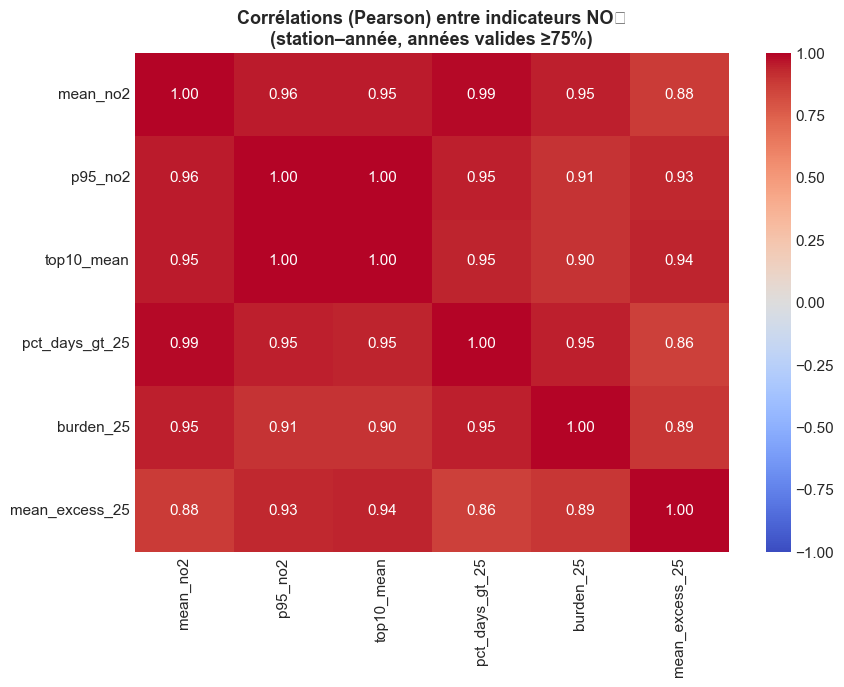

✅ Figure sauvegardée : no2_corr_heatmap_pearson.png


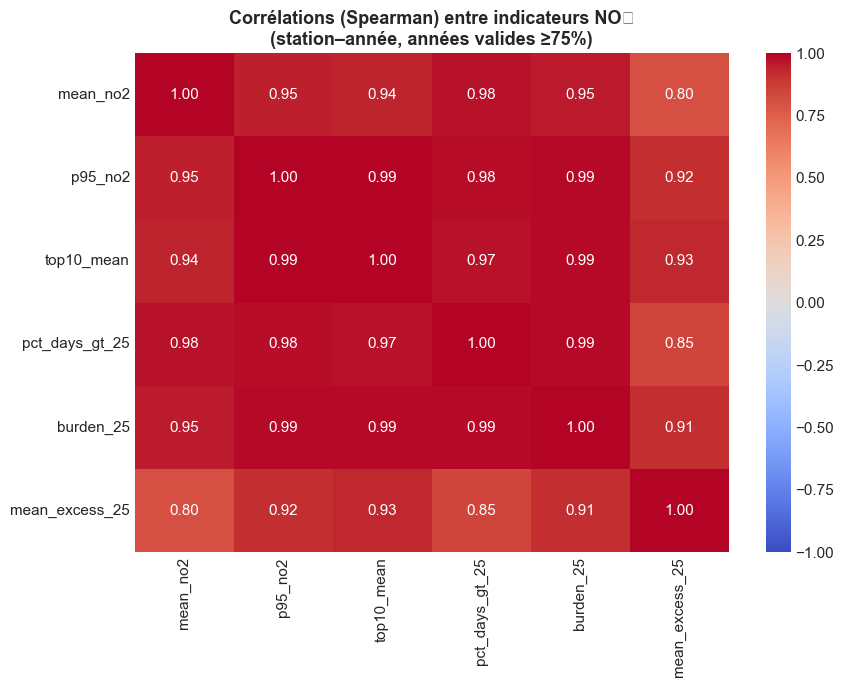

✅ Figure sauvegardée : no2_corr_heatmap_spearman.png


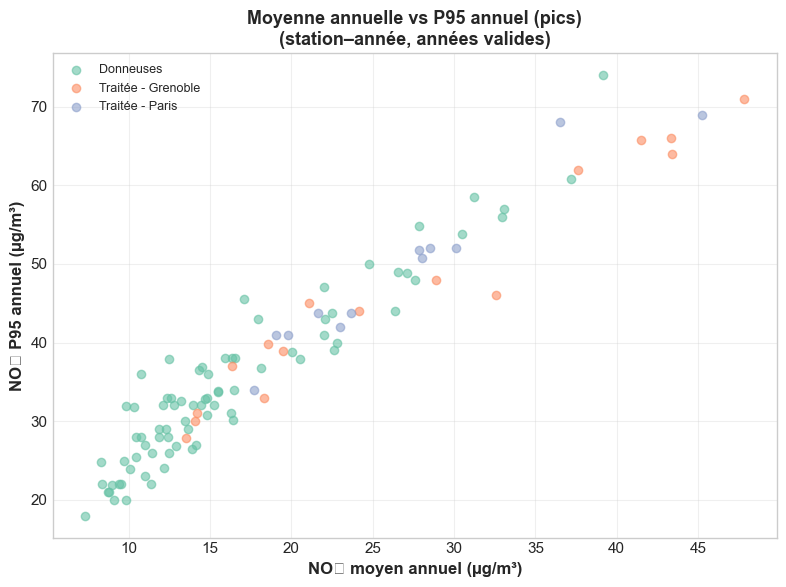

✅ Figure sauvegardée : no2_scatter_mean_vs_p95.png


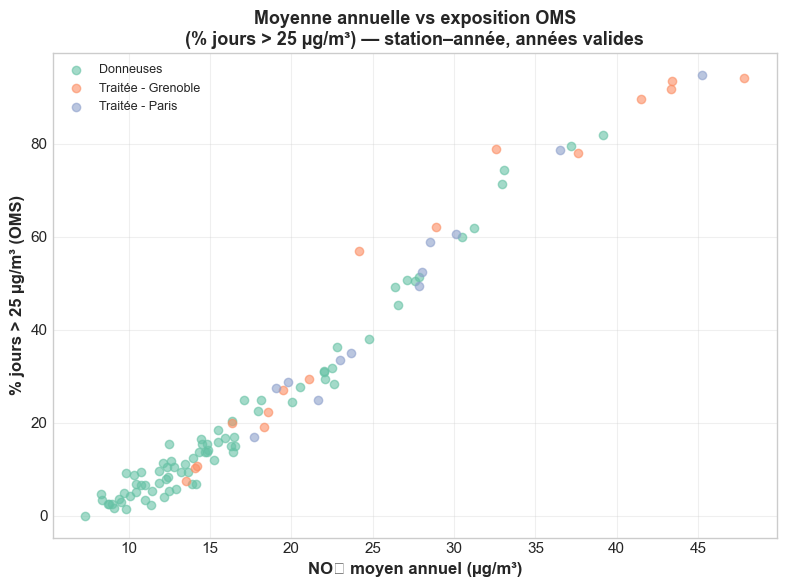

✅ Figure sauvegardée : no2_scatter_mean_vs_pctjours25.png
✅ Analyse de corrélation terminée.


In [ ]:
# ============================================================================
# 3️⃣ COHÉRENCE ENTRE INDICATEURS : corrélation moyenne / pics / OMS
#   Objectif (descriptif):
#   - Vérifier si les indicateurs (moyenne, P95, %jours OMS, charge OMS) sont redondants ou complémentaires
#   - Justifier l'utilisation des indicateurs de queue haute et d'exposition sanitaire
# ============================================================================

print("\n" + "=" * 80)
print("3️⃣ COHÉRENCE ENTRE INDICATEURS — Corrélation moyenne / pics / OMS")
print("=" * 80)


# ----------------------------
# 0) Pré-requis
# ----------------------------
if "all_no2" not in globals():
    raise NameError("all_no2 introuvable. Exécute d'abord la section qui concatène donors + traitées.")
if "DATA" not in globals():
    raise NameError("DATA introuvable (Path).")

df = all_no2.copy()
df["date"] = pd.to_datetime(df["date"])
df["year"] = df["date"].dt.year

# Option recommandée : exclure 2024 si année partielle
EXCLUDE_PARTIAL_YEAR = True
PARTIAL_YEAR = 2024
if EXCLUDE_PARTIAL_YEAR and PARTIAL_YEAR in df["year"].unique():
    df = df[df["year"] != PARTIAL_YEAR].copy()
    print(f"ℹ️ Année {PARTIAL_YEAR} exclue des corrélations (année partielle).")

# Seuil OMS journalier
OMS_DAILY = 25.0
df["excess_25"] = (df["no2_ug_m3"] - OMS_DAILY).clip(lower=0)
df["flag_gt_25"] = df["no2_ug_m3"] > OMS_DAILY

def top_share_mean(x, share=0.10):
    x = pd.Series(x).dropna().sort_values()
    if len(x) == 0:
        return np.nan
    k = max(1, int(np.ceil(len(x) * share)))
    return x.iloc[-k:].mean()

# ----------------------------
# 1) Indicateurs station–année
# ----------------------------
station_year_ind = (
    df.groupby(["group", "station_id", "station_name", "year"])
      .agg(
          n_days=("no2_ug_m3", "count"),
          mean_no2=("no2_ug_m3", "mean"),
          median_no2=("no2_ug_m3", "median"),
          p90_no2=("no2_ug_m3", lambda s: np.nanpercentile(s.dropna(), 90) if s.dropna().shape[0] else np.nan),
          p95_no2=("no2_ug_m3", lambda s: np.nanpercentile(s.dropna(), 95) if s.dropna().shape[0] else np.nan),
          top10_mean=("no2_ug_m3", lambda s: top_share_mean(s, 0.10)),
          days_gt_25=("flag_gt_25", "sum"),
          burden_25=("excess_25", "sum"),
          mean_excess_25=("excess_25", lambda s: float(s[s > 0].mean()) if (s > 0).any() else 0.0),
      )
      .reset_index()
)

station_year_ind["pct_days_gt_25"] = 100 * station_year_ind["days_gt_25"] / station_year_ind["n_days"]

# Filtre qualité : garder uniquement années assez couvertes (optionnel mais recommandé)
# Ici: >= 75% des jours
days_in_year = station_year_ind["year"].apply(
    lambda y: 366 if pd.Timestamp(f"{y}-12-31").dayofyear == 366 else 365
)
station_year_ind["pct_days_obs"] = 100 * station_year_ind["n_days"] / days_in_year
station_year_ind["valid_year_75pct"] = station_year_ind["pct_days_obs"] >= 75

# On fait les corrélations sur les années valides pour éviter biais de couverture
ind_valid = station_year_ind[station_year_ind["valid_year_75pct"]].copy()

station_year_ind.to_csv(DATA / "no2_station_annee_indicateurs_corr.csv", index=False)
print("✅ CSV sauvegardé : no2_station_annee_indicateurs_corr.csv")

print(f"ℹ️ Points station–année: total = {len(station_year_ind)}, valides (≥75%) = {len(ind_valid)}")

# ----------------------------
# 2) Heatmap de corrélation (Pearson + Spearman)
# ----------------------------
cols = ["mean_no2", "p95_no2", "top10_mean", "pct_days_gt_25", "burden_25", "mean_excess_25"]

corr_pearson = ind_valid[cols].corr(method="pearson")
corr_spearman = ind_valid[cols].corr(method="spearman")

fig, ax = plt.subplots(figsize=(9, 7))
sns.heatmap(corr_pearson, annot=True, fmt=".2f", cmap="coolwarm", vmin=-1, vmax=1, ax=ax)
ax.set_title("Corrélations (Pearson) entre indicateurs NO₂\n(station–année, années valides ≥75%)",
             fontsize=13, fontweight="bold")
plt.tight_layout()
plt.savefig(DATA / "no2_corr_heatmap_pearson.png", dpi=300, bbox_inches="tight")
plt.show()
print("✅ Figure sauvegardée : no2_corr_heatmap_pearson.png")

fig, ax = plt.subplots(figsize=(9, 7))
sns.heatmap(corr_spearman, annot=True, fmt=".2f", cmap="coolwarm", vmin=-1, vmax=1, ax=ax)
ax.set_title("Corrélations (Spearman) entre indicateurs NO₂\n(station–année, années valides ≥75%)",
             fontsize=13, fontweight="bold")
plt.tight_layout()
plt.savefig(DATA / "no2_corr_heatmap_spearman.png", dpi=300, bbox_inches="tight")
plt.show()
print("✅ Figure sauvegardée : no2_corr_heatmap_spearman.png")

# ----------------------------
# 3) Scatter synthétiques (complément visuel utile)
# ----------------------------
# a) moyenne vs P95 (pics)
fig, ax = plt.subplots(figsize=(8, 6))
for grp in ind_valid["group"].unique():
    d = ind_valid[ind_valid["group"] == grp]
    ax.scatter(d["mean_no2"], d["p95_no2"], alpha=0.6, label=grp)

ax.set_title("Moyenne annuelle vs P95 annuel (pics)\n(station–année, années valides)",
             fontsize=13, fontweight="bold")
ax.set_xlabel("NO₂ moyen annuel (µg/m³)", fontweight="bold")
ax.set_ylabel("NO₂ P95 annuel (µg/m³)", fontweight="bold")
ax.grid(True, alpha=0.3)
ax.legend(fontsize=9)
plt.tight_layout()
plt.savefig(DATA / "no2_scatter_mean_vs_p95.png", dpi=300, bbox_inches="tight")
plt.show()
print("✅ Figure sauvegardée : no2_scatter_mean_vs_p95.png")

# b) moyenne vs % jours OMS
fig, ax = plt.subplots(figsize=(8, 6))
for grp in ind_valid["group"].unique():
    d = ind_valid[ind_valid["group"] == grp]
    ax.scatter(d["mean_no2"], d["pct_days_gt_25"], alpha=0.6, label=grp)

ax.set_title("Moyenne annuelle vs exposition OMS\n(% jours > 25 µg/m³) — station–année, années valides",
             fontsize=13, fontweight="bold")
ax.set_xlabel("NO₂ moyen annuel (µg/m³)", fontweight="bold")
ax.set_ylabel("% jours > 25 µg/m³ (OMS)", fontweight="bold")
ax.grid(True, alpha=0.3)
ax.legend(fontsize=9)
plt.tight_layout()
plt.savefig(DATA / "no2_scatter_mean_vs_pctjours25.png", dpi=300, bbox_inches="tight")
plt.show()
print("✅ Figure sauvegardée : no2_scatter_mean_vs_pctjours25.png")

print("✅ Analyse de corrélation terminée.")


### 4.2 Tableau de synthèse final

In [149]:
# ============================================================================
# 8️⃣ TABLEAU DE SYNTHÈSE DESCRIPTIVE FINAL
# ============================================================================

print("\n" + "=" * 80)
print("8️⃣ TABLEAU DE SYNTHÈSE DESCRIPTIVE — NO₂")
print("=" * 80)

import pandas as pd

# ----------------------------
# 1) Base station–année (années valides uniquement)
# ----------------------------
if "station_year_ind" not in globals():
    raise NameError("station_year_ind introuvable (section corrélation).")

df_ind = station_year_ind.copy()
df_ind = df_ind[df_ind["valid_year_75pct"]].copy()

# ----------------------------
# 2) Saisonnalité (hiver / été)
# ----------------------------
if "station_year_season" not in globals():
    raise NameError("station_year_season introuvable (section saisonnalité).")

df_seas = station_year_season.copy()
df_seas = df_seas[df_seas["season"].isin(["Hiver (DJF)", "Été (JJA)"])]

season_wide = (
    df_seas
    .pivot_table(
        index=["group", "station_id", "station_name", "year"],
        columns="season",
        values="mean_no2"
    )
    .reset_index()
)

# ----------------------------
# 3) Fusion indicateurs + saisonnalité
# ----------------------------
df_full = df_ind.merge(
    season_wide,
    on=["group", "station_id", "station_name", "year"],
    how="left"
)

# ----------------------------
# 4) Tableau de synthèse par groupe
# ----------------------------
summary_table = (
    df_full
    .groupby("group")
    .agg(
        n_stations=("station_id", "nunique"),
        n_station_years=("year", "count"),
        mean_no2=("mean_no2", "mean"),
        p95_no2=("p95_no2", "mean"),
        pct_days_gt_25=("pct_days_gt_25", "mean"),
        mean_no2_winter=("Hiver (DJF)", "mean"),
        mean_no2_summer=("Été (JJA)", "mean"),
    )
    .reset_index()
)

# Arrondis lisibles
summary_table = summary_table.round({
    "mean_no2": 1,
    "p95_no2": 1,
    "pct_days_gt_25": 1,
    "mean_no2_winter": 1,
    "mean_no2_summer": 1,
})

# ----------------------------
# 5) Affichage & sauvegarde
# ----------------------------
display(summary_table)

summary_table.to_csv(
    DATA / "no2_tableau_synthese_descriptif.csv",
    index=False
)

print("✅ Tableau de synthèse sauvegardé : no2_tableau_synthese_descriptif.csv")



8️⃣ TABLEAU DE SYNTHÈSE DESCRIPTIVE — NO₂


group  n_stations  n_station_years  mean_no2  p95_no2  \
0           Donneuses          10               79      16.3     34.6   
1  Traitée - Grenoble           2               16      27.2     46.8   
2     Traitée - Paris           2               12      26.8     49.1   

   pct_days_gt_25  mean_no2_winter  mean_no2_summer  
0            19.4             25.7              9.9  
1            49.4             35.7             22.1  
2            46.7             30.6             21.1

✅ Tableau de synthèse sauvegardé : no2_tableau_synthese_descriptif.csv


# Conclusion 

Les statistiques descriptives présentées dans cette section fournissent un cadrage complet des concentrations de NO₂ sur le périmètre étudié et mettent en évidence plusieurs résultats structurants pour l’analyse. En premier lieu, les niveaux observés demeurent élevés au regard des valeurs guides sanitaires de l’Organisation mondiale de la Santé, y compris dans des situations de conformité aux normes réglementaires européennes, soulignant l’enjeu sanitaire associé aux émissions liées au trafic routier. L’analyse des distributions et de la queue haute montre en outre que l’exposition ne se limite pas au niveau moyen, mais est fortement marquée par des épisodes de pollution aiguë, en particulier sur les stations influencées par le trafic.

Par ailleurs, les statistiques descriptives mettent en évidence une forte hétérogénéité spatiale des concentrations, structurée par la typologie des stations (trafic versus fond) et par leur localisation au sein ou à proximité des zones urbaines denses. Cette hétérogénéité s’accompagne d’une saisonnalité marquée, avec des niveaux plus élevés en période hivernale, ce qui souligne l’importance de distinguer les effets potentiels de la ZFE des variations saisonnières et météorologiques. L’analyse de la complétude des données confirme enfin la disponibilité de séries temporelles suffisamment robustes pour conduire une analyse longitudinale, tout en justifiant l’exclusion ou le traitement spécifique de certaines observations.

Enfin, la comparaison descriptive des trajectoires temporelles entre la zone traitée et les stations donneuses montre des dynamiques globalement comparables en période pré-traitement, tant en niveau qu’en saisonnalité. Ce résultat constitue une condition nécessaire à l’application d’une approche contrefactuelle et suggère que les stations donneuses peuvent fournir une approximation crédible de l’évolution des concentrations qui aurait prévalu en l’absence de la ZFE. Dans ce contexte, une comparaison simple avant/après apparaît insuffisante pour isoler l’effet propre de la politique étudiée, en raison de la coexistence de tendances générales, de facteurs confondants et d’une forte hétérogénéité locale. La section suivante introduit donc la méthodologie de contrôle synthétique (Synthetic Control Method), qui permet de construire un contrefactuel à partir d’un ensemble pondéré de stations donneuses afin d’estimer l’effet causal de la ZFE sur les concentrations de NO₂.